<a href="https://colab.research.google.com/github/sjquill/MSc_diss/blob/main/BREAST_Data/Breast_DeepSurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines
!pip install pycox
!pip install torchtuples

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 6.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e6dbe956a7905e92ed126a484d58a19197a106849330682e47a894b90eb0cd98
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/1

In [ ]:
import pickle
import lifelines
import numpy as np
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

import torch
import torchtuples as tt


In [ ]:
import pandas as pd

breast_train_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_train_data_imputed1.csv")
breast_test_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_test_data_imputed1.csv")
train_data = breast_train_data_imputed1.copy()
test_data = breast_test_data_imputed1.copy()

In [ ]:
column_names = [
    'mask_id',
    'disease_free_survival_status',
    'disease_free_survival_months',
    'race_asian',
    'race_black',
    'race_other',
    'Treatment_CA_6',
    'Treatment_T_4',
    'Treatment_T_6',
    'post_menopausal',
    'tumor_side_right',
    'tumor_side_bilateral',
    'receptor_status_er_pos',
    'receptor_status_pgrn_pos',
    'histologic_grade_inter',
    'histologic_grade_high',
    'her2_status_pos',
    'prior_hormonal_therapy_yes',
    'most_extensive_primary_surgery_mast_NOS',
    'tumor_size_2_to_5cm',
    'tumor_size_over_5cm',
    'num_pos_nodes_1',
    'num_pos_nodes_2+',
    'age_over_fifty'
]
# Set the new column names
train_data.columns = column_names
test_data.columns = column_names

In [ ]:
import numpy as np

y_train = np.empty(len(train_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
y_train['disease_free_survival_status'] = train_data['disease_free_survival_status'].astype(bool)
y_train['disease_free_survival_months'] = train_data['disease_free_survival_months']

x_train = train_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])

# Repeat for test data.

y_test = np.empty(len(test_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
y_test['disease_free_survival_status'] = test_data['disease_free_survival_status'].astype(bool)
y_test['disease_free_survival_months'] = test_data['disease_free_survival_months']

x_test = test_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train['disease_free_survival_status'], random_state=42
)


In [ ]:
# Print the sizes of each set
print("Train set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Test set size:", len(x_test))

Train set size: 2000
Validation set size: 500
Test set size: 624


In [ ]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# Convert y_train to a 2D numpy array


# Convert structured array to a 2D numpy array
y_train_2d = np.array(y_train.tolist())

# Convert boolean indicators to binary integers
y_train_2d[:, 0] = y_train_2d[:, 0].astype(int)

# Ensure time of events is float
y_train_2d[:, 1] = y_train_2d[:, 1].astype(float)

x_train = x_train.astype(np.float32)


# Validation set
# Convert structured array to a 2D numpy array
y_val_2d = np.array(y_val.tolist())

# Convert boolean indicators to binary integers
y_val_2d[:, 0] = y_val_2d[:, 0].astype(int)

# Ensure time of events is float
y_val_2d[:, 1] = y_val_2d[:, 1].astype(float)


## testing set
# Convert structured array to a 2D numpy array
y_test_2d = np.array(y_test.tolist())

# Convert boolean indicators to binary integers
y_test_2d[:, 0] = y_test_2d[:, 0].astype(int)

# Ensure time of events is float
y_test_2d[:, 1] = y_test_2d[:, 1].astype(float)

x_test = x_test.astype(np.float32)

import numpy as np

x_train = x_train.values
print(type(x_train))


x_test = x_test.values
print(type(x_test))


x_val = x_val.values
print(type(x_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(type(y_train_2d))
print(type(x_train))

print(type(y_val_2d))
print(type(x_val))

print(type(y_test_2d))
print(type(x_test))

print(y_train_2d.shape)
print(x_train.shape)

print(y_val_2d.shape)
print(x_val.shape)

print(y_test_2d.shape)
print(x_test.shape)




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2000, 2)
(2000, 21)
(500, 2)
(500, 21)
(624, 2)
(624, 21)


In [ ]:
y_train_event = y_train['disease_free_survival_status'].astype(np.float32)  # Convert Boolean to float for consistency
y_train_surv = y_train['disease_free_survival_months'].astype(np.float32)

y_train = (y_train_surv,y_train_event)

y_val_event = y_val['disease_free_survival_status'].astype(np.float32)  # Convert Boolean to float for consistency
y_val_surv = y_val['disease_free_survival_months'].astype(np.float32)


y_test_event = y_test['disease_free_survival_status'].astype(np.float32)  # Convert Boolean to float for consistency
y_test_surv = y_test['disease_free_survival_months'].astype(np.float32)

y_val = (y_val_surv,y_val_event)

val = (x_val,y_val)


In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False


net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)

0.10722672220103299

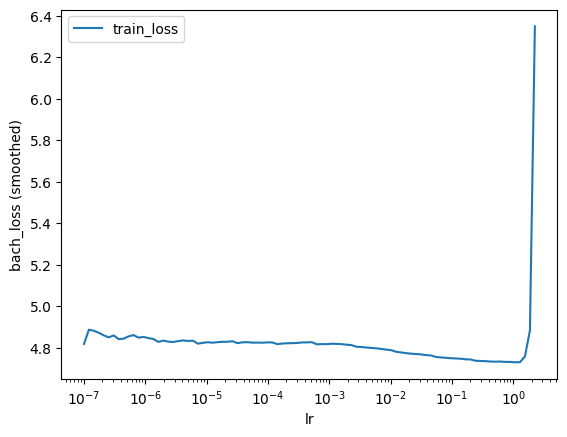

In [ ]:
batch_size = 256

lrfinder = model.lr_finder(x_train, (y_train_event,y_train_surv), batch_size, tolerance=10)
_ = lrfinder.plot()

lrfinder.get_best_lr()

In [ ]:
model.optimizer.set_lr(0.01)
epochs = 200
callbacks = [tt.callbacks.EarlyStopping(patience = 50)]
verbose = True

0:	[0s / 0s],		train_loss: 5.3034,	val_loss: 4.9580
1:	[0s / 0s],		train_loss: 5.1008,	val_loss: 4.9332
2:	[1s / 2s],		train_loss: 5.0373,	val_loss: 4.9185
3:	[0s / 2s],		train_loss: 5.0087,	val_loss: 4.9598
4:	[0s / 3s],		train_loss: 4.9808,	val_loss: 4.9947
5:	[0s / 3s],		train_loss: 4.9455,	val_loss: 5.1012
6:	[0s / 3s],		train_loss: 4.8629,	val_loss: 5.1964
7:	[0s / 3s],		train_loss: 4.8035,	val_loss: 5.3212
8:	[0s / 3s],		train_loss: 4.7658,	val_loss: 5.4159
9:	[0s / 4s],		train_loss: 4.7574,	val_loss: 5.3970
10:	[0s / 4s],		train_loss: 4.6748,	val_loss: 5.4657
11:	[0s / 4s],		train_loss: 4.5828,	val_loss: 5.5726
12:	[0s / 4s],		train_loss: 4.5880,	val_loss: 5.6736
13:	[0s / 4s],		train_loss: 4.5714,	val_loss: 5.9246
14:	[0s / 4s],		train_loss: 4.6903,	val_loss: 5.9431
15:	[0s / 4s],		train_loss: 4.5410,	val_loss: 5.9134
16:	[0s / 4s],		train_loss: 4.5154,	val_loss: 5.9357
17:	[0s / 4s],		train_loss: 4.4775,	val_loss: 5.9611
18:	[0s / 4s],		train_loss: 4.5202,	val_loss: 6.0695
19:

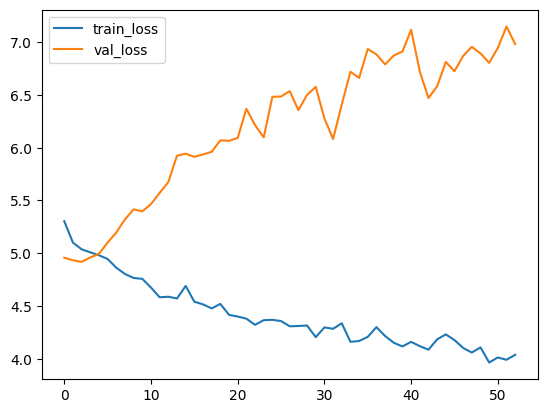

In [ ]:

# Then use these in your fit call:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
_ = log.plot()

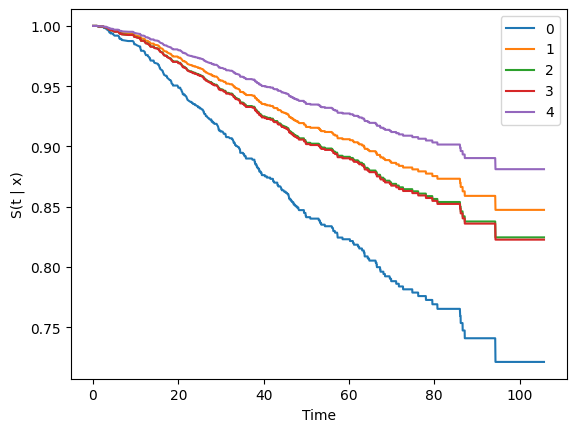

In [ ]:
model.partial_log_likelihood(*val).mean()

_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

import matplotlib.pyplot as plt
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
from pycox.evaluation import EvalSurv
ev = EvalSurv(surv, y_test_surv, y_test_event, censor_surv='km')
ev.concordance_td()

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.6226428370391218

In [ ]:
#### Randomised search attempt 3


from sklearn.base import BaseEstimator
from scipy.stats import randint, uniform
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

class DeepSURVSklearnAdapter(BaseEstimator):
    def __init__(
        self,
        learning_rate=1e-4,
        batch_norm=True,
        dropout=0.0,
        num_nodes=[32, 32],
        batch_size=128,
        epochs=10,
        weight_decay=0.0,
        patience=50,
        num_layers=2,
        num_nodes_per_layer=20
    ):
        self.learning_rate = learning_rate
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.patience = patience
        self.num_layers = num_layers
        self.num_nodes_per_layer = num_nodes_per_layer

    def fit(self, X, y, validation_data=None):
      num_nodes = [self.num_nodes_per_layer] * self.num_layers
      self.net_ = tt.practical.MLPVanilla(
            X.shape[1],
            num_nodes,
            1,
            self.batch_norm,
            self.dropout,
            output_bias=True,
        )
      self.deepsurv_ = CoxPH(self.net_, tt.optim.Adam(self.learning_rate, weight_decay=self.weight_decay))
      y_ = (y[:, 0], y[:, 1])

      callbacks = [tt.callbacks.EarlyStopping(patience=self.patience)]
      log = self.deepsurv_.fit(
            X,
            y_,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=callbacks,
            val_data=validation_data,
            verbose=False,
        )

      return self

    def score(self, X, y):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[:, 0],
            y[:, 1],
            censor_surv="km",
        )

        return ev.concordance_td()


def DeepSURV(param_distributions, n_jobs, n_iter=100):

    estimator = DeepSURVSklearnAdapter()

    surv = RandomizedSearchCV(estimator=estimator, cv=None, param_distributions=param_distributions,
                              n_jobs=n_jobs, n_iter=n_iter)

    surv.fit(x_train, y_train_2d, validation_data=(x_val, y_val))

    print("Best Estimator learned through RandomizedSearch")
    print(surv.best_estimator_)

    return surv.best_estimator_

param_distributions = {
    'learning_rate': uniform(0.001, 0.01),
    'num_layers': randint(1, 4),
    'num_nodes_per_layer': randint(5, 40),
    'batch_norm': [True, False],
    'dropout': uniform(0, 0.5),
    'batch_size': randint(32, 264),
    'epochs': [100],
    'patience': randint(25,100),
    'weight_decay': uniform(0, 0.5)
}

n_jobs = -1

best_est = DeepSURV(param_distributions, n_jobs)




/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-21-2138614a6197>", line 51, in fit
  File "/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py", line 51, in fit
    return super().fit(input, target, batch_size, epochs, callbacks, verbose,
  File "/usr/local/lib/python3.10/dist-packages/torchtuples/base.py", line 294, in fit
    log 

Best Estimator learned through RandomizedSearch
DeepSURVSklearnAdapter(batch_norm=False, batch_size=113,
                       dropout=0.11714902934577448, epochs=100,
                       learning_rate=0.004940957296838224,
                       num_nodes_per_layer=16, patience=67,
                       weight_decay=0.045113108680127245)


0:	[0s / 0s],		train_loss: 4.3895,	val_loss: 4.0425
1:	[0s / 0s],		train_loss: 4.3384,	val_loss: 4.0408
2:	[0s / 0s],		train_loss: 4.3332,	val_loss: 4.0362
3:	[0s / 0s],		train_loss: 4.2894,	val_loss: 4.0360
4:	[0s / 0s],		train_loss: 4.2912,	val_loss: 4.0338
5:	[0s / 0s],		train_loss: 4.2824,	val_loss: 4.0383
6:	[0s / 0s],		train_loss: 4.2614,	val_loss: 4.0432
7:	[0s / 0s],		train_loss: 4.2846,	val_loss: 4.0337
8:	[0s / 0s],		train_loss: 4.2435,	val_loss: 4.0382
9:	[0s / 0s],		train_loss: 4.2550,	val_loss: 4.0336
10:	[0s / 0s],		train_loss: 4.2485,	val_loss: 4.0545
11:	[0s / 0s],		train_loss: 4.2414,	val_loss: 4.0437
12:	[0s / 0s],		train_loss: 4.2752,	val_loss: 4.0381
13:	[0s / 0s],		train_loss: 4.2602,	val_loss: 4.0436
14:	[0s / 0s],		train_loss: 4.2421,	val_loss: 4.0309
15:	[0s / 0s],		train_loss: 4.2268,	val_loss: 4.0273
16:	[0s / 0s],		train_loss: 4.2302,	val_loss: 4.0239
17:	[0s / 0s],		train_loss: 4.2367,	val_loss: 4.0438
18:	[0s / 0s],		train_loss: 4.2442,	val_loss: 4.0319
19:

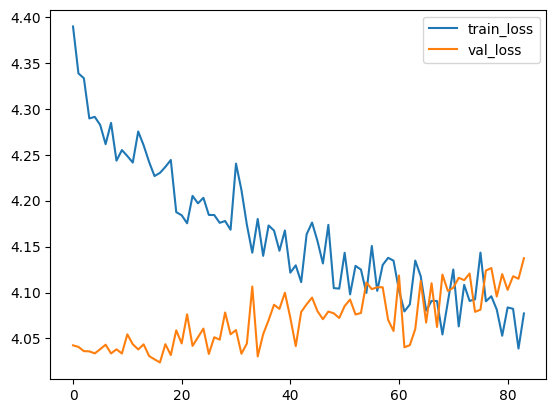

In [ ]:

learning_rate = best_est.learning_rate
num_nodes = best_est.num_nodes
batch_norm = best_est.batch_norm
dropout = best_est.dropout
batch_size = best_est.batch_size
epochs = best_est.epochs
patience = best_est.patience
weight_decay = best_est.weight_decay


# Define the network architecture and the model
in_features = x_train.shape[1]
out_features = 1
output_bias = False
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
model = CoxPH(net, tt.optim.Adam(learning_rate, weight_decay = weight_decay))

# Set up the training parameters and train the model
model.optimizer.set_lr(learning_rate)
callbacks = [tt.callbacks.EarlyStopping(patience=patience)]
verbose = True

# Train the model and plot the training performance
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
_ = log.plot()

In [ ]:

from pycox.evaluation import EvalSurv

model.partial_log_likelihood(*val).mean()

_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

ev = EvalSurv(surv, y_test_surv, y_test_event, censor_surv='km')
ev.concordance_td()

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.6487897551365044

In [ ]:
from sklearn.utils import resample
import numpy as np
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv


# Number of bootstrap iterations
n_bootstrap_iterations = 200

# Arrays to store bootstrap C-indices and IBS scores
c_indices_deepsurv = np.zeros(n_bootstrap_iterations)
ibs_scores_deepsurv = np.zeros(n_bootstrap_iterations)

for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample of indices
    bootstrap_indices = resample(np.arange(len(x_train)), replace=True)

     # Use these indices to create bootstrap samples
    bootstrap_train_x = x_train[bootstrap_indices]
    bootstrap_train_y_time = y_train[0][bootstrap_indices]
    bootstrap_train_y_event = y_train[1][bootstrap_indices]
    bootstrap_train_y = (bootstrap_train_y_time, bootstrap_train_y_event)

    # Define the network architecture and the model
    in_features = bootstrap_train_x.shape[1]
    out_features = 1
    output_bias = False
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
    bootstrap_model = CoxPH(net, tt.optim.Adam(learning_rate, weight_decay = weight_decay))

    # Set up the training parameters and train the model
    bootstrap_model.optimizer.set_lr(learning_rate)
    callbacks = [tt.callbacks.EarlyStopping(patience=patience)]
    verbose = True

    # Fit the model using the resampled training data
    log = bootstrap_model.fit(bootstrap_train_x, bootstrap_train_y, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)

    bootstrap_model.compute_baseline_hazards()

    # Evaluate on the test set
    surv = bootstrap_model.predict_surv_df(x_test)
    ev_test = EvalSurv(surv, y_test_surv, y_test_event, censor_surv='km')
    c_index_test = ev_test.concordance_td('antolini')
    c_indices_deepsurv[i] = c_index_test

    # Calculate the integrated Brier score
    ibs = ev_test.integrated_brier_score(time_grid=np.linspace(0, y_test_surv.max(), 100))
    ibs_scores_deepsurv[i] = ibs

# Compute the lower and upper percentiles for C-index
lower_percentile_c_index = np.percentile(c_indices_deepsurv, 2.5)
upper_percentile_c_index = np.percentile(c_indices_deepsurv, 97.5)

# Compute the lower and upper percentiles for IBS
lower_percentile_ibs = np.percentile(ibs_scores_deepsurv, 2.5)
upper_percentile_ibs = np.percentile(ibs_scores_deepsurv, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the IBS: ({:.2f}, {:.2f})'.format(lower_percentile_ibs, upper_percentile_ibs))


0:	[0s / 0s],		train_loss: 4.4232,	val_loss: 4.0456
1:	[0s / 0s],		train_loss: 4.2723,	val_loss: 4.0504
2:	[0s / 0s],		train_loss: 4.2454,	val_loss: 4.0823
3:	[0s / 0s],		train_loss: 4.2161,	val_loss: 4.0780
4:	[0s / 0s],		train_loss: 4.1676,	val_loss: 4.0920
5:	[0s / 0s],		train_loss: 4.1741,	val_loss: 4.0874
6:	[0s / 0s],		train_loss: 4.1492,	val_loss: 4.1204
7:	[0s / 1s],		train_loss: 4.1210,	val_loss: 4.1284
8:	[0s / 1s],		train_loss: 4.0610,	val_loss: 4.1436
9:	[0s / 1s],		train_loss: 4.1010,	val_loss: 4.1236
10:	[0s / 1s],		train_loss: 4.0847,	val_loss: 4.1129
11:	[0s / 1s],		train_loss: 4.0793,	val_loss: 4.1196
12:	[0s / 1s],		train_loss: 4.0343,	val_loss: 4.1731
13:	[0s / 1s],		train_loss: 4.0147,	val_loss: 4.1977
14:	[0s / 1s],		train_loss: 3.9437,	val_loss: 4.2299
15:	[0s / 1s],		train_loss: 3.9531,	val_loss: 4.2410
16:	[0s / 1s],		train_loss: 3.9425,	val_loss: 4.2607
17:	[0s / 1s],		train_loss: 3.9962,	val_loss: 4.2979
18:	[0s / 1s],		train_loss: 3.8750,	val_loss: 4.3101
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4263,	val_loss: 4.0695
1:	[0s / 0s],		train_loss: 4.3016,	val_loss: 4.0711
2:	[0s / 0s],		train_loss: 4.2386,	val_loss: 4.0755
3:	[0s / 0s],		train_loss: 4.2200,	val_loss: 4.0829
4:	[0s / 0s],		train_loss: 4.2129,	val_loss: 4.1019
5:	[0s / 0s],		train_loss: 4.1843,	val_loss: 4.1162
6:	[0s / 0s],		train_loss: 4.1591,	val_loss: 4.1274
7:	[0s / 0s],		train_loss: 4.1278,	val_loss: 4.1299
8:	[0s / 0s],		train_loss: 4.1448,	val_loss: 4.1526
9:	[0s / 0s],		train_loss: 4.1007,	val_loss: 4.1643
10:	[0s / 0s],		train_loss: 4.1384,	val_loss: 4.1308
11:	[0s / 0s],		train_loss: 4.0775,	val_loss: 4.1824
12:	[0s / 0s],		train_loss: 4.0551,	val_loss: 4.2145
13:	[0s / 0s],		train_loss: 4.0232,	val_loss: 4.2215
14:	[0s / 0s],		train_loss: 3.9888,	val_loss: 4.2504
15:	[0s / 0s],		train_loss: 3.9929,	val_loss: 4.2087
16:	[0s / 0s],		train_loss: 3.9170,	val_loss: 4.3714
17:	[0s / 0s],		train_loss: 3.9837,	val_loss: 4.2312
18:	[0s / 0s],		train_loss: 4.0229,	val_loss: 4.2963
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4199,	val_loss: 3.9758
1:	[0s / 0s],		train_loss: 4.2973,	val_loss: 3.9848
2:	[0s / 0s],		train_loss: 4.2481,	val_loss: 4.0021
3:	[0s / 0s],		train_loss: 4.2472,	val_loss: 3.9957
4:	[0s / 0s],		train_loss: 4.1927,	val_loss: 4.0073
5:	[0s / 0s],		train_loss: 4.1622,	val_loss: 4.0613
6:	[0s / 0s],		train_loss: 4.1316,	val_loss: 4.0837
7:	[0s / 0s],		train_loss: 4.1412,	val_loss: 4.1067
8:	[0s / 0s],		train_loss: 4.1139,	val_loss: 4.1201
9:	[0s / 0s],		train_loss: 4.0989,	val_loss: 4.1617
10:	[0s / 0s],		train_loss: 4.0650,	val_loss: 4.1860
11:	[0s / 0s],		train_loss: 4.0405,	val_loss: 4.2284
12:	[0s / 0s],		train_loss: 4.0472,	val_loss: 4.1964
13:	[0s / 0s],		train_loss: 4.0067,	val_loss: 4.2628
14:	[0s / 0s],		train_loss: 3.9755,	val_loss: 4.2967
15:	[0s / 0s],		train_loss: 3.9840,	val_loss: 4.3110
16:	[0s / 0s],		train_loss: 3.9200,	val_loss: 4.2763
17:	[0s / 0s],		train_loss: 3.9630,	val_loss: 4.2718
18:	[0s / 0s],		train_loss: 3.9089,	val_loss: 4.3399
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3099,	val_loss: 4.0858
2:	[0s / 0s],		train_loss: 4.2766,	val_loss: 4.0919
3:	[0s / 0s],		train_loss: 4.2274,	val_loss: 4.0613
4:	[0s / 0s],		train_loss: 4.1916,	val_loss: 4.0595
5:	[0s / 0s],		train_loss: 4.2464,	val_loss: 4.0337
6:	[0s / 0s],		train_loss: 4.1926,	val_loss: 4.0197
7:	[0s / 0s],		train_loss: 4.1674,	val_loss: 4.0296
8:	[0s / 0s],		train_loss: 4.1508,	val_loss: 4.0266
9:	[0s / 0s],		train_loss: 4.1566,	val_loss: 4.0403
10:	[0s / 0s],		train_loss: 4.1135,	val_loss: 4.0463
11:	[0s / 0s],		train_loss: 4.0452,	val_loss: 4.0809
12:	[0s / 0s],		train_loss: 4.0853,	val_loss: 4.0490
13:	[0s / 0s],		train_loss: 3.9731,	val_loss: 4.0962
14:	[0s / 0s],		train_loss: 4.0249,	val_loss: 4.1081
15:	[0s / 0s],		train_loss: 4.0043,	val_loss: 4.0975
16:	[0s / 0s],		train_loss: 4.0137,	val_loss: 4.1620
17:	[0s / 0s],		train_loss: 4.0018,	val_loss: 4.1473
18:	[0s / 0s],		train_loss: 3.9298,	val_loss: 4.1856
19:	[0s / 0s],		train_loss: 4.0071,	val_loss: 4.1852
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2451,	val_loss: 4.1023
2:	[0s / 0s],		train_loss: 4.2472,	val_loss: 4.0904
3:	[0s / 0s],		train_loss: 4.2054,	val_loss: 4.1070
4:	[0s / 0s],		train_loss: 4.1902,	val_loss: 4.0953
5:	[0s / 0s],		train_loss: 4.1561,	val_loss: 4.0749
6:	[0s / 0s],		train_loss: 4.1707,	val_loss: 4.1303
7:	[0s / 0s],		train_loss: 4.1758,	val_loss: 4.0908
8:	[0s / 0s],		train_loss: 4.1602,	val_loss: 4.0981
9:	[0s / 0s],		train_loss: 4.1332,	val_loss: 4.1003
10:	[0s / 0s],		train_loss: 4.1169,	val_loss: 4.1034
11:	[0s / 0s],		train_loss: 4.1140,	val_loss: 4.1048
12:	[0s / 0s],		train_loss: 4.0535,	val_loss: 4.1144
13:	[0s / 0s],		train_loss: 4.0741,	val_loss: 4.1107
14:	[0s / 0s],		train_loss: 4.0208,	val_loss: 4.1458
15:	[0s / 0s],		train_loss: 4.0485,	val_loss: 4.1198
16:	[0s / 0s],		train_loss: 4.0031,	val_loss: 4.1604
17:	[0s / 1s],		train_loss: 3.9893,	val_loss: 4.1403
18:	[0s / 1s],		train_loss: 3.9751,	val_loss: 4.1426
19:	[0s / 1s],		train_loss: 4.0130,	val_loss: 4.1514
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4495,	val_loss: 4.0650
1:	[0s / 0s],		train_loss: 4.3308,	val_loss: 4.0656
2:	[0s / 0s],		train_loss: 4.3386,	val_loss: 4.0699
3:	[0s / 0s],		train_loss: 4.3029,	val_loss: 4.0669
4:	[0s / 0s],		train_loss: 4.2791,	val_loss: 4.0623
5:	[0s / 0s],		train_loss: 4.2890,	val_loss: 4.0645
6:	[0s / 0s],		train_loss: 4.2473,	val_loss: 4.0754
7:	[0s / 0s],		train_loss: 4.2128,	val_loss: 4.0606
8:	[0s / 0s],		train_loss: 4.2118,	val_loss: 4.0727
9:	[0s / 0s],		train_loss: 4.1626,	val_loss: 4.0757
10:	[0s / 0s],		train_loss: 4.1727,	val_loss: 4.0717
11:	[0s / 0s],		train_loss: 4.1465,	val_loss: 4.1053
12:	[0s / 0s],		train_loss: 4.1036,	val_loss: 4.0871
13:	[0s / 0s],		train_loss: 4.1057,	val_loss: 4.1462
14:	[0s / 1s],		train_loss: 4.0410,	val_loss: 4.1068
15:	[0s / 1s],		train_loss: 4.0462,	val_loss: 4.1576
16:	[0s / 1s],		train_loss: 4.0226,	val_loss: 4.2055
17:	[0s / 1s],		train_loss: 4.0624,	val_loss: 4.1870
18:	[0s / 1s],		train_loss: 3.9638,	val_loss: 4.1989
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2115,	val_loss: 4.1330
4:	[0s / 0s],		train_loss: 4.1842,	val_loss: 4.1445
5:	[0s / 0s],		train_loss: 4.1763,	val_loss: 4.1272
6:	[0s / 0s],		train_loss: 4.1822,	val_loss: 4.1528
7:	[0s / 0s],		train_loss: 4.1101,	val_loss: 4.1517
8:	[0s / 0s],		train_loss: 4.0885,	val_loss: 4.2008
9:	[0s / 0s],		train_loss: 4.0949,	val_loss: 4.1997
10:	[0s / 0s],		train_loss: 4.0516,	val_loss: 4.1781
11:	[0s / 0s],		train_loss: 4.0284,	val_loss: 4.1774
12:	[0s / 0s],		train_loss: 4.0268,	val_loss: 4.2403
13:	[0s / 0s],		train_loss: 3.9808,	val_loss: 4.2712
14:	[0s / 0s],		train_loss: 3.9701,	val_loss: 4.2811
15:	[0s / 0s],		train_loss: 3.9279,	val_loss: 4.3365
16:	[0s / 0s],		train_loss: 3.8964,	val_loss: 4.3561
17:	[0s / 0s],		train_loss: 3.9373,	val_loss: 4.3424
18:	[0s / 0s],		train_loss: 3.9011,	val_loss: 4.3347
19:	[0s / 0s],		train_loss: 3.8446,	val_loss: 4.3885
20:	[0s / 0s],		train_loss: 3.8894,	val_loss: 4.3592
21:	[0s / 0s],		train_loss: 3.8222,	val_loss: 4.4027


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2399,	val_loss: 4.0777
3:	[0s / 0s],		train_loss: 4.2239,	val_loss: 4.0707
4:	[0s / 0s],		train_loss: 4.2388,	val_loss: 4.0872
5:	[0s / 0s],		train_loss: 4.2127,	val_loss: 4.0780
6:	[0s / 0s],		train_loss: 4.1835,	val_loss: 4.0568
7:	[0s / 0s],		train_loss: 4.1285,	val_loss: 4.0792
8:	[0s / 0s],		train_loss: 4.1860,	val_loss: 4.0633
9:	[0s / 0s],		train_loss: 4.0789,	val_loss: 4.1015
10:	[0s / 0s],		train_loss: 4.0805,	val_loss: 4.0956
11:	[0s / 0s],		train_loss: 4.0170,	val_loss: 4.1446
12:	[0s / 0s],		train_loss: 3.9953,	val_loss: 4.1441
13:	[0s / 0s],		train_loss: 3.9683,	val_loss: 4.1906
14:	[0s / 0s],		train_loss: 3.9626,	val_loss: 4.1491
15:	[0s / 0s],		train_loss: 3.9449,	val_loss: 4.1918
16:	[0s / 0s],		train_loss: 3.9705,	val_loss: 4.2318
17:	[0s / 0s],		train_loss: 3.9052,	val_loss: 4.2608
18:	[0s / 0s],		train_loss: 3.8490,	val_loss: 4.3351
19:	[0s / 0s],		train_loss: 3.8891,	val_loss: 4.2880
20:	[0s / 0s],		train_loss: 3.8907,	val_loss: 4.2664
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2305,	val_loss: 4.0683
2:	[0s / 0s],		train_loss: 4.1021,	val_loss: 4.0867
3:	[0s / 0s],		train_loss: 4.1337,	val_loss: 4.0828
4:	[0s / 0s],		train_loss: 4.1035,	val_loss: 4.0931
5:	[0s / 0s],		train_loss: 4.0816,	val_loss: 4.0958
6:	[0s / 0s],		train_loss: 4.0452,	val_loss: 4.1242
7:	[0s / 0s],		train_loss: 4.0570,	val_loss: 4.1134
8:	[0s / 0s],		train_loss: 4.0502,	val_loss: 4.1322
9:	[0s / 0s],		train_loss: 4.0115,	val_loss: 4.1339
10:	[0s / 0s],		train_loss: 3.9534,	val_loss: 4.1687
11:	[0s / 0s],		train_loss: 3.9994,	val_loss: 4.1517
12:	[0s / 0s],		train_loss: 3.9756,	val_loss: 4.1627
13:	[0s / 0s],		train_loss: 3.9369,	val_loss: 4.1939
14:	[0s / 0s],		train_loss: 3.8735,	val_loss: 4.2246
15:	[0s / 0s],		train_loss: 3.8925,	val_loss: 4.2458
16:	[0s / 0s],		train_loss: 3.7918,	val_loss: 4.2035
17:	[0s / 1s],		train_loss: 3.7865,	val_loss: 4.2824
18:	[0s / 1s],		train_loss: 3.7880,	val_loss: 4.2558
19:	[0s / 1s],		train_loss: 3.7380,	val_loss: 4.2792
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3449,	val_loss: 4.0392
1:	[0s / 0s],		train_loss: 4.2069,	val_loss: 4.0778
2:	[0s / 0s],		train_loss: 4.1778,	val_loss: 4.0862
3:	[0s / 0s],		train_loss: 4.1357,	val_loss: 4.0715
4:	[0s / 0s],		train_loss: 4.1387,	val_loss: 4.0822
5:	[0s / 0s],		train_loss: 4.1207,	val_loss: 4.0684
6:	[0s / 0s],		train_loss: 4.0702,	val_loss: 4.0972
7:	[0s / 0s],		train_loss: 4.1098,	val_loss: 4.0895
8:	[0s / 0s],		train_loss: 4.0820,	val_loss: 4.1091
9:	[0s / 0s],		train_loss: 4.0288,	val_loss: 4.0890
10:	[0s / 0s],		train_loss: 4.0268,	val_loss: 4.0819
11:	[0s / 0s],		train_loss: 4.0307,	val_loss: 4.0813
12:	[0s / 0s],		train_loss: 4.0006,	val_loss: 4.0971
13:	[0s / 1s],		train_loss: 3.9707,	val_loss: 4.1262
14:	[0s / 1s],		train_loss: 3.9047,	val_loss: 4.1207
15:	[0s / 1s],		train_loss: 3.9169,	val_loss: 4.1898
16:	[0s / 1s],		train_loss: 3.9113,	val_loss: 4.1336
17:	[0s / 1s],		train_loss: 3.8915,	val_loss: 4.1464
18:	[0s / 1s],		train_loss: 3.8753,	val_loss: 4.1867
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3820,	val_loss: 4.0614
2:	[0s / 0s],		train_loss: 4.3403,	val_loss: 4.0652
3:	[0s / 0s],		train_loss: 4.3009,	val_loss: 4.0614
4:	[0s / 0s],		train_loss: 4.3035,	val_loss: 4.0391
5:	[0s / 0s],		train_loss: 4.2389,	val_loss: 4.0607
6:	[0s / 0s],		train_loss: 4.2442,	val_loss: 4.0640
7:	[0s / 0s],		train_loss: 4.1746,	val_loss: 4.0704
8:	[0s / 0s],		train_loss: 4.2131,	val_loss: 4.0907
9:	[0s / 0s],		train_loss: 4.2161,	val_loss: 4.0754
10:	[0s / 0s],		train_loss: 4.1921,	val_loss: 4.0600
11:	[0s / 0s],		train_loss: 4.1941,	val_loss: 4.1171
12:	[0s / 0s],		train_loss: 4.1553,	val_loss: 4.0440
13:	[0s / 0s],		train_loss: 4.1480,	val_loss: 4.1109
14:	[0s / 1s],		train_loss: 4.1754,	val_loss: 4.1153
15:	[0s / 1s],		train_loss: 4.1564,	val_loss: 4.0734
16:	[0s / 1s],		train_loss: 4.1393,	val_loss: 4.1240
17:	[0s / 1s],		train_loss: 4.1289,	val_loss: 4.0884
18:	[0s / 1s],		train_loss: 4.1159,	val_loss: 4.1137
19:	[0s / 1s],		train_loss: 4.0895,	val_loss: 4.1288
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2540,	val_loss: 4.0457
4:	[0s / 0s],		train_loss: 4.2169,	val_loss: 4.0623
5:	[0s / 0s],		train_loss: 4.2069,	val_loss: 4.0662
6:	[0s / 0s],		train_loss: 4.1978,	val_loss: 4.0789
7:	[0s / 0s],		train_loss: 4.1756,	val_loss: 4.0787
8:	[0s / 0s],		train_loss: 4.1850,	val_loss: 4.0737
9:	[0s / 0s],		train_loss: 4.1109,	val_loss: 4.0931
10:	[0s / 0s],		train_loss: 4.0819,	val_loss: 4.0608
11:	[0s / 0s],		train_loss: 4.0960,	val_loss: 4.1122
12:	[0s / 0s],		train_loss: 4.0401,	val_loss: 4.1048
13:	[0s / 0s],		train_loss: 4.0405,	val_loss: 4.0774
14:	[0s / 0s],		train_loss: 3.9723,	val_loss: 4.1535
15:	[0s / 0s],		train_loss: 4.0015,	val_loss: 4.1354
16:	[0s / 0s],		train_loss: 3.9197,	val_loss: 4.2011
17:	[0s / 0s],		train_loss: 3.8879,	val_loss: 4.1634
18:	[0s / 0s],		train_loss: 3.8482,	val_loss: 4.2324
19:	[0s / 0s],		train_loss: 3.8705,	val_loss: 4.2082
20:	[0s / 0s],		train_loss: 3.7675,	val_loss: 4.2946
21:	[0s / 1s],		train_loss: 3.8047,	val_loss: 4.2485


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3976,	val_loss: 4.0005
2:	[0s / 0s],		train_loss: 4.3861,	val_loss: 3.9965
3:	[0s / 0s],		train_loss: 4.3331,	val_loss: 4.0086
4:	[0s / 0s],		train_loss: 4.3043,	val_loss: 4.0106
5:	[0s / 0s],		train_loss: 4.3022,	val_loss: 4.0100
6:	[0s / 0s],		train_loss: 4.2960,	val_loss: 4.0188
7:	[0s / 0s],		train_loss: 4.2943,	val_loss: 4.0147
8:	[0s / 0s],		train_loss: 4.2578,	val_loss: 4.0260
9:	[0s / 0s],		train_loss: 4.2489,	val_loss: 4.0294
10:	[0s / 0s],		train_loss: 4.2124,	val_loss: 4.0492
11:	[0s / 0s],		train_loss: 4.1465,	val_loss: 4.0492
12:	[0s / 0s],		train_loss: 4.1617,	val_loss: 4.0527
13:	[0s / 0s],		train_loss: 4.1407,	val_loss: 4.1129
14:	[0s / 0s],		train_loss: 4.1295,	val_loss: 4.1164
15:	[0s / 1s],		train_loss: 4.0769,	val_loss: 4.0924
16:	[0s / 1s],		train_loss: 4.0703,	val_loss: 4.0988
17:	[0s / 1s],		train_loss: 4.0482,	val_loss: 4.1530
18:	[0s / 1s],		train_loss: 4.0454,	val_loss: 4.1503
19:	[0s / 1s],		train_loss: 4.0260,	val_loss: 4.1540
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3261,	val_loss: 4.0578
2:	[0s / 0s],		train_loss: 4.3202,	val_loss: 4.0587
3:	[0s / 0s],		train_loss: 4.2493,	val_loss: 4.0439
4:	[0s / 0s],		train_loss: 4.2433,	val_loss: 4.0430
5:	[0s / 0s],		train_loss: 4.2235,	val_loss: 4.0282
6:	[0s / 0s],		train_loss: 4.2134,	val_loss: 4.0209
7:	[0s / 0s],		train_loss: 4.2005,	val_loss: 4.0163
8:	[0s / 0s],		train_loss: 4.1798,	val_loss: 4.0564
9:	[0s / 0s],		train_loss: 4.1443,	val_loss: 4.0464
10:	[0s / 0s],		train_loss: 4.1440,	val_loss: 4.0177
11:	[0s / 0s],		train_loss: 4.1190,	val_loss: 4.0657
12:	[0s / 0s],		train_loss: 4.1377,	val_loss: 4.0511
13:	[0s / 0s],		train_loss: 4.1201,	val_loss: 4.0304
14:	[0s / 0s],		train_loss: 4.0926,	val_loss: 4.0453
15:	[0s / 0s],		train_loss: 4.0594,	val_loss: 4.0768
16:	[0s / 1s],		train_loss: 4.0466,	val_loss: 4.0513
17:	[0s / 1s],		train_loss: 4.0075,	val_loss: 4.0924
18:	[0s / 1s],		train_loss: 3.9655,	val_loss: 4.1327
19:	[0s / 1s],		train_loss: 3.9738,	val_loss: 4.0637
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3316,	val_loss: 4.0729
2:	[0s / 0s],		train_loss: 4.2630,	val_loss: 4.0659
3:	[0s / 0s],		train_loss: 4.2462,	val_loss: 4.0845
4:	[0s / 0s],		train_loss: 4.2355,	val_loss: 4.1241
5:	[0s / 0s],		train_loss: 4.1672,	val_loss: 4.1288
6:	[0s / 0s],		train_loss: 4.1493,	val_loss: 4.1619
7:	[0s / 0s],		train_loss: 4.1017,	val_loss: 4.1514
8:	[0s / 0s],		train_loss: 4.0905,	val_loss: 4.2109
9:	[0s / 0s],		train_loss: 4.0598,	val_loss: 4.2400
10:	[0s / 0s],		train_loss: 4.0505,	val_loss: 4.2152
11:	[0s / 0s],		train_loss: 3.9430,	val_loss: 4.2936
12:	[0s / 0s],		train_loss: 3.9327,	val_loss: 4.3518
13:	[0s / 0s],		train_loss: 3.9030,	val_loss: 4.3485
14:	[0s / 0s],		train_loss: 3.9321,	val_loss: 4.4274
15:	[0s / 0s],		train_loss: 3.8859,	val_loss: 4.3487
16:	[0s / 0s],		train_loss: 3.8322,	val_loss: 4.3848
17:	[0s / 0s],		train_loss: 3.8621,	val_loss: 4.4066
18:	[0s / 0s],		train_loss: 3.8590,	val_loss: 4.3866
19:	[0s / 0s],		train_loss: 3.8124,	val_loss: 4.4240
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4716,	val_loss: 4.0859
1:	[0s / 0s],		train_loss: 4.3341,	val_loss: 4.0583
2:	[0s / 0s],		train_loss: 4.3208,	val_loss: 4.0494
3:	[0s / 0s],		train_loss: 4.2884,	val_loss: 4.0663
4:	[0s / 0s],		train_loss: 4.2873,	val_loss: 4.0469
5:	[0s / 0s],		train_loss: 4.2440,	val_loss: 4.0548
6:	[0s / 0s],		train_loss: 4.2533,	val_loss: 4.0552
7:	[0s / 0s],		train_loss: 4.2537,	val_loss: 4.0659
8:	[0s / 0s],		train_loss: 4.1742,	val_loss: 4.0393
9:	[0s / 0s],		train_loss: 4.1862,	val_loss: 4.0731
10:	[0s / 0s],		train_loss: 4.1836,	val_loss: 4.0742
11:	[0s / 0s],		train_loss: 4.1467,	val_loss: 4.0625
12:	[0s / 0s],		train_loss: 4.1282,	val_loss: 4.1102
13:	[0s / 0s],		train_loss: 4.1134,	val_loss: 4.1086
14:	[0s / 0s],		train_loss: 4.0424,	val_loss: 4.1399
15:	[0s / 0s],		train_loss: 4.0948,	val_loss: 4.1239
16:	[0s / 0s],		train_loss: 4.0659,	val_loss: 4.1920
17:	[0s / 1s],		train_loss: 4.0481,	val_loss: 4.1295
18:	[0s / 1s],		train_loss: 3.9989,	val_loss: 4.1281
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3994,	val_loss: 4.0542
1:	[0s / 0s],		train_loss: 4.3145,	val_loss: 4.0641
2:	[0s / 0s],		train_loss: 4.2916,	val_loss: 4.0693
3:	[0s / 0s],		train_loss: 4.2289,	val_loss: 4.0857
4:	[0s / 0s],		train_loss: 4.2005,	val_loss: 4.0918
5:	[0s / 0s],		train_loss: 4.1801,	val_loss: 4.0784
6:	[0s / 0s],		train_loss: 4.1380,	val_loss: 4.0923
7:	[0s / 0s],		train_loss: 4.1170,	val_loss: 4.0767
8:	[0s / 0s],		train_loss: 4.1068,	val_loss: 4.0465
9:	[0s / 1s],		train_loss: 4.0473,	val_loss: 4.1250
10:	[0s / 1s],		train_loss: 4.0675,	val_loss: 4.0711
11:	[0s / 2s],		train_loss: 3.9836,	val_loss: 4.0979
12:	[0s / 2s],		train_loss: 3.9426,	val_loss: 4.1642
13:	[0s / 2s],		train_loss: 3.9175,	val_loss: 4.1527
14:	[0s / 2s],		train_loss: 3.9069,	val_loss: 4.1091
15:	[0s / 2s],		train_loss: 3.8506,	val_loss: 4.2239
16:	[0s / 2s],		train_loss: 3.9058,	val_loss: 4.1015
17:	[0s / 2s],		train_loss: 3.8314,	val_loss: 4.2428
18:	[0s / 2s],		train_loss: 3.8873,	val_loss: 4.1581
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1703,	val_loss: 4.0090
4:	[0s / 0s],		train_loss: 4.1315,	val_loss: 4.0045
5:	[0s / 0s],		train_loss: 4.1081,	val_loss: 4.0233
6:	[0s / 0s],		train_loss: 4.0823,	val_loss: 4.0085
7:	[0s / 0s],		train_loss: 4.0517,	val_loss: 4.0560
8:	[0s / 0s],		train_loss: 4.0714,	val_loss: 4.0340
9:	[0s / 0s],		train_loss: 4.0369,	val_loss: 4.0669
10:	[0s / 0s],		train_loss: 4.0437,	val_loss: 4.0760
11:	[0s / 0s],		train_loss: 4.0316,	val_loss: 4.0567
12:	[0s / 0s],		train_loss: 3.9890,	val_loss: 4.0653
13:	[0s / 0s],		train_loss: 3.9432,	val_loss: 4.1405
14:	[0s / 0s],		train_loss: 3.9431,	val_loss: 4.1227
15:	[0s / 0s],		train_loss: 3.9691,	val_loss: 4.1356
16:	[0s / 0s],		train_loss: 3.9143,	val_loss: 4.1441
17:	[0s / 0s],		train_loss: 3.8805,	val_loss: 4.1328
18:	[0s / 0s],		train_loss: 3.8314,	val_loss: 4.1728
19:	[0s / 0s],		train_loss: 3.8345,	val_loss: 4.1633
20:	[0s / 0s],		train_loss: 3.7961,	val_loss: 4.1860
21:	[0s / 1s],		train_loss: 3.7997,	val_loss: 4.1857


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2783,	val_loss: 4.0380
4:	[0s / 0s],		train_loss: 4.2145,	val_loss: 4.0346
5:	[0s / 0s],		train_loss: 4.1821,	val_loss: 4.0416
6:	[0s / 0s],		train_loss: 4.1889,	val_loss: 4.0320
7:	[0s / 0s],		train_loss: 4.1892,	val_loss: 4.0468
8:	[0s / 0s],		train_loss: 4.1382,	val_loss: 4.0488
9:	[0s / 0s],		train_loss: 4.1459,	val_loss: 4.0332
10:	[0s / 0s],		train_loss: 4.1695,	val_loss: 4.0502
11:	[0s / 0s],		train_loss: 4.1009,	val_loss: 4.0444
12:	[0s / 0s],		train_loss: 4.0656,	val_loss: 4.0507
13:	[0s / 0s],		train_loss: 4.0578,	val_loss: 4.0699
14:	[0s / 0s],		train_loss: 4.0272,	val_loss: 4.0776
15:	[0s / 0s],		train_loss: 3.9666,	val_loss: 4.0961
16:	[0s / 0s],		train_loss: 3.9683,	val_loss: 4.1478
17:	[0s / 0s],		train_loss: 3.9664,	val_loss: 4.1107
18:	[0s / 0s],		train_loss: 3.9563,	val_loss: 4.1441
19:	[0s / 0s],		train_loss: 3.9714,	val_loss: 4.1708
20:	[0s / 0s],		train_loss: 3.8968,	val_loss: 4.1875
21:	[0s / 0s],		train_loss: 3.8429,	val_loss: 4.1639


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1759,	val_loss: 4.0860
4:	[0s / 0s],		train_loss: 4.1380,	val_loss: 4.1080
5:	[0s / 0s],		train_loss: 4.1167,	val_loss: 4.0985
6:	[0s / 0s],		train_loss: 4.0648,	val_loss: 4.1203
7:	[0s / 0s],		train_loss: 4.0681,	val_loss: 4.1592
8:	[0s / 0s],		train_loss: 4.0418,	val_loss: 4.1434
9:	[0s / 0s],		train_loss: 4.0163,	val_loss: 4.1440
10:	[0s / 0s],		train_loss: 3.9924,	val_loss: 4.1999
11:	[0s / 0s],		train_loss: 4.0029,	val_loss: 4.1842
12:	[0s / 0s],		train_loss: 3.9577,	val_loss: 4.1891
13:	[0s / 0s],		train_loss: 3.9450,	val_loss: 4.1957
14:	[0s / 0s],		train_loss: 3.9238,	val_loss: 4.1804
15:	[0s / 0s],		train_loss: 3.9205,	val_loss: 4.2398
16:	[0s / 0s],		train_loss: 3.8971,	val_loss: 4.2270
17:	[0s / 0s],		train_loss: 3.8683,	val_loss: 4.2669
18:	[0s / 0s],		train_loss: 3.8330,	val_loss: 4.2125
19:	[0s / 0s],		train_loss: 3.8478,	val_loss: 4.2162
20:	[0s / 0s],		train_loss: 3.7850,	val_loss: 4.2464
21:	[0s / 1s],		train_loss: 3.7841,	val_loss: 4.3176


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3964,	val_loss: 4.0842
1:	[0s / 0s],		train_loss: 4.2517,	val_loss: 4.1338
2:	[0s / 0s],		train_loss: 4.2079,	val_loss: 4.1220
3:	[0s / 0s],		train_loss: 4.1793,	val_loss: 4.1599
4:	[0s / 0s],		train_loss: 4.2019,	val_loss: 4.1231
5:	[0s / 0s],		train_loss: 4.1746,	val_loss: 4.1304
6:	[0s / 0s],		train_loss: 4.1751,	val_loss: 4.1943
7:	[0s / 0s],		train_loss: 4.1620,	val_loss: 4.1681
8:	[0s / 0s],		train_loss: 4.1299,	val_loss: 4.2097
9:	[0s / 0s],		train_loss: 4.1584,	val_loss: 4.2069
10:	[0s / 0s],		train_loss: 4.0925,	val_loss: 4.2230
11:	[0s / 0s],		train_loss: 4.0736,	val_loss: 4.2544
12:	[0s / 0s],		train_loss: 4.0671,	val_loss: 4.2839
13:	[0s / 0s],		train_loss: 4.0559,	val_loss: 4.2492
14:	[0s / 1s],		train_loss: 4.0239,	val_loss: 4.2688
15:	[0s / 1s],		train_loss: 4.0794,	val_loss: 4.2582
16:	[0s / 1s],		train_loss: 4.0052,	val_loss: 4.2668
17:	[0s / 1s],		train_loss: 3.9664,	val_loss: 4.2802
18:	[0s / 1s],		train_loss: 3.9656,	val_loss: 4.3312
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2576,	val_loss: 4.0914
2:	[0s / 0s],		train_loss: 4.2266,	val_loss: 4.0980
3:	[0s / 0s],		train_loss: 4.2070,	val_loss: 4.0875
4:	[0s / 0s],		train_loss: 4.1863,	val_loss: 4.0692
5:	[0s / 0s],		train_loss: 4.1421,	val_loss: 4.0836
6:	[0s / 0s],		train_loss: 4.1133,	val_loss: 4.2053
7:	[0s / 0s],		train_loss: 4.1828,	val_loss: 4.0745
8:	[0s / 0s],		train_loss: 4.0911,	val_loss: 4.1346
9:	[0s / 0s],		train_loss: 4.0477,	val_loss: 4.1209
10:	[0s / 0s],		train_loss: 4.0737,	val_loss: 4.1151
11:	[0s / 0s],		train_loss: 4.0705,	val_loss: 4.1176
12:	[0s / 0s],		train_loss: 3.9822,	val_loss: 4.1951
13:	[0s / 0s],		train_loss: 3.9950,	val_loss: 4.1799
14:	[0s / 0s],		train_loss: 4.0291,	val_loss: 4.2255
15:	[0s / 0s],		train_loss: 3.9728,	val_loss: 4.2365
16:	[0s / 0s],		train_loss: 3.9819,	val_loss: 4.2820
17:	[0s / 0s],		train_loss: 3.9440,	val_loss: 4.2448
18:	[0s / 0s],		train_loss: 3.8589,	val_loss: 4.3374
19:	[0s / 0s],		train_loss: 3.8840,	val_loss: 4.3178
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.1964,	val_loss: 4.0756
3:	[0s / 0s],		train_loss: 4.1879,	val_loss: 4.0769
4:	[0s / 0s],		train_loss: 4.1687,	val_loss: 4.0705
5:	[0s / 0s],		train_loss: 4.1449,	val_loss: 4.0759
6:	[0s / 0s],		train_loss: 4.1311,	val_loss: 4.0700
7:	[0s / 0s],		train_loss: 4.0867,	val_loss: 4.0758
8:	[0s / 0s],		train_loss: 4.1004,	val_loss: 4.1068
9:	[0s / 0s],		train_loss: 4.0438,	val_loss: 4.1351
10:	[0s / 0s],		train_loss: 4.0683,	val_loss: 4.1267
11:	[0s / 0s],		train_loss: 4.0218,	val_loss: 4.1080
12:	[0s / 0s],		train_loss: 3.9630,	val_loss: 4.1245
13:	[0s / 0s],		train_loss: 3.9433,	val_loss: 4.1756
14:	[0s / 0s],		train_loss: 3.9014,	val_loss: 4.1724
15:	[0s / 0s],		train_loss: 3.9005,	val_loss: 4.1681
16:	[0s / 0s],		train_loss: 3.8958,	val_loss: 4.1951
17:	[0s / 0s],		train_loss: 3.8476,	val_loss: 4.2306
18:	[0s / 0s],		train_loss: 3.8512,	val_loss: 4.1855
19:	[0s / 0s],		train_loss: 3.8688,	val_loss: 4.2375
20:	[0s / 0s],		train_loss: 3.7664,	val_loss: 4.3076
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2012,	val_loss: 4.0427
3:	[0s / 0s],		train_loss: 4.1818,	val_loss: 4.0618
4:	[0s / 0s],		train_loss: 4.1346,	val_loss: 4.0787
5:	[0s / 0s],		train_loss: 4.1192,	val_loss: 4.0783
6:	[0s / 0s],		train_loss: 4.1133,	val_loss: 4.0841
7:	[0s / 0s],		train_loss: 4.1105,	val_loss: 4.1132
8:	[0s / 0s],		train_loss: 4.0843,	val_loss: 4.1024
9:	[0s / 0s],		train_loss: 4.0688,	val_loss: 4.1043
10:	[0s / 0s],		train_loss: 4.0551,	val_loss: 4.1276
11:	[0s / 0s],		train_loss: 3.9900,	val_loss: 4.1504
12:	[0s / 0s],		train_loss: 4.0766,	val_loss: 4.1675
13:	[0s / 0s],		train_loss: 4.0167,	val_loss: 4.1048
14:	[0s / 0s],		train_loss: 3.9959,	val_loss: 4.2128
15:	[0s / 0s],		train_loss: 4.0209,	val_loss: 4.1791
16:	[0s / 0s],		train_loss: 3.9894,	val_loss: 4.2465
17:	[0s / 0s],		train_loss: 3.9600,	val_loss: 4.2312
18:	[0s / 0s],		train_loss: 3.9410,	val_loss: 4.2157
19:	[0s / 0s],		train_loss: 3.9484,	val_loss: 4.2123
20:	[0s / 0s],		train_loss: 3.8556,	val_loss: 4.2890
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2153,	val_loss: 4.0720
4:	[0s / 0s],		train_loss: 4.1863,	val_loss: 4.0782
5:	[0s / 0s],		train_loss: 4.1682,	val_loss: 4.0809
6:	[0s / 0s],		train_loss: 4.1393,	val_loss: 4.1079
7:	[0s / 0s],		train_loss: 4.1319,	val_loss: 4.0869
8:	[0s / 0s],		train_loss: 4.0880,	val_loss: 4.0873
9:	[0s / 0s],		train_loss: 4.0770,	val_loss: 4.0998
10:	[0s / 0s],		train_loss: 4.0557,	val_loss: 4.0839
11:	[0s / 0s],		train_loss: 3.9668,	val_loss: 4.1227
12:	[0s / 0s],		train_loss: 4.0223,	val_loss: 4.1053
13:	[0s / 0s],		train_loss: 3.9726,	val_loss: 4.1628
14:	[0s / 0s],		train_loss: 4.0129,	val_loss: 4.1047
15:	[0s / 1s],		train_loss: 3.9400,	val_loss: 4.1116
16:	[0s / 1s],		train_loss: 3.9118,	val_loss: 4.1392
17:	[0s / 1s],		train_loss: 3.8926,	val_loss: 4.1870
18:	[0s / 1s],		train_loss: 3.8179,	val_loss: 4.2235
19:	[0s / 1s],		train_loss: 3.7905,	val_loss: 4.1150
20:	[0s / 1s],		train_loss: 3.8014,	val_loss: 4.1465
21:	[0s / 1s],		train_loss: 3.7538,	val_loss: 4.1735


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4756,	val_loss: 4.0158
1:	[0s / 0s],		train_loss: 4.3594,	val_loss: 4.0210
2:	[0s / 0s],		train_loss: 4.2926,	val_loss: 4.0332
3:	[0s / 0s],		train_loss: 4.2694,	val_loss: 4.0229
4:	[0s / 0s],		train_loss: 4.2163,	val_loss: 4.0229
5:	[0s / 0s],		train_loss: 4.2119,	val_loss: 4.0395
6:	[0s / 0s],		train_loss: 4.2169,	val_loss: 4.0233
7:	[0s / 0s],		train_loss: 4.1775,	val_loss: 4.0516
8:	[0s / 0s],		train_loss: 4.1885,	val_loss: 4.0166
9:	[0s / 0s],		train_loss: 4.1558,	val_loss: 4.0459
10:	[0s / 0s],		train_loss: 4.1556,	val_loss: 4.0549
11:	[0s / 0s],		train_loss: 4.1333,	val_loss: 4.0152
12:	[0s / 0s],		train_loss: 4.0352,	val_loss: 4.0930
13:	[0s / 0s],		train_loss: 4.0397,	val_loss: 4.1124
14:	[0s / 0s],		train_loss: 3.9949,	val_loss: 4.0732
15:	[0s / 0s],		train_loss: 3.9884,	val_loss: 4.0968
16:	[0s / 1s],		train_loss: 3.9554,	val_loss: 4.1168
17:	[0s / 1s],		train_loss: 3.8567,	val_loss: 4.0933
18:	[0s / 1s],		train_loss: 3.9078,	val_loss: 4.1952
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2974,	val_loss: 4.0718
2:	[0s / 0s],		train_loss: 4.2842,	val_loss: 4.1102
3:	[0s / 0s],		train_loss: 4.2372,	val_loss: 4.1018
4:	[0s / 0s],		train_loss: 4.1985,	val_loss: 4.1141
5:	[0s / 0s],		train_loss: 4.1913,	val_loss: 4.0927
6:	[0s / 0s],		train_loss: 4.1830,	val_loss: 4.1087
7:	[0s / 0s],		train_loss: 4.1546,	val_loss: 4.1252
8:	[0s / 0s],		train_loss: 4.0843,	val_loss: 4.1524
9:	[0s / 0s],		train_loss: 4.0691,	val_loss: 4.1744
10:	[0s / 0s],		train_loss: 4.0771,	val_loss: 4.1929
11:	[0s / 0s],		train_loss: 4.0144,	val_loss: 4.2411
12:	[0s / 0s],		train_loss: 3.9920,	val_loss: 4.2615
13:	[0s / 0s],		train_loss: 3.9577,	val_loss: 4.2686
14:	[0s / 0s],		train_loss: 3.8940,	val_loss: 4.2853
15:	[0s / 0s],		train_loss: 3.9343,	val_loss: 4.3412
16:	[0s / 0s],		train_loss: 3.8104,	val_loss: 4.3224
17:	[0s / 0s],		train_loss: 3.9228,	val_loss: 4.3958
18:	[0s / 0s],		train_loss: 3.8450,	val_loss: 4.4806
19:	[0s / 0s],		train_loss: 3.7967,	val_loss: 4.4348
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2783,	val_loss: 4.0682
3:	[0s / 0s],		train_loss: 4.2530,	val_loss: 4.0731
4:	[0s / 0s],		train_loss: 4.2416,	val_loss: 4.0849
5:	[0s / 0s],		train_loss: 4.2306,	val_loss: 4.0908
6:	[0s / 0s],		train_loss: 4.2338,	val_loss: 4.0962
7:	[0s / 0s],		train_loss: 4.2146,	val_loss: 4.0760
8:	[0s / 0s],		train_loss: 4.1958,	val_loss: 4.0925
9:	[0s / 0s],		train_loss: 4.1438,	val_loss: 4.1011
10:	[0s / 0s],		train_loss: 4.1435,	val_loss: 4.0945
11:	[0s / 0s],		train_loss: 4.1236,	val_loss: 4.1029
12:	[0s / 0s],		train_loss: 4.1374,	val_loss: 4.1062
13:	[0s / 0s],		train_loss: 4.0935,	val_loss: 4.1639
14:	[0s / 0s],		train_loss: 4.1712,	val_loss: 4.1145
15:	[0s / 0s],		train_loss: 4.1116,	val_loss: 4.1143
16:	[0s / 0s],		train_loss: 4.0889,	val_loss: 4.1107
17:	[0s / 0s],		train_loss: 4.0399,	val_loss: 4.1406
18:	[0s / 0s],		train_loss: 4.0366,	val_loss: 4.1525
19:	[0s / 0s],		train_loss: 4.0440,	val_loss: 4.1562
20:	[0s / 0s],		train_loss: 4.0788,	val_loss: 4.1591
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2747,	val_loss: 4.0929
2:	[0s / 0s],		train_loss: 4.2723,	val_loss: 4.0697
3:	[0s / 0s],		train_loss: 4.2208,	val_loss: 4.1220
4:	[0s / 0s],		train_loss: 4.1857,	val_loss: 4.1059
5:	[0s / 0s],		train_loss: 4.1661,	val_loss: 4.0837
6:	[0s / 0s],		train_loss: 4.1520,	val_loss: 4.1192
7:	[0s / 0s],		train_loss: 4.1141,	val_loss: 4.1327
8:	[0s / 0s],		train_loss: 4.1116,	val_loss: 4.1483
9:	[0s / 0s],		train_loss: 4.1151,	val_loss: 4.2185
10:	[0s / 0s],		train_loss: 4.0274,	val_loss: 4.2128
11:	[0s / 0s],		train_loss: 4.0062,	val_loss: 4.2282
12:	[0s / 0s],		train_loss: 4.0221,	val_loss: 4.2278
13:	[0s / 0s],		train_loss: 4.0068,	val_loss: 4.2616
14:	[0s / 0s],		train_loss: 3.9588,	val_loss: 4.2275
15:	[0s / 0s],		train_loss: 4.0018,	val_loss: 4.2921
16:	[0s / 0s],		train_loss: 3.9547,	val_loss: 4.2162
17:	[0s / 1s],		train_loss: 3.8971,	val_loss: 4.3215
18:	[0s / 1s],	
19:	[0s / 1s],	
20:	[0s / 1s],	
21:	[0s / 1s],	
22:	[0s / 1s],	
23:	[0s / 1s],	
24:	[0s / 1s

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3839,	val_loss: 4.0338
1:	[0s / 0s],		train_loss: 4.2344,	val_loss: 4.0568
2:	[0s / 0s],		train_loss: 4.1972,	val_loss: 4.0803
3:	[0s / 0s],		train_loss: 4.1918,	val_loss: 4.0924
4:	[0s / 0s],		train_loss: 4.1511,	val_loss: 4.0949
5:	[0s / 0s],		train_loss: 4.1237,	val_loss: 4.1208
6:	[0s / 0s],		train_loss: 4.1531,	val_loss: 4.1128
7:	[0s / 0s],		train_loss: 4.0922,	val_loss: 4.1289
8:	[0s / 0s],		train_loss: 4.1101,	val_loss: 4.1412
9:	[0s / 0s],		train_loss: 4.0957,	val_loss: 4.1349
10:	[0s / 0s],		train_loss: 4.0316,	val_loss: 4.1816
11:	[0s / 0s],		train_loss: 4.0277,	val_loss: 4.2221
12:	[0s / 0s],		train_loss: 3.9574,	val_loss: 4.2024
13:	[0s / 0s],		train_loss: 4.0456,	val_loss: 4.1982
14:	[0s / 1s],		train_loss: 4.0062,	val_loss: 4.1530
15:	[0s / 1s],		train_loss: 3.9903,	val_loss: 4.1764
16:	[0s / 1s],		train_loss: 3.8569,	val_loss: 4.3067
17:	[0s / 1s],		train_loss: 3.8809,	val_loss: 4.2496
18:	[0s / 1s],		train_loss: 3.8782,	val_loss: 4.1974
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2396,	val_loss: 4.0191
2:	[0s / 0s],		train_loss: 4.2345,	val_loss: 4.0226
3:	[0s / 0s],		train_loss: 4.1923,	val_loss: 4.0296
4:	[0s / 0s],		train_loss: 4.1905,	val_loss: 4.0161
5:	[0s / 0s],		train_loss: 4.1737,	val_loss: 4.0244
6:	[0s / 0s],		train_loss: 4.1635,	val_loss: 4.0382
7:	[0s / 0s],		train_loss: 4.1459,	val_loss: 4.0270
8:	[0s / 0s],		train_loss: 4.0875,	val_loss: 4.0652
9:	[0s / 0s],		train_loss: 4.0998,	val_loss: 4.0605
10:	[0s / 0s],		train_loss: 4.0786,	val_loss: 4.0773
11:	[0s / 0s],		train_loss: 4.0808,	val_loss: 4.1081
12:	[0s / 0s],		train_loss: 4.0108,	val_loss: 4.0732
13:	[0s / 0s],		train_loss: 4.0384,	val_loss: 4.1298
14:	[0s / 0s],		train_loss: 4.0095,	val_loss: 4.1060
15:	[0s / 0s],		train_loss: 4.0268,	val_loss: 4.0890
16:	[0s / 0s],		train_loss: 3.9236,	val_loss: 4.1260
17:	[0s / 0s],		train_loss: 3.9370,	val_loss: 4.0523
18:	[0s / 0s],		train_loss: 3.9121,	val_loss: 4.1205
19:	[0s / 0s],		train_loss: 3.9225,	val_loss: 4.1189
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.1722,	val_loss: 4.0727
3:	[0s / 0s],		train_loss: 4.1723,	val_loss: 4.0666
4:	[0s / 0s],		train_loss: 4.1062,	val_loss: 4.0479
5:	[0s / 0s],		train_loss: 4.1501,	val_loss: 4.0480
6:	[0s / 0s],		train_loss: 4.1042,	val_loss: 4.0578
7:	[0s / 0s],		train_loss: 4.0479,	val_loss: 4.0904
8:	[0s / 0s],		train_loss: 4.0771,	val_loss: 4.0733
9:	[0s / 0s],		train_loss: 4.0295,	val_loss: 4.1254
10:	[0s / 0s],		train_loss: 3.9990,	val_loss: 4.1391
11:	[0s / 0s],		train_loss: 3.9242,	val_loss: 4.1371
12:	[0s / 0s],		train_loss: 3.9560,	val_loss: 4.1332
13:	[0s / 0s],		train_loss: 3.9984,	val_loss: 4.1374
14:	[0s / 0s],		train_loss: 3.9100,	val_loss: 4.1364
15:	[0s / 0s],		train_loss: 3.8756,	val_loss: 4.2176
16:	[0s / 0s],		train_loss: 3.9303,	val_loss: 4.1662
17:	[0s / 0s],		train_loss: 3.8648,	val_loss: 4.1751
18:	[0s / 0s],		train_loss: 3.8164,	val_loss: 4.2322
19:	[0s / 0s],		train_loss: 3.7715,	val_loss: 4.2446
20:	[0s / 0s],		train_loss: 3.7452,	val_loss: 4.2570
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3769,	val_loss: 4.0722
1:	[0s / 0s],		train_loss: 4.3056,	val_loss: 4.0538
2:	[0s / 0s],		train_loss: 4.2366,	val_loss: 4.0668
3:	[0s / 0s],		train_loss: 4.2378,	val_loss: 4.0596
4:	[0s / 0s],		train_loss: 4.2031,	val_loss: 4.0782
5:	[0s / 0s],		train_loss: 4.2017,	val_loss: 4.0750
6:	[0s / 0s],		train_loss: 4.1680,	val_loss: 4.1006
7:	[0s / 0s],		train_loss: 4.1414,	val_loss: 4.1090
8:	[0s / 0s],		train_loss: 4.1688,	val_loss: 4.1037
9:	[0s / 0s],		train_loss: 4.1294,	val_loss: 4.0881
10:	[0s / 0s],		train_loss: 4.1150,	val_loss: 4.1055
11:	[0s / 0s],		train_loss: 4.1125,	val_loss: 4.1127
12:	[0s / 0s],		train_loss: 4.0777,	val_loss: 4.1462
13:	[0s / 0s],		train_loss: 4.0053,	val_loss: 4.1902
14:	[0s / 0s],		train_loss: 3.9756,	val_loss: 4.2688
15:	[0s / 0s],		train_loss: 4.0202,	val_loss: 4.1397
16:	[0s / 0s],		train_loss: 4.0235,	val_loss: 4.1538
17:	[0s / 0s],		train_loss: 3.9328,	val_loss: 4.2655
18:	[0s / 0s],		train_loss: 3.9779,	val_loss: 4.3696
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4150,	val_loss: 4.1078
1:	[0s / 0s],		train_loss: 4.3310,	val_loss: 4.1074
2:	[0s / 0s],		train_loss: 4.2729,	val_loss: 4.0760
3:	[0s / 0s],		train_loss: 4.2428,	val_loss: 4.1040
4:	[0s / 0s],		train_loss: 4.2597,	val_loss: 4.0845
5:	[0s / 0s],		train_loss: 4.2619,	val_loss: 4.0767
6:	[0s / 0s],		train_loss: 4.2017,	val_loss: 4.0929
7:	[0s / 0s],		train_loss: 4.2130,	val_loss: 4.1186
8:	[0s / 0s],		train_loss: 4.1807,	val_loss: 4.1107
9:	[0s / 0s],		train_loss: 4.1625,	val_loss: 4.1167
10:	[0s / 0s],		train_loss: 4.1773,	val_loss: 4.1510
11:	[0s / 0s],		train_loss: 4.1435,	val_loss: 4.1257
12:	[0s / 0s],		train_loss: 4.0471,	val_loss: 4.1919
13:	[0s / 1s],		train_loss: 4.1305,	val_loss: 4.1598
14:	[0s / 1s],		train_loss: 4.0775,	val_loss: 4.2047
15:	[0s / 1s],		train_loss: 4.0925,	val_loss: 4.2235
16:	[0s / 1s],		train_loss: 4.0671,	val_loss: 4.2204
17:	[0s / 1s],		train_loss: 3.9553,	val_loss: 4.2105
18:	[0s / 1s],		train_loss: 3.9466,	val_loss: 4.2614
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2328,	val_loss: 4.0699
4:	[0s / 0s],		train_loss: 4.2177,	val_loss: 4.0667
5:	[0s / 0s],		train_loss: 4.1787,	val_loss: 4.0937
6:	[0s / 0s],		train_loss: 4.1570,	val_loss: 4.0823
7:	[0s / 0s],		train_loss: 4.1354,	val_loss: 4.0802
8:	[0s / 0s],		train_loss: 4.1432,	val_loss: 4.0890
9:	[0s / 0s],		train_loss: 4.0801,	val_loss: 4.0896
10:	[0s / 0s],		train_loss: 4.0997,	val_loss: 4.1365
11:	[0s / 0s],		train_loss: 4.0965,	val_loss: 4.1335
12:	[0s / 0s],		train_loss: 4.0874,	val_loss: 4.1620
13:	[0s / 0s],		train_loss: 3.9777,	val_loss: 4.1141
14:	[0s / 0s],		train_loss: 4.0292,	val_loss: 4.1782
15:	[0s / 0s],		train_loss: 3.9073,	val_loss: 4.2034
16:	[0s / 0s],		train_loss: 3.9442,	val_loss: 4.2226
17:	[0s / 0s],		train_loss: 3.9167,	val_loss: 4.1662
18:	[0s / 0s],		train_loss: 3.8927,	val_loss: 4.2283
19:	[0s / 0s],		train_loss: 3.8920,	val_loss: 4.2090
20:	[0s / 0s],		train_loss: 3.9036,	val_loss: 4.2384
21:	[0s / 1s],		train_loss: 3.7479,	val_loss: 4.2768


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.3078,	val_loss: 4.0700
4:	[0s / 0s],		train_loss: 4.3054,	val_loss: 4.0556
5:	[0s / 0s],		train_loss: 4.2615,	val_loss: 4.0647
6:	[0s / 0s],		train_loss: 4.2762,	val_loss: 4.0574
7:	[0s / 0s],		train_loss: 4.2738,	val_loss: 4.0410
8:	[0s / 0s],		train_loss: 4.2559,	val_loss: 4.0709
9:	[0s / 0s],		train_loss: 4.2561,	val_loss: 4.0505
10:	[0s / 0s],		train_loss: 4.2260,	val_loss: 4.0298
11:	[0s / 0s],		train_loss: 4.2330,	val_loss: 4.0291
12:	[0s / 0s],		train_loss: 4.1852,	val_loss: 4.0175
13:	[0s / 0s],		train_loss: 4.2101,	val_loss: 4.0309
14:	[0s / 0s],		train_loss: 4.2165,	val_loss: 4.0374
15:	[0s / 0s],		train_loss: 4.1813,	val_loss: 4.0473
16:	[0s / 0s],		train_loss: 4.1611,	val_loss: 4.0549
17:	[0s / 0s],		train_loss: 4.1512,	val_loss: 4.0967
18:	[0s / 0s],		train_loss: 4.1393,	val_loss: 4.0809
19:	[0s / 0s],		train_loss: 4.0650,	val_loss: 4.0964
20:	[0s / 0s],		train_loss: 4.0561,	val_loss: 4.1567
21:	[0s / 1s],		train_loss: 4.0799,	val_loss: 4.2094


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2209,	val_loss: 4.0188
4:	[0s / 0s],		train_loss: 4.2191,	val_loss: 4.0310
5:	[0s / 0s],		train_loss: 4.2158,	val_loss: 4.0482
6:	[0s / 0s],		train_loss: 4.1823,	val_loss: 4.0544
7:	[0s / 0s],		train_loss: 4.1582,	val_loss: 4.0535
8:	[0s / 0s],		train_loss: 4.1632,	val_loss: 4.0707
9:	[0s / 0s],		train_loss: 4.1547,	val_loss: 4.0680
10:	[0s / 0s],		train_loss: 4.1386,	val_loss: 4.0515
11:	[0s / 0s],		train_loss: 4.1836,	val_loss: 4.0650
12:	[0s / 0s],		train_loss: 4.1148,	val_loss: 4.0543
13:	[0s / 0s],		train_loss: 4.0707,	val_loss: 4.1115
14:	[0s / 0s],		train_loss: 4.0472,	val_loss: 4.1239
15:	[0s / 0s],		train_loss: 4.0116,	val_loss: 4.1429
16:	[0s / 0s],		train_loss: 3.9801,	val_loss: 4.1850
17:	[0s / 0s],		train_loss: 3.9864,	val_loss: 4.2262
18:	[0s / 0s],		train_loss: 4.0048,	val_loss: 4.1277
19:	[0s / 0s],		train_loss: 3.9425,	val_loss: 4.1774
20:	[0s / 1s],		train_loss: 3.9161,	val_loss: 4.2916
21:	[0s / 1s],		train_loss: 3.9290,	val_loss: 4.2224


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2798,	val_loss: 4.0884
2:	[0s / 0s],		train_loss: 4.2594,	val_loss: 4.0791
3:	[0s / 0s],		train_loss: 4.1756,	val_loss: 4.1592
4:	[0s / 0s],		train_loss: 4.1858,	val_loss: 4.0976
5:	[0s / 0s],		train_loss: 4.1525,	val_loss: 4.1443
6:	[0s / 0s],		train_loss: 4.1429,	val_loss: 4.1307
7:	[0s / 0s],		train_loss: 4.1514,	val_loss: 4.1374
8:	[0s / 0s],		train_loss: 4.1219,	val_loss: 4.1317
9:	[0s / 0s],		train_loss: 4.1613,	val_loss: 4.1540
10:	[0s / 0s],		train_loss: 4.1152,	val_loss: 4.1465
11:	[0s / 0s],		train_loss: 4.0744,	val_loss: 4.1767
12:	[0s / 0s],		train_loss: 4.0896,	val_loss: 4.1310
13:	[0s / 0s],		train_loss: 4.0842,	val_loss: 4.1606
14:	[0s / 1s],		train_loss: 3.9922,	val_loss: 4.1949
15:	[0s / 1s],		train_loss: 4.0224,	val_loss: 4.2235
16:	[0s / 1s],		train_loss: 3.9807,	val_loss: 4.1779
17:	[0s / 1s],		train_loss: 4.0278,	val_loss: 4.2317
18:	[0s / 1s],		train_loss: 3.9897,	val_loss: 4.2282
19:	[0s / 1s],		train_loss: 4.0028,	val_loss: 4.2812
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2972,	val_loss: 4.1257
2:	[0s / 0s],		train_loss: 4.2489,	val_loss: 4.1052
3:	[0s / 0s],		train_loss: 4.2229,	val_loss: 4.0825
4:	[0s / 0s],		train_loss: 4.2614,	val_loss: 4.0643
5:	[0s / 0s],		train_loss: 4.2439,	val_loss: 4.0652
6:	[0s / 0s],		train_loss: 4.1546,	val_loss: 4.0723
7:	[0s / 0s],		train_loss: 4.2108,	val_loss: 4.0646
8:	[0s / 0s],		train_loss: 4.1925,	val_loss: 4.0733
9:	[0s / 0s],		train_loss: 4.1499,	val_loss: 4.0715
10:	[0s / 0s],		train_loss: 4.1072,	val_loss: 4.1166
11:	[0s / 0s],		train_loss: 4.1245,	val_loss: 4.1085
12:	[0s / 0s],		train_loss: 4.1106,	val_loss: 4.0907
13:	[0s / 0s],		train_loss: 4.0860,	val_loss: 4.1063
14:	[0s / 0s],		train_loss: 4.0667,	val_loss: 4.1873
15:	[0s / 0s],		train_loss: 4.0301,	val_loss: 4.1410
16:	[0s / 0s],		train_loss: 4.0389,	val_loss: 4.1616
17:	[0s / 0s],		train_loss: 3.9456,	val_loss: 4.2052
18:	[0s / 0s],		train_loss: 4.0344,	val_loss: 4.2128
19:	[0s / 0s],		train_loss: 3.9481,	val_loss: 4.1982
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2608,	val_loss: 4.0584
4:	[0s / 0s],		train_loss: 4.2245,	val_loss: 4.0855
5:	[0s / 0s],		train_loss: 4.2165,	val_loss: 4.1074
6:	[0s / 0s],		train_loss: 4.1947,	val_loss: 4.0886
7:	[0s / 0s],		train_loss: 4.1842,	val_loss: 4.0926
8:	[0s / 0s],		train_loss: 4.1871,	val_loss: 4.1264
9:	[0s / 0s],		train_loss: 4.1679,	val_loss: 4.1154
10:	[0s / 0s],		train_loss: 4.1309,	val_loss: 4.1026
11:	[0s / 0s],		train_loss: 4.0882,	val_loss: 4.1837
12:	[0s / 0s],		train_loss: 4.1049,	val_loss: 4.1396
13:	[0s / 0s],		train_loss: 4.0984,	val_loss: 4.1239
14:	[0s / 0s],		train_loss: 4.0566,	val_loss: 4.2070
15:	[0s / 0s],		train_loss: 4.0582,	val_loss: 4.1662
16:	[0s / 0s],		train_loss: 4.0903,	val_loss: 4.1612
17:	[0s / 0s],		train_loss: 4.0102,	val_loss: 4.1941
18:	[0s / 0s],		train_loss: 4.0103,	val_loss: 4.1848
19:	[0s / 0s],		train_loss: 3.9993,	val_loss: 4.2105
20:	[0s / 0s],		train_loss: 3.9717,	val_loss: 4.2161
21:	[0s / 1s],		train_loss: 3.9720,	val_loss: 4.2317


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3062,	val_loss: 4.0394
2:	[0s / 0s],		train_loss: 4.2948,	val_loss: 4.0322
3:	[0s / 0s],		train_loss: 4.2183,	val_loss: 4.0297
4:	[0s / 0s],		train_loss: 4.2209,	val_loss: 4.0342
5:	[0s / 0s],		train_loss: 4.2251,	val_loss: 4.0297
6:	[0s / 0s],		train_loss: 4.2142,	val_loss: 4.0415
7:	[0s / 0s],		train_loss: 4.1666,	val_loss: 4.0568
8:	[0s / 0s],		train_loss: 4.1931,	val_loss: 4.0737
9:	[0s / 0s],		train_loss: 4.1293,	val_loss: 4.0980
10:	[0s / 0s],		train_loss: 4.1059,	val_loss: 4.0895
11:	[0s / 0s],		train_loss: 4.1398,	val_loss: 4.0982
12:	[0s / 0s],		train_loss: 4.0837,	val_loss: 4.1486
13:	[0s / 0s],		train_loss: 4.1084,	val_loss: 4.1403
14:	[0s / 0s],		train_loss: 4.0658,	val_loss: 4.2271
15:	[0s / 0s],		train_loss: 4.0112,	val_loss: 4.2238
16:	[0s / 0s],		train_loss: 3.9585,	val_loss: 4.2615
17:	[0s / 0s],		train_loss: 3.9715,	val_loss: 4.2957
18:	[0s / 0s],		train_loss: 3.9612,	val_loss: 4.2627
19:	[0s / 0s],		train_loss: 3.9392,	val_loss: 4.2623
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4337,	val_loss: 4.0624
1:	[0s / 0s],		train_loss: 4.2771,	val_loss: 4.0453
2:	[0s / 0s],		train_loss: 4.2202,	val_loss: 4.0515
3:	[0s / 0s],		train_loss: 4.2086,	val_loss: 4.0363
4:	[0s / 0s],		train_loss: 4.1966,	val_loss: 4.0355
5:	[0s / 0s],		train_loss: 4.1466,	val_loss: 4.0435
6:	[0s / 0s],		train_loss: 4.1669,	val_loss: 4.0380
7:	[0s / 0s],		train_loss: 4.1341,	val_loss: 4.0380
8:	[0s / 0s],		train_loss: 4.1513,	val_loss: 4.0466
9:	[0s / 0s],		train_loss: 4.0905,	val_loss: 4.0429
10:	[0s / 0s],		train_loss: 4.1055,	val_loss: 4.0271
11:	[0s / 0s],		train_loss: 4.1099,	val_loss: 4.0162
12:	[0s / 0s],		train_loss: 4.0798,	val_loss: 4.0214
13:	[0s / 0s],		train_loss: 4.0518,	val_loss: 4.0436
14:	[0s / 1s],		train_loss: 4.0673,	val_loss: 4.0320
15:	[0s / 1s],		train_loss: 3.9922,	val_loss: 4.1001
16:	[0s / 1s],		train_loss: 4.0589,	val_loss: 4.0501
17:	[0s / 1s],		train_loss: 3.9948,	val_loss: 4.0315
18:	[0s / 1s],		train_loss: 4.0253,	val_loss: 4.0546
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3237,	val_loss: 4.0565
2:	[0s / 0s],		train_loss: 4.2904,	val_loss: 4.0591
3:	[0s / 0s],		train_loss: 4.2924,	val_loss: 4.0550
4:	[0s / 0s],		train_loss: 4.2640,	val_loss: 4.0499
5:	[0s / 0s],		train_loss: 4.2262,	val_loss: 4.0534
6:	[0s / 0s],		train_loss: 4.1918,	val_loss: 4.0618
7:	[0s / 0s],		train_loss: 4.1621,	val_loss: 4.0772
8:	[0s / 0s],		train_loss: 4.1353,	val_loss: 4.0911
9:	[0s / 0s],		train_loss: 4.1116,	val_loss: 4.0852
10:	[0s / 0s],		train_loss: 4.0318,	val_loss: 4.1334
11:	[0s / 0s],		train_loss: 4.0842,	val_loss: 4.1369
12:	[0s / 0s],		train_loss: 3.9870,	val_loss: 4.1864
13:	[0s / 0s],		train_loss: 3.9496,	val_loss: 4.1524
14:	[0s / 0s],		train_loss: 3.9488,	val_loss: 4.2039
15:	[0s / 0s],		train_loss: 3.9813,	val_loss: 4.1647
16:	[0s / 0s],		train_loss: 3.8975,	val_loss: 4.2077
17:	[0s / 0s],		train_loss: 3.8550,	val_loss: 4.1914
18:	[0s / 0s],		train_loss: 3.8772,	val_loss: 4.2204
19:	[0s / 0s],		train_loss: 3.8357,	val_loss: 4.2399
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1873,	val_loss: 4.1306
4:	[0s / 0s],		train_loss: 4.1890,	val_loss: 4.1328
5:	[0s / 0s],		train_loss: 4.1680,	val_loss: 4.1145
6:	[0s / 0s],		train_loss: 4.1587,	val_loss: 4.1172
7:	[0s / 0s],		train_loss: 4.1628,	val_loss: 4.1159
8:	[0s / 0s],		train_loss: 4.1717,	val_loss: 4.1156
9:	[0s / 0s],		train_loss: 4.1310,	val_loss: 4.1452
10:	[0s / 0s],		train_loss: 4.1081,	val_loss: 4.1686
11:	[0s / 0s],		train_loss: 4.1276,	val_loss: 4.1437
12:	[0s / 0s],		train_loss: 4.1098,	val_loss: 4.1175
13:	[0s / 0s],		train_loss: 4.0884,	val_loss: 4.1679
14:	[0s / 0s],		train_loss: 4.0751,	val_loss: 4.1486
15:	[0s / 0s],		train_loss: 3.9915,	val_loss: 4.1488
16:	[0s / 0s],		train_loss: 3.9804,	val_loss: 4.1419
17:	[0s / 0s],		train_loss: 4.0115,	val_loss: 4.1580
18:	[0s / 0s],		train_loss: 3.9777,	val_loss: 4.1377
19:	[0s / 0s],		train_loss: 3.9470,	val_loss: 4.1865
20:	[0s / 0s],		train_loss: 3.9799,	val_loss: 4.1136
21:	[0s / 0s],		train_loss: 3.9740,	val_loss: 4.1942


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3963,	val_loss: 4.1029
1:	[0s / 0s],		train_loss: 4.3213,	val_loss: 4.0976
2:	[0s / 0s],		train_loss: 4.2540,	val_loss: 4.0943
3:	[0s / 0s],		train_loss: 4.2503,	val_loss: 4.1151
4:	[0s / 0s],		train_loss: 4.2340,	val_loss: 4.1235
5:	[0s / 0s],		train_loss: 4.2371,	val_loss: 4.1359
6:	[0s / 0s],		train_loss: 4.1882,	val_loss: 4.1358
7:	[0s / 0s],		train_loss: 4.1947,	val_loss: 4.1438
8:	[0s / 0s],		train_loss: 4.1884,	val_loss: 4.1561
9:	[0s / 0s],		train_loss: 4.1265,	val_loss: 4.1328
10:	[0s / 0s],		train_loss: 4.1343,	val_loss: 4.1699
11:	[0s / 0s],		train_loss: 4.1124,	val_loss: 4.1845
12:	[0s / 0s],		train_loss: 4.0191,	val_loss: 4.2685
13:	[0s / 0s],		train_loss: 4.0946,	val_loss: 4.2465
14:	[0s / 0s],		train_loss: 4.0091,	val_loss: 4.2170
15:	[0s / 1s],		train_loss: 3.9993,	val_loss: 4.2692
16:	[0s / 1s],		train_loss: 3.9589,	val_loss: 4.2803
17:	[0s / 1s],		train_loss: 4.0072,	val_loss: 4.2984
18:	[0s / 1s],		train_loss: 3.9236,	val_loss: 4.2907
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4935,	val_loss: 4.1064
1:	[0s / 0s],		train_loss: 4.2699,	val_loss: 4.0833
2:	[0s / 0s],		train_loss: 4.2385,	val_loss: 4.0788
3:	[0s / 0s],		train_loss: 4.1833,	val_loss: 4.0499
4:	[0s / 0s],		train_loss: 4.1689,	val_loss: 4.0520
5:	[0s / 0s],		train_loss: 4.1466,	val_loss: 4.0620
6:	[0s / 0s],		train_loss: 4.1475,	val_loss: 4.0487
7:	[0s / 0s],		train_loss: 4.1074,	val_loss: 4.0492
8:	[0s / 0s],		train_loss: 4.1083,	val_loss: 4.0680
9:	[0s / 0s],		train_loss: 4.0860,	val_loss: 4.0506
10:	[0s / 0s],		train_loss: 4.0659,	val_loss: 4.0771
11:	[0s / 1s],		train_loss: 4.0541,	val_loss: 4.1139
12:	[0s / 1s],		train_loss: 3.9885,	val_loss: 4.0658
13:	[0s / 1s],		train_loss: 3.9855,	val_loss: 4.1191
14:	[0s / 1s],		train_loss: 4.0235,	val_loss: 4.1380
15:	[0s / 1s],		train_loss: 4.0100,	val_loss: 4.1064
16:	[0s / 1s],		train_loss: 3.9951,	val_loss: 4.1581
17:	[0s / 1s],		train_loss: 3.9759,	val_loss: 4.1367
18:	[0s / 1s],		train_loss: 3.9401,	val_loss: 4.1804
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1618,	val_loss: 4.0403
4:	[0s / 0s],		train_loss: 4.1629,	val_loss: 4.0512
5:	[0s / 0s],		train_loss: 4.1312,	val_loss: 4.0418
6:	[0s / 0s],		train_loss: 4.1305,	val_loss: 4.0543
7:	[0s / 0s],		train_loss: 4.1077,	val_loss: 4.0326
8:	[0s / 0s],		train_loss: 4.0960,	val_loss: 4.0418
9:	[0s / 0s],		train_loss: 4.0494,	val_loss: 4.0841
10:	[0s / 0s],		train_loss: 4.0072,	val_loss: 4.0852
11:	[0s / 0s],		train_loss: 3.9937,	val_loss: 4.1128
12:	[0s / 0s],		train_loss: 3.9566,	val_loss: 4.1288
13:	[0s / 0s],		train_loss: 4.0035,	val_loss: 4.1037
14:	[0s / 0s],		train_loss: 3.9373,	val_loss: 4.1515
15:	[0s / 0s],		train_loss: 3.9379,	val_loss: 4.1213
16:	[0s / 0s],		train_loss: 3.8819,	val_loss: 4.1908
17:	[0s / 0s],		train_loss: 3.8075,	val_loss: 4.1649
18:	[0s / 0s],		train_loss: 3.8368,	val_loss: 4.1620
19:	[0s / 0s],		train_loss: 3.7832,	val_loss: 4.1531
20:	[0s / 0s],		train_loss: 3.8863,	val_loss: 4.1314
21:	[0s / 1s],		train_loss: 3.8091,	val_loss: 4.1840


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2490,	val_loss: 4.0929
2:	[0s / 0s],		train_loss: 4.2419,	val_loss: 4.0893
3:	[0s / 0s],		train_loss: 4.1691,	val_loss: 4.0801
4:	[0s / 0s],		train_loss: 4.1614,	val_loss: 4.1074
5:	[0s / 0s],		train_loss: 4.1576,	val_loss: 4.1046
6:	[0s / 0s],		train_loss: 4.1784,	val_loss: 4.1008
7:	[0s / 0s],		train_loss: 4.1431,	val_loss: 4.1073
8:	[0s / 0s],		train_loss: 4.1546,	val_loss: 4.1185
9:	[0s / 0s],		train_loss: 4.1311,	val_loss: 4.1260
10:	[0s / 0s],		train_loss: 4.0937,	val_loss: 4.1405
11:	[0s / 0s],		train_loss: 4.0934,	val_loss: 4.1455
12:	[0s / 0s],		train_loss: 4.0588,	val_loss: 4.1852
13:	[0s / 0s],		train_loss: 4.0132,	val_loss: 4.1762
14:	[0s / 0s],		train_loss: 3.9882,	val_loss: 4.1558
15:	[0s / 0s],		train_loss: 3.9890,	val_loss: 4.2432
16:	[0s / 0s],		train_loss: 4.0138,	val_loss: 4.1716
17:	[0s / 0s],		train_loss: 3.9185,	val_loss: 4.2687
18:	[0s / 0s],		train_loss: 3.9406,	val_loss: 4.2229
19:	[0s / 0s],		train_loss: 3.9162,	val_loss: 4.2352
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3806,	val_loss: 4.0932
1:	[0s / 0s],		train_loss: 4.2754,	val_loss: 4.0757
2:	[0s / 0s],		train_loss: 4.2132,	val_loss: 4.0629
3:	[0s / 0s],		train_loss: 4.1922,	val_loss: 4.0670
4:	[0s / 0s],		train_loss: 4.1780,	val_loss: 4.0780
5:	[0s / 0s],		train_loss: 4.1716,	val_loss: 4.0707
6:	[0s / 0s],		train_loss: 4.1713,	val_loss: 4.0656
7:	[0s / 0s],		train_loss: 4.1674,	val_loss: 4.0649
8:	[0s / 0s],		train_loss: 4.1610,	val_loss: 4.0652
9:	[0s / 0s],		train_loss: 4.1515,	val_loss: 4.0655
10:	[0s / 0s],		train_loss: 4.1228,	val_loss: 4.0642
11:	[0s / 0s],		train_loss: 4.1032,	val_loss: 4.0857
12:	[0s / 0s],		train_loss: 4.1448,	val_loss: 4.0849
13:	[0s / 0s],		train_loss: 4.1021,	val_loss: 4.0919
14:	[0s / 0s],		train_loss: 4.1082,	val_loss: 4.0834
15:	[0s / 0s],		train_loss: 4.0692,	val_loss: 4.0851
16:	[0s / 0s],		train_loss: 4.0320,	val_loss: 4.0994
17:	[0s / 0s],		train_loss: 4.0455,	val_loss: 4.1150
18:	[0s / 0s],		train_loss: 3.9786,	val_loss: 4.1843
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4659,	val_loss: 4.0238
1:	[0s / 0s],		train_loss: 4.3364,	val_loss: 4.0100
2:	[0s / 0s],		train_loss: 4.2897,	val_loss: 4.0123
3:	[0s / 0s],		train_loss: 4.2600,	val_loss: 4.0146
4:	[0s / 0s],		train_loss: 4.2463,	val_loss: 4.0124
5:	[0s / 0s],		train_loss: 4.2398,	val_loss: 4.0199
6:	[0s / 0s],		train_loss: 4.2324,	val_loss: 4.0108
7:	[0s / 0s],		train_loss: 4.2100,	val_loss: 4.0151
8:	[0s / 0s],		train_loss: 4.1731,	val_loss: 4.0080
9:	[0s / 0s],		train_loss: 4.1324,	val_loss: 3.9914
10:	[0s / 0s],		train_loss: 4.1171,	val_loss: 4.0275
11:	[0s / 0s],		train_loss: 4.1567,	val_loss: 4.0236
12:	[0s / 0s],		train_loss: 4.1144,	val_loss: 4.0519
13:	[0s / 0s],		train_loss: 4.1092,	val_loss: 4.0451
14:	[0s / 1s],		train_loss: 4.1185,	val_loss: 4.0575
15:	[0s / 1s],		train_loss: 4.0597,	val_loss: 4.0691
16:	[0s / 1s],		train_loss: 4.0082,	val_loss: 4.1033
17:	[0s / 1s],		train_loss: 3.9799,	val_loss: 4.0822
18:	[0s / 1s],		train_loss: 3.9869,	val_loss: 4.1021
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2549,	val_loss: 4.0865
2:	[0s / 0s],		train_loss: 4.3021,	val_loss: 4.0789
3:	[0s / 0s],		train_loss: 4.2670,	val_loss: 4.0692
4:	[0s / 0s],		train_loss: 4.2371,	val_loss: 4.0738
5:	[0s / 0s],		train_loss: 4.2218,	val_loss: 4.0750
6:	[0s / 0s],		train_loss: 4.1814,	val_loss: 4.0712
7:	[0s / 0s],		train_loss: 4.2360,	val_loss: 4.0596
8:	[0s / 0s],		train_loss: 4.1770,	val_loss: 4.0689
9:	[0s / 0s],		train_loss: 4.1819,	val_loss: 4.0921
10:	[0s / 0s],		train_loss: 4.1467,	val_loss: 4.0685
11:	[0s / 0s],		train_loss: 4.1408,	val_loss: 4.0995
12:	[0s / 0s],		train_loss: 4.1442,	val_loss: 4.0773
13:	[0s / 0s],		train_loss: 4.0870,	val_loss: 4.0901
14:	[0s / 0s],		train_loss: 4.1104,	val_loss: 4.1143
15:	[0s / 0s],		train_loss: 4.0481,	val_loss: 4.1024
16:	[0s / 0s],		train_loss: 4.0590,	val_loss: 4.1277
17:	[0s / 0s],		train_loss: 4.0598,	val_loss: 4.1177
18:	[0s / 0s],		train_loss: 4.0287,	val_loss: 4.1561
19:	[0s / 0s],		train_loss: 4.0185,	val_loss: 4.1135
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3520,	val_loss: 4.0943
1:	[0s / 0s],		train_loss: 4.2699,	val_loss: 4.0746
2:	[0s / 0s],		train_loss: 4.2340,	val_loss: 4.0719
3:	[0s / 0s],		train_loss: 4.2236,	val_loss: 4.0596
4:	[0s / 0s],		train_loss: 4.1988,	val_loss: 4.0639
5:	[0s / 0s],		train_loss: 4.1558,	val_loss: 4.0806
6:	[0s / 0s],		train_loss: 4.1852,	val_loss: 4.0948
7:	[0s / 0s],		train_loss: 4.1414,	val_loss: 4.0837
8:	[0s / 0s],		train_loss: 4.1964,	val_loss: 4.0843
9:	[0s / 0s],		train_loss: 4.1232,	val_loss: 4.1220
10:	[0s / 0s],		train_loss: 4.1095,	val_loss: 4.1078
11:	[0s / 0s],		train_loss: 4.0932,	val_loss: 4.1470
12:	[0s / 0s],		train_loss: 4.1214,	val_loss: 4.1146
13:	[0s / 0s],		train_loss: 4.0812,	val_loss: 4.0956
14:	[0s / 0s],		train_loss: 4.0159,	val_loss: 4.1564
15:	[0s / 0s],		train_loss: 4.0701,	val_loss: 4.1575
16:	[0s / 0s],		train_loss: 4.0289,	val_loss: 4.1349
17:	[0s / 0s],		train_loss: 4.0004,	val_loss: 4.1141
18:	[0s / 0s],		train_loss: 4.0149,	val_loss: 4.1462
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4153,	val_loss: 4.0273
1:	[0s / 0s],		train_loss: 4.3216,	val_loss: 4.0191
2:	[0s / 0s],		train_loss: 4.3302,	val_loss: 4.0144
3:	[0s / 0s],		train_loss: 4.2297,	val_loss: 4.0028
4:	[0s / 0s],		train_loss: 4.2254,	val_loss: 3.9831
5:	[0s / 0s],		train_loss: 4.2301,	val_loss: 3.9901
6:	[0s / 0s],		train_loss: 4.1884,	val_loss: 3.9900
7:	[0s / 0s],		train_loss: 4.1792,	val_loss: 4.0093
8:	[0s / 0s],		train_loss: 4.2024,	val_loss: 4.0316
9:	[0s / 0s],		train_loss: 4.1416,	val_loss: 4.0401
10:	[0s / 0s],		train_loss: 4.1244,	val_loss: 4.0512
11:	[0s / 0s],		train_loss: 4.1287,	val_loss: 4.0533
12:	[0s / 0s],		train_loss: 4.1105,	val_loss: 4.0546
13:	[0s / 0s],		train_loss: 4.0652,	val_loss: 4.0711
14:	[0s / 0s],		train_loss: 4.0251,	val_loss: 4.1085
15:	[0s / 0s],		train_loss: 4.0540,	val_loss: 4.0936
16:	[0s / 0s],		train_loss: 4.0134,	val_loss: 4.1227
17:	[0s / 0s],		train_loss: 4.0342,	val_loss: 4.1002
18:	[0s / 0s],		train_loss: 3.9665,	val_loss: 4.1417
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3679,	val_loss: 4.0876
1:	[0s / 0s],		train_loss: 4.2836,	val_loss: 4.0808
2:	[0s / 0s],		train_loss: 4.2286,	val_loss: 4.0642
3:	[0s / 0s],		train_loss: 4.2016,	val_loss: 4.0530
4:	[0s / 0s],		train_loss: 4.1813,	val_loss: 4.0487
5:	[0s / 0s],		train_loss: 4.1528,	val_loss: 4.0489
6:	[0s / 0s],		train_loss: 4.1402,	val_loss: 4.0570
7:	[0s / 0s],		train_loss: 4.1449,	val_loss: 4.0664
8:	[0s / 0s],		train_loss: 4.1123,	val_loss: 4.0621
9:	[0s / 0s],		train_loss: 4.1169,	val_loss: 4.0672
10:	[0s / 0s],		train_loss: 4.0918,	val_loss: 4.0687
11:	[0s / 0s],		train_loss: 4.0508,	val_loss: 4.0936
12:	[0s / 0s],		train_loss: 4.0275,	val_loss: 4.1545
13:	[0s / 0s],		train_loss: 3.9954,	val_loss: 4.1209
14:	[0s / 1s],		train_loss: 3.9554,	val_loss: 4.1462
15:	[0s / 1s],		train_loss: 4.0047,	val_loss: 4.1450
16:	[0s / 1s],		train_loss: 3.9453,	val_loss: 4.1285
17:	[0s / 1s],		train_loss: 3.8767,	val_loss: 4.1753
18:	[0s / 1s],		train_loss: 3.8651,	val_loss: 4.1632
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2372,	val_loss: 4.0535
4:	[0s / 0s],		train_loss: 4.1955,	val_loss: 4.0326
5:	[0s / 0s],		train_loss: 4.1740,	val_loss: 4.0336
6:	[0s / 0s],		train_loss: 4.1725,	val_loss: 4.0226
7:	[0s / 0s],		train_loss: 4.1383,	val_loss: 4.0489
8:	[0s / 0s],		train_loss: 4.1162,	val_loss: 4.0091
9:	[0s / 0s],		train_loss: 4.1163,	val_loss: 4.0272
10:	[0s / 0s],		train_loss: 4.0712,	val_loss: 4.0016
11:	[0s / 0s],		train_loss: 4.1047,	val_loss: 4.0271
12:	[0s / 0s],		train_loss: 4.0582,	val_loss: 4.0504
13:	[0s / 0s],		train_loss: 4.0254,	val_loss: 4.0944
14:	[0s / 0s],		train_loss: 4.0143,	val_loss: 4.0711
15:	[0s / 0s],		train_loss: 4.0174,	val_loss: 4.0670
16:	[0s / 0s],		train_loss: 4.0210,	val_loss: 4.0826
17:	[0s / 0s],		train_loss: 3.9931,	val_loss: 4.0624
18:	[0s / 0s],		train_loss: 3.9738,	val_loss: 4.0993
19:	[0s / 0s],		train_loss: 3.9268,	val_loss: 4.0576
20:	[0s / 1s],		train_loss: 3.8534,	val_loss: 4.1400
21:	[0s / 1s],		train_loss: 3.9350,	val_loss: 4.0675


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4316,	val_loss: 4.1064
1:	[0s / 0s],		train_loss: 4.3076,	val_loss: 4.0787
2:	[0s / 0s],		train_loss: 4.2349,	val_loss: 4.0720
3:	[0s / 0s],		train_loss: 4.2279,	val_loss: 4.0888
4:	[0s / 0s],		train_loss: 4.2316,	val_loss: 4.0863
5:	[0s / 0s],		train_loss: 4.2068,	val_loss: 4.0771
6:	[0s / 0s],		train_loss: 4.1988,	val_loss: 4.0962
7:	[0s / 0s],		train_loss: 4.1404,	val_loss: 4.1025
8:	[0s / 0s],		train_loss: 4.1456,	val_loss: 4.0865
9:	[0s / 0s],		train_loss: 4.1161,	val_loss: 4.1256
10:	[0s / 0s],		train_loss: 4.1147,	val_loss: 4.1292
11:	[0s / 0s],		train_loss: 4.0995,	val_loss: 4.1137
12:	[0s / 0s],		train_loss: 4.0737,	val_loss: 4.0860
13:	[0s / 0s],		train_loss: 4.0937,	val_loss: 4.1354
14:	[0s / 1s],		train_loss: 4.0284,	val_loss: 4.1238
15:	[0s / 1s],		train_loss: 4.0052,	val_loss: 4.1736
16:	[0s / 1s],		train_loss: 4.0182,	val_loss: 4.2140
17:	[0s / 1s],		train_loss: 3.9840,	val_loss: 4.1619
18:	[0s / 1s],		train_loss: 3.9362,	val_loss: 4.2232
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4265,	val_loss: 4.0624
1:	[0s / 0s],		train_loss: 4.2894,	val_loss: 4.0509
2:	[0s / 0s],		train_loss: 4.2141,	val_loss: 4.0544
3:	[0s / 0s],		train_loss: 4.1454,	val_loss: 4.0548
4:	[0s / 0s],		train_loss: 4.1490,	val_loss: 4.0727
5:	[0s / 0s],		train_loss: 4.0503,	val_loss: 4.0864
6:	[0s / 0s],		train_loss: 4.0545,	val_loss: 4.1335
7:	[0s / 0s],		train_loss: 4.0478,	val_loss: 4.1104
8:	[0s / 0s],		train_loss: 4.0854,	val_loss: 4.1400
9:	[0s / 0s],		train_loss: 3.9745,	val_loss: 4.1383
10:	[0s / 0s],		train_loss: 3.9437,	val_loss: 4.2174
11:	[0s / 0s],		train_loss: 3.9048,	val_loss: 4.2743
12:	[0s / 0s],		train_loss: 3.9150,	val_loss: 4.2669
13:	[0s / 1s],		train_loss: 3.9300,	val_loss: 4.2233
14:	[0s / 1s],		train_loss: 3.8799,	val_loss: 4.2626
15:	[0s / 1s],		train_loss: 3.9210,	val_loss: 4.3085
16:	[0s / 1s],		train_loss: 3.8758,	val_loss: 4.2541
17:	[0s / 1s],		train_loss: 3.8541,	val_loss: 4.2944
18:	[0s / 1s],		train_loss: 3.8546,	val_loss: 4.3311
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2220,	val_loss: 4.0012
3:	[0s / 0s],		train_loss: 4.1932,	val_loss: 4.0607
4:	[0s / 0s],		train_loss: 4.2322,	val_loss: 3.9978
5:	[0s / 0s],		train_loss: 4.2139,	val_loss: 3.9969
6:	[0s / 0s],		train_loss: 4.1697,	val_loss: 4.0154
7:	[0s / 0s],		train_loss: 4.1309,	val_loss: 4.0047
8:	[0s / 0s],		train_loss: 4.1002,	val_loss: 4.0292
9:	[0s / 0s],		train_loss: 4.0934,	val_loss: 4.0361
10:	[0s / 0s],		train_loss: 4.0584,	val_loss: 4.1025
11:	[0s / 0s],		train_loss: 4.0245,	val_loss: 4.0971
12:	[0s / 0s],		train_loss: 4.0232,	val_loss: 4.0735
13:	[0s / 0s],		train_loss: 4.0096,	val_loss: 4.1631
14:	[0s / 0s],		train_loss: 3.9887,	val_loss: 4.1219
15:	[0s / 0s],		train_loss: 3.9107,	val_loss: 4.1380
16:	[0s / 0s],		train_loss: 3.9219,	val_loss: 4.2238
17:	[0s / 0s],		train_loss: 3.9382,	val_loss: 4.1535
18:	[0s / 0s],		train_loss: 3.9393,	val_loss: 4.1550
19:	[0s / 0s],		train_loss: 3.8995,	val_loss: 4.1616
20:	[0s / 0s],		train_loss: 3.8945,	val_loss: 4.2438
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.1951,	val_loss: 4.0734
3:	[0s / 0s],		train_loss: 4.1540,	val_loss: 4.0783
4:	[0s / 0s],		train_loss: 4.1191,	val_loss: 4.0950
5:	[0s / 0s],		train_loss: 4.1071,	val_loss: 4.0921
6:	[0s / 0s],		train_loss: 4.0503,	val_loss: 4.1026
7:	[0s / 0s],		train_loss: 4.0385,	val_loss: 4.1243
8:	[0s / 0s],		train_loss: 4.0296,	val_loss: 4.1001
9:	[0s / 0s],		train_loss: 4.0241,	val_loss: 4.0811
10:	[0s / 0s],		train_loss: 4.0285,	val_loss: 4.1334
11:	[0s / 0s],		train_loss: 3.9912,	val_loss: 4.1422
12:	[0s / 0s],		train_loss: 4.0095,	val_loss: 4.1378
13:	[0s / 0s],		train_loss: 4.0047,	val_loss: 4.1378
14:	[0s / 0s],		train_loss: 3.8986,	val_loss: 4.1685
15:	[0s / 0s],		train_loss: 3.9434,	val_loss: 4.1707
16:	[0s / 0s],		train_loss: 3.9281,	val_loss: 4.1588
17:	[0s / 0s],		train_loss: 3.9060,	val_loss: 4.2003
18:	[0s / 0s],		train_loss: 3.8617,	val_loss: 4.2554
19:	[0s / 0s],		train_loss: 3.8681,	val_loss: 4.2871
20:	[0s / 0s],		train_loss: 3.8352,	val_loss: 4.2953
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2167,	val_loss: 4.1144
3:	[0s / 0s],		train_loss: 4.1649,	val_loss: 4.0796
4:	[0s / 0s],		train_loss: 4.1986,	val_loss: 4.0740
5:	[0s / 0s],		train_loss: 4.1380,	val_loss: 4.0554
6:	[0s / 0s],		train_loss: 4.1033,	val_loss: 4.0828
7:	[0s / 0s],		train_loss: 4.1021,	val_loss: 4.1106
8:	[0s / 0s],		train_loss: 4.0713,	val_loss: 4.0951
9:	[0s / 0s],		train_loss: 4.0234,	val_loss: 4.0878
10:	[0s / 0s],		train_loss: 4.0300,	val_loss: 4.1232
11:	[0s / 0s],		train_loss: 4.0184,	val_loss: 4.1090
12:	[0s / 0s],		train_loss: 3.9968,	val_loss: 4.0963
13:	[0s / 0s],		train_loss: 3.9716,	val_loss: 4.0802
14:	[0s / 0s],		train_loss: 3.9232,	val_loss: 4.1818
15:	[0s / 0s],		train_loss: 3.9028,	val_loss: 4.1956
16:	[0s / 0s],		train_loss: 3.8628,	val_loss: 4.1760
17:	[0s / 0s],		train_loss: 3.8373,	val_loss: 4.2142
18:	[0s / 0s],		train_loss: 3.8389,	val_loss: 4.1980
19:	[0s / 0s],		train_loss: 3.8911,	val_loss: 4.1663
20:	[0s / 0s],		train_loss: 3.8628,	val_loss: 4.1829
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.2906,	val_loss: 4.0458
1:	[0s / 0s],		train_loss: 4.1783,	val_loss: 4.0862
2:	[0s / 0s],		train_loss: 4.1456,	val_loss: 4.0490
3:	[0s / 0s],		train_loss: 4.1149,	val_loss: 4.0853
4:	[0s / 0s],		train_loss: 4.0928,	val_loss: 4.1461
5:	[0s / 0s],		train_loss: 4.0578,	val_loss: 4.1838
6:	[0s / 0s],		train_loss: 3.9960,	val_loss: 4.1899
7:	[0s / 0s],		train_loss: 4.0003,	val_loss: 4.1179
8:	[0s / 0s],		train_loss: 4.0456,	val_loss: 4.1639
9:	[0s / 0s],		train_loss: 3.9925,	val_loss: 4.1733
10:	[0s / 0s],		train_loss: 3.9830,	val_loss: 4.1871
11:	[0s / 0s],		train_loss: 3.9462,	val_loss: 4.1703
12:	[0s / 0s],		train_loss: 3.9296,	val_loss: 4.2742
13:	[0s / 1s],		train_loss: 3.8513,	val_loss: 4.2765
14:	[0s / 1s],		train_loss: 3.8416,	val_loss: 4.2465
15:	[0s / 1s],		train_loss: 3.9034,	val_loss: 4.2723
16:	[0s / 1s],		train_loss: 3.8231,	val_loss: 4.3342
17:	[0s / 1s],		train_loss: 3.7829,	val_loss: 4.3017
18:	[0s / 1s],		train_loss: 3.8664,	val_loss: 4.3858
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4435,	val_loss: 4.0529
1:	[0s / 0s],		train_loss: 4.3027,	val_loss: 4.0265
2:	[0s / 0s],		train_loss: 4.2377,	val_loss: 4.0380
3:	[0s / 0s],		train_loss: 4.2233,	val_loss: 4.0359
4:	[0s / 0s],		train_loss: 4.1723,	val_loss: 4.0260
5:	[0s / 0s],		train_loss: 4.1426,	val_loss: 4.0572
6:	[0s / 0s],		train_loss: 4.1007,	val_loss: 4.0685
7:	[0s / 0s],		train_loss: 4.1024,	val_loss: 4.0822
8:	[0s / 0s],		train_loss: 4.0991,	val_loss: 4.0803
9:	[0s / 0s],		train_loss: 4.0599,	val_loss: 4.1023
10:	[0s / 0s],		train_loss: 4.0625,	val_loss: 4.0618
11:	[0s / 0s],		train_loss: 4.0243,	val_loss: 4.1333
12:	[0s / 0s],		train_loss: 3.9721,	val_loss: 4.0987
13:	[0s / 0s],		train_loss: 3.9901,	val_loss: 4.1400
14:	[0s / 0s],		train_loss: 3.9318,	val_loss: 4.1051
15:	[0s / 0s],		train_loss: 3.9090,	val_loss: 4.1709
16:	[0s / 0s],		train_loss: 3.9740,	val_loss: 4.1475
17:	[0s / 0s],		train_loss: 3.9058,	val_loss: 4.1534
18:	[0s / 0s],		train_loss: 3.9411,	val_loss: 4.1775
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3100,	val_loss: 4.0889
2:	[0s / 0s],		train_loss: 4.2871,	val_loss: 4.1006
3:	[0s / 0s],		train_loss: 4.2949,	val_loss: 4.0820
4:	[0s / 0s],		train_loss: 4.2709,	val_loss: 4.0752
5:	[0s / 0s],		train_loss: 4.2444,	val_loss: 4.0902
6:	[0s / 0s],		train_loss: 4.2022,	val_loss: 4.0996
7:	[0s / 0s],		train_loss: 4.2070,	val_loss: 4.0866
8:	[0s / 0s],		train_loss: 4.2069,	val_loss: 4.0826
9:	[0s / 0s],		train_loss: 4.1742,	val_loss: 4.0874
10:	[0s / 0s],		train_loss: 4.1216,	val_loss: 4.1219
11:	[0s / 0s],		train_loss: 4.1700,	val_loss: 4.0984
12:	[0s / 0s],		train_loss: 4.1646,	val_loss: 4.1086
13:	[0s / 0s],		train_loss: 4.1326,	val_loss: 4.1276
14:	[0s / 0s],		train_loss: 4.1343,	val_loss: 4.1454
15:	[0s / 0s],		train_loss: 4.1384,	val_loss: 4.1866
16:	[0s / 0s],		train_loss: 4.1172,	val_loss: 4.0940
17:	[0s / 0s],		train_loss: 4.0971,	val_loss: 4.1623
18:	[0s / 0s],		train_loss: 4.0809,	val_loss: 4.1554
19:	[0s / 0s],		train_loss: 4.0698,	val_loss: 4.1442
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2610,	val_loss: 4.0561
4:	[0s / 0s],		train_loss: 4.2167,	val_loss: 4.0596
5:	[0s / 0s],		train_loss: 4.1958,	val_loss: 4.0545
6:	[0s / 0s],		train_loss: 4.1398,	val_loss: 4.0901
7:	[0s / 0s],		train_loss: 4.1545,	val_loss: 4.0880
8:	[0s / 0s],		train_loss: 4.0906,	val_loss: 4.0970
9:	[0s / 0s],		train_loss: 4.1141,	val_loss: 4.0993
10:	[0s / 0s],		train_loss: 4.0463,	val_loss: 4.1349
11:	[0s / 0s],		train_loss: 4.0281,	val_loss: 4.0957
12:	[0s / 0s],		train_loss: 3.9925,	val_loss: 4.1502
13:	[0s / 0s],		train_loss: 4.0149,	val_loss: 4.2063
14:	[0s / 0s],		train_loss: 3.9380,	val_loss: 4.2093
15:	[0s / 0s],		train_loss: 4.0015,	val_loss: 4.1829
16:	[0s / 0s],		train_loss: 3.8746,	val_loss: 4.2107
17:	[0s / 0s],		train_loss: 3.9491,	val_loss: 4.2810
18:	[0s / 0s],		train_loss: 3.8753,	val_loss: 4.2923
19:	[0s / 1s],		train_loss: 3.8266,	val_loss: 4.2812
20:	[0s / 1s],		train_loss: 3.8078,	val_loss: 4.3073
21:	[0s / 1s],		train_loss: 3.7620,	val_loss: 4.3517


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2831,	val_loss: 4.0445
2:	[0s / 0s],		train_loss: 4.2199,	val_loss: 4.0365
3:	[0s / 0s],		train_loss: 4.2253,	val_loss: 4.0551
4:	[0s / 0s],		train_loss: 4.2228,	val_loss: 4.0601
5:	[0s / 0s],		train_loss: 4.1597,	val_loss: 4.0689
6:	[0s / 0s],		train_loss: 4.1455,	val_loss: 4.0928
7:	[0s / 0s],		train_loss: 4.1232,	val_loss: 4.1292
8:	[0s / 0s],		train_loss: 4.1077,	val_loss: 4.1429
9:	[0s / 0s],		train_loss: 4.0687,	val_loss: 4.1817
10:	[0s / 0s],		train_loss: 3.9984,	val_loss: 4.2626
11:	[0s / 0s],		train_loss: 4.0227,	val_loss: 4.2979
12:	[0s / 0s],		train_loss: 3.9898,	val_loss: 4.3171
13:	[0s / 1s],		train_loss: 3.9059,	val_loss: 4.4270
14:	[0s / 1s],		train_loss: 3.9376,	val_loss: 4.3679
15:	[0s / 1s],		train_loss: 3.9454,	val_loss: 4.3534
16:	[0s / 1s],		train_loss: 3.8800,	val_loss: 4.3721
17:	[0s / 1s],		train_loss: 3.8893,	val_loss: 4.3369
18:	[0s / 1s],		train_loss: 3.8784,	val_loss: 4.3622
19:	[0s / 1s],		train_loss: 3.8105,	val_loss: 4.4045
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4882,	val_loss: 4.1594
1:	[0s / 0s],		train_loss: 4.3082,	val_loss: 4.1150
2:	[0s / 0s],		train_loss: 4.2509,	val_loss: 4.0942
3:	[0s / 0s],		train_loss: 4.2121,	val_loss: 4.0915
4:	[0s / 0s],		train_loss: 4.1828,	val_loss: 4.1022
5:	[0s / 0s],		train_loss: 4.1693,	val_loss: 4.1186
6:	[0s / 0s],		train_loss: 4.1271,	val_loss: 4.0808
7:	[0s / 0s],		train_loss: 4.1018,	val_loss: 4.1087
8:	[0s / 0s],		train_loss: 4.0722,	val_loss: 4.1182
9:	[0s / 0s],		train_loss: 4.0135,	val_loss: 4.1210
10:	[0s / 0s],		train_loss: 4.0482,	val_loss: 4.1276
11:	[0s / 0s],		train_loss: 4.0461,	val_loss: 4.1320
12:	[0s / 0s],		train_loss: 4.0480,	val_loss: 4.1208
13:	[0s / 0s],		train_loss: 3.9744,	val_loss: 4.1136
14:	[0s / 0s],		train_loss: 3.9658,	val_loss: 4.1636
15:	[0s / 0s],		train_loss: 3.9540,	val_loss: 4.1832
16:	[0s / 0s],		train_loss: 3.9794,	val_loss: 4.1250
17:	[0s / 0s],		train_loss: 3.9299,	val_loss: 4.1605
18:	[0s / 1s],		train_loss: 3.8637,	val_loss: 4.2204
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2845,	val_loss: 4.0860
4:	[0s / 0s],		train_loss: 4.2853,	val_loss: 4.0790
5:	[0s / 0s],		train_loss: 4.2535,	val_loss: 4.0847
6:	[0s / 0s],		train_loss: 4.2588,	val_loss: 4.0716
7:	[0s / 0s],		train_loss: 4.2531,	val_loss: 4.0690
8:	[0s / 0s],		train_loss: 4.2295,	val_loss: 4.0982
9:	[0s / 0s],		train_loss: 4.2176,	val_loss: 4.1052
10:	[0s / 0s],		train_loss: 4.2006,	val_loss: 4.0914
11:	[0s / 0s],		train_loss: 4.2066,	val_loss: 4.1433
12:	[0s / 0s],		train_loss: 4.1784,	val_loss: 4.1234
13:	[0s / 0s],		train_loss: 4.1816,	val_loss: 4.1260
14:	[0s / 0s],		train_loss: 4.1602,	val_loss: 4.1350
15:	[0s / 0s],		train_loss: 4.1447,	val_loss: 4.1219
16:	[0s / 0s],		train_loss: 4.1495,	val_loss: 4.0906
17:	[0s / 0s],		train_loss: 4.0834,	val_loss: 4.1456
18:	[0s / 0s],		train_loss: 4.1249,	val_loss: 4.1389
19:	[0s / 0s],		train_loss: 4.1006,	val_loss: 4.1654
20:	[0s / 0s],		train_loss: 4.0693,	val_loss: 4.1938
21:	[0s / 1s],		train_loss: 4.0314,	val_loss: 4.1748


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2792,	val_loss: 4.0567
3:	[0s / 0s],		train_loss: 4.2842,	val_loss: 4.0688
4:	[0s / 0s],		train_loss: 4.2179,	val_loss: 4.0690
5:	[0s / 0s],		train_loss: 4.2132,	val_loss: 4.0648
6:	[0s / 0s],		train_loss: 4.1615,	val_loss: 4.0886
7:	[0s / 0s],		train_loss: 4.1593,	val_loss: 4.0772
8:	[0s / 0s],		train_loss: 4.1721,	val_loss: 4.0826
9:	[0s / 0s],		train_loss: 4.1149,	val_loss: 4.1086
10:	[0s / 0s],		train_loss: 4.1175,	val_loss: 4.0973
11:	[0s / 0s],		train_loss: 4.0685,	val_loss: 4.1114
12:	[0s / 0s],		train_loss: 4.0868,	val_loss: 4.1101
13:	[0s / 0s],		train_loss: 4.0555,	val_loss: 4.1166
14:	[0s / 0s],		train_loss: 3.9941,	val_loss: 4.1458
15:	[0s / 0s],		train_loss: 4.0176,	val_loss: 4.1671
16:	[0s / 0s],		train_loss: 3.9981,	val_loss: 4.0962
17:	[0s / 0s],		train_loss: 3.9079,	val_loss: 4.1892
18:	[0s / 0s],		train_loss: 3.9163,	val_loss: 4.1969
19:	[0s / 0s],		train_loss: 3.9445,	val_loss: 4.2481
20:	[0s / 0s],		train_loss: 3.8676,	val_loss: 4.1887
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2727,	val_loss: 4.0477
3:	[0s / 0s],		train_loss: 4.2758,	val_loss: 4.0265
4:	[0s / 0s],		train_loss: 4.2276,	val_loss: 4.0328
5:	[0s / 0s],		train_loss: 4.2431,	val_loss: 4.0268
6:	[0s / 0s],		train_loss: 4.1881,	val_loss: 4.0144
7:	[0s / 0s],		train_loss: 4.1776,	val_loss: 3.9889
8:	[0s / 0s],		train_loss: 4.1487,	val_loss: 4.0180
9:	[0s / 0s],		train_loss: 4.1230,	val_loss: 3.9970
10:	[0s / 0s],		train_loss: 4.0614,	val_loss: 3.9646
11:	[0s / 0s],		train_loss: 4.0984,	val_loss: 4.0074
12:	[0s / 0s],		train_loss: 4.0605,	val_loss: 4.0103
13:	[0s / 0s],		train_loss: 4.1119,	val_loss: 4.0078
14:	[0s / 1s],		train_loss: 4.0035,	val_loss: 4.0037
15:	[0s / 1s],		train_loss: 3.9774,	val_loss: 4.0106
16:	[0s / 1s],		train_loss: 3.9569,	val_loss: 4.0411
17:	[0s / 1s],		train_loss: 3.9542,	val_loss: 4.0699
18:	[0s / 1s],		train_loss: 4.0142,	val_loss: 4.0069
19:	[0s / 1s],		train_loss: 3.9040,	val_loss: 4.0442
20:	[0s / 1s],		train_loss: 3.9137,	val_loss: 4.1006
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4200,	val_loss: 4.0848
1:	[0s / 0s],		train_loss: 4.3237,	val_loss: 4.0493
2:	[0s / 0s],		train_loss: 4.2805,	val_loss: 4.0397
3:	[0s / 0s],		train_loss: 4.2597,	val_loss: 4.0480
4:	[0s / 0s],		train_loss: 4.2433,	val_loss: 4.0616
5:	[0s / 0s],		train_loss: 4.2138,	val_loss: 4.0669
6:	[0s / 0s],		train_loss: 4.1939,	val_loss: 4.0667
7:	[0s / 0s],		train_loss: 4.1726,	val_loss: 4.0628
8:	[0s / 0s],		train_loss: 4.1408,	val_loss: 4.0878
9:	[0s / 0s],		train_loss: 4.0956,	val_loss: 4.1164
10:	[0s / 0s],		train_loss: 4.1024,	val_loss: 4.1402
11:	[0s / 0s],		train_loss: 4.1216,	val_loss: 4.1699
12:	[0s / 0s],		train_loss: 4.0752,	val_loss: 4.1890
13:	[0s / 0s],		train_loss: 4.0318,	val_loss: 4.2285
14:	[0s / 0s],		train_loss: 4.0054,	val_loss: 4.1897
15:	[0s / 0s],		train_loss: 4.0187,	val_loss: 4.2435
16:	[0s / 0s],		train_loss: 4.0181,	val_loss: 4.2198
17:	[0s / 0s],		train_loss: 3.9263,	val_loss: 4.2293
18:	[0s / 0s],		train_loss: 3.9417,	val_loss: 4.3639
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2397,	val_loss: 4.0694
3:	[0s / 0s],		train_loss: 4.2095,	val_loss: 4.0577
4:	[0s / 0s],		train_loss: 4.1751,	val_loss: 4.0370
5:	[0s / 0s],		train_loss: 4.1404,	val_loss: 4.0407
6:	[0s / 0s],		train_loss: 4.1395,	val_loss: 4.0060
7:	[0s / 0s],		train_loss: 4.1077,	val_loss: 4.0179
8:	[0s / 0s],		train_loss: 4.0946,	val_loss: 4.0081
9:	[0s / 0s],		train_loss: 4.0594,	val_loss: 4.0586
10:	[0s / 0s],		train_loss: 3.9955,	val_loss: 4.0736
11:	[0s / 0s],		train_loss: 3.9388,	val_loss: 4.0521
12:	[0s / 0s],		train_loss: 3.9837,	val_loss: 4.0987
13:	[0s / 0s],		train_loss: 3.9327,	val_loss: 4.0934
14:	[0s / 0s],		train_loss: 3.8841,	val_loss: 4.1779
15:	[0s / 0s],		train_loss: 3.9010,	val_loss: 4.1602
16:	[0s / 0s],		train_loss: 3.8040,	val_loss: 4.2468
17:	[0s / 0s],		train_loss: 3.8676,	val_loss: 4.1816
18:	[0s / 0s],		train_loss: 3.8267,	val_loss: 4.2762
19:	[0s / 0s],		train_loss: 3.7248,	val_loss: 4.2596
20:	[0s / 1s],		train_loss: 3.7377,	val_loss: 4.3971
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.3069,	val_loss: 4.1113
4:	[0s / 0s],		train_loss: 4.2397,	val_loss: 4.1033
5:	[0s / 0s],		train_loss: 4.2267,	val_loss: 4.1348
6:	[0s / 0s],		train_loss: 4.2339,	val_loss: 4.0901
7:	[0s / 0s],		train_loss: 4.2172,	val_loss: 4.1381
8:	[0s / 0s],		train_loss: 4.1945,	val_loss: 4.1356
9:	[0s / 0s],		train_loss: 4.1415,	val_loss: 4.1434
10:	[0s / 0s],		train_loss: 4.1515,	val_loss: 4.1773
11:	[0s / 0s],		train_loss: 4.1105,	val_loss: 4.2030
12:	[0s / 0s],		train_loss: 4.0923,	val_loss: 4.2356
13:	[0s / 0s],		train_loss: 4.0581,	val_loss: 4.2172
14:	[0s / 0s],		train_loss: 4.0577,	val_loss: 4.2357
15:	[0s / 0s],		train_loss: 3.9559,	val_loss: 4.2882
16:	[0s / 0s],		train_loss: 3.9249,	val_loss: 4.2850
17:	[0s / 0s],		train_loss: 3.9494,	val_loss: 4.2912
18:	[0s / 0s],		train_loss: 3.8543,	val_loss: 4.3546
19:	[0s / 0s],		train_loss: 3.8749,	val_loss: 4.3240
20:	[0s / 0s],		train_loss: 3.8877,	val_loss: 4.3445
21:	[0s / 1s],		train_loss: 3.8695,	val_loss: 4.3716


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3437,	val_loss: 4.0516
1:	[0s / 0s],		train_loss: 4.1871,	val_loss: 4.0686
2:	[0s / 0s],		train_loss: 4.1109,	val_loss: 4.0617
3:	[0s / 0s],		train_loss: 4.1461,	val_loss: 4.0671
4:	[0s / 0s],		train_loss: 4.1220,	val_loss: 4.0769
5:	[0s / 0s],		train_loss: 4.1087,	val_loss: 4.0787
6:	[0s / 0s],		train_loss: 4.0610,	val_loss: 4.0866
7:	[0s / 0s],		train_loss: 4.0460,	val_loss: 4.0860
8:	[0s / 0s],		train_loss: 4.0546,	val_loss: 4.1105
9:	[0s / 0s],		train_loss: 4.0530,	val_loss: 4.1283
10:	[0s / 0s],		train_loss: 4.0550,	val_loss: 4.1448
11:	[0s / 0s],		train_loss: 3.9925,	val_loss: 4.1109
12:	[0s / 0s],		train_loss: 4.0013,	val_loss: 4.1648
13:	[0s / 1s],		train_loss: 4.0080,	val_loss: 4.1911
14:	[0s / 1s],		train_loss: 3.8993,	val_loss: 4.1795
15:	[0s / 1s],		train_loss: 3.9236,	val_loss: 4.2416
16:	[0s / 1s],		train_loss: 3.9093,	val_loss: 4.2458
17:	[0s / 1s],		train_loss: 3.8890,	val_loss: 4.2831
18:	[0s / 1s],		train_loss: 3.8832,	val_loss: 4.2851
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4415,	val_loss: 4.0675
1:	[0s / 0s],		train_loss: 4.3278,	val_loss: 4.0460
2:	[0s / 0s],		train_loss: 4.3094,	val_loss: 4.0384
3:	[0s / 0s],		train_loss: 4.2543,	val_loss: 4.0233
4:	[0s / 0s],		train_loss: 4.1968,	val_loss: 4.0186
5:	[0s / 0s],		train_loss: 4.1779,	val_loss: 4.0215
6:	[0s / 0s],		train_loss: 4.2182,	val_loss: 4.0048
7:	[0s / 0s],		train_loss: 4.1923,	val_loss: 4.0275
8:	[0s / 0s],		train_loss: 4.1870,	val_loss: 4.0167
9:	[0s / 0s],		train_loss: 4.1446,	val_loss: 4.0074
10:	[0s / 0s],		train_loss: 4.1463,	val_loss: 4.0092
11:	[0s / 0s],		train_loss: 4.1076,	val_loss: 4.0489
12:	[0s / 0s],		train_loss: 4.0663,	val_loss: 4.0719
13:	[0s / 0s],		train_loss: 4.0675,	val_loss: 4.0688
14:	[0s / 0s],		train_loss: 4.0580,	val_loss: 4.1053
15:	[0s / 0s],		train_loss: 4.0196,	val_loss: 4.1129
16:	[0s / 0s],		train_loss: 3.9540,	val_loss: 4.1834
17:	[0s / 0s],		train_loss: 3.9182,	val_loss: 4.1755
18:	[0s / 0s],		train_loss: 4.0236,	val_loss: 4.1366
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4489,	val_loss: 4.0227
1:	[0s / 0s],		train_loss: 4.3692,	val_loss: 4.0523
2:	[0s / 0s],		train_loss: 4.3148,	val_loss: 4.0242
3:	[0s / 0s],		train_loss: 4.3120,	val_loss: 4.0144
4:	[0s / 0s],		train_loss: 4.2676,	val_loss: 4.0185
5:	[0s / 0s],		train_loss: 4.2602,	val_loss: 4.0190
6:	[0s / 0s],		train_loss: 4.2472,	val_loss: 4.0278
7:	[0s / 0s],		train_loss: 4.2391,	val_loss: 4.0292
8:	[0s / 0s],		train_loss: 4.2132,	val_loss: 4.0025
9:	[0s / 0s],		train_loss: 4.2027,	val_loss: 4.0099
10:	[0s / 0s],		train_loss: 4.1854,	val_loss: 4.0139
11:	[0s / 0s],		train_loss: 4.1477,	val_loss: 4.0127
12:	[0s / 0s],		train_loss: 4.1483,	val_loss: 4.0509
13:	[0s / 0s],		train_loss: 4.1590,	val_loss: 4.0309
14:	[0s / 0s],		train_loss: 4.1001,	val_loss: 4.0460
15:	[0s / 0s],		train_loss: 4.0792,	val_loss: 4.0675
16:	[0s / 0s],		train_loss: 4.0408,	val_loss: 4.0913
17:	[0s / 0s],		train_loss: 4.0145,	val_loss: 4.0941
18:	[0s / 0s],		train_loss: 4.0437,	val_loss: 4.0449
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2252,	val_loss: 4.0890
4:	[0s / 0s],		train_loss: 4.2262,	val_loss: 4.0832
5:	[0s / 0s],		train_loss: 4.2082,	val_loss: 4.0914
6:	[0s / 0s],		train_loss: 4.1914,	val_loss: 4.0781
7:	[0s / 0s],		train_loss: 4.1955,	val_loss: 4.0953
8:	[0s / 0s],		train_loss: 4.1492,	val_loss: 4.0660
9:	[0s / 0s],		train_loss: 4.1240,	val_loss: 4.0798
10:	[0s / 0s],		train_loss: 4.1689,	val_loss: 4.1095
11:	[0s / 0s],		train_loss: 4.0685,	val_loss: 4.0900
12:	[0s / 0s],		train_loss: 4.0959,	val_loss: 4.0856
13:	[0s / 0s],		train_loss: 4.0668,	val_loss: 4.1103
14:	[0s / 0s],		train_loss: 4.0417,	val_loss: 4.1369
15:	[0s / 0s],		train_loss: 3.9878,	val_loss: 4.1677
16:	[0s / 0s],		train_loss: 3.9221,	val_loss: 4.1760
17:	[0s / 0s],		train_loss: 4.0199,	val_loss: 4.1783
18:	[0s / 0s],		train_loss: 3.9800,	val_loss: 4.2019
19:	[0s / 0s],		train_loss: 3.9105,	val_loss: 4.2015
20:	[0s / 1s],		train_loss: 3.8946,	val_loss: 4.2448
21:	[0s / 1s],		train_loss: 3.9483,	val_loss: 4.1647


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3678,	val_loss: 4.0956
1:	[0s / 0s],		train_loss: 4.2189,	val_loss: 4.0788
2:	[0s / 0s],		train_loss: 4.2045,	val_loss: 4.0804
3:	[0s / 0s],		train_loss: 4.2051,	val_loss: 4.0877
4:	[0s / 0s],		train_loss: 4.1451,	val_loss: 4.0849
5:	[0s / 0s],		train_loss: 4.1371,	val_loss: 4.1065
6:	[0s / 0s],		train_loss: 4.1588,	val_loss: 4.0848
7:	[0s / 0s],		train_loss: 4.1284,	val_loss: 4.0847
8:	[0s / 0s],		train_loss: 4.1275,	val_loss: 4.0962
9:	[0s / 0s],		train_loss: 4.1616,	val_loss: 4.1027
10:	[0s / 0s],		train_loss: 4.1179,	val_loss: 4.0837
11:	[0s / 0s],		train_loss: 4.0911,	val_loss: 4.1055
12:	[0s / 0s],		train_loss: 4.1159,	val_loss: 4.0885
13:	[0s / 0s],		train_loss: 4.0759,	val_loss: 4.1039
14:	[0s / 1s],		train_loss: 4.1019,	val_loss: 4.0944
15:	[0s / 1s],		train_loss: 4.0604,	val_loss: 4.0872
16:	[0s / 1s],		train_loss: 4.0130,	val_loss: 4.1302
17:	[0s / 1s],		train_loss: 3.9943,	val_loss: 4.1167
18:	[0s / 1s],		train_loss: 3.9929,	val_loss: 4.1373
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4790,	val_loss: 4.0681
1:	[0s / 0s],		train_loss: 4.3340,	val_loss: 4.0450
2:	[0s / 0s],		train_loss: 4.3152,	val_loss: 4.0457
3:	[0s / 0s],		train_loss: 4.2641,	val_loss: 4.0438
4:	[0s / 0s],		train_loss: 4.2443,	val_loss: 4.0453
5:	[0s / 0s],		train_loss: 4.2310,	val_loss: 4.0386
6:	[0s / 0s],		train_loss: 4.2193,	val_loss: 4.0297
7:	[0s / 0s],		train_loss: 4.2070,	val_loss: 4.0515
8:	[0s / 0s],		train_loss: 4.1740,	val_loss: 4.0488
9:	[0s / 0s],		train_loss: 4.1390,	val_loss: 4.0744
10:	[0s / 0s],		train_loss: 4.1442,	val_loss: 4.1011
11:	[0s / 0s],		train_loss: 4.1069,	val_loss: 4.1089
12:	[0s / 0s],		train_loss: 4.0853,	val_loss: 4.0954
13:	[0s / 0s],		train_loss: 4.0452,	val_loss: 4.1628
14:	[0s / 1s],		train_loss: 4.0635,	val_loss: 4.1503
15:	[0s / 1s],		train_loss: 4.0018,	val_loss: 4.1636
16:	[0s / 1s],		train_loss: 3.9922,	val_loss: 4.1819
17:	[0s / 1s],		train_loss: 3.9750,	val_loss: 4.1970
18:	[0s / 1s],		train_loss: 3.9501,	val_loss: 4.1980
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2618,	val_loss: 4.0682
2:	[0s / 0s],		train_loss: 4.2244,	val_loss: 4.0740
3:	[0s / 0s],		train_loss: 4.1834,	val_loss: 4.0831
4:	[0s / 0s],		train_loss: 4.1546,	val_loss: 4.0575
5:	[0s / 0s],		train_loss: 4.1374,	val_loss: 4.0640
6:	[0s / 0s],		train_loss: 4.0801,	val_loss: 4.0809
7:	[0s / 0s],		train_loss: 4.0763,	val_loss: 4.1095
8:	[0s / 0s],		train_loss: 4.1152,	val_loss: 4.0949
9:	[0s / 0s],		train_loss: 4.0960,	val_loss: 4.0997
10:	[0s / 0s],		train_loss: 4.0716,	val_loss: 4.1158
11:	[0s / 0s],		train_loss: 4.0655,	val_loss: 4.1182
12:	[0s / 0s],		train_loss: 4.0870,	val_loss: 4.0952
13:	[0s / 0s],		train_loss: 4.0790,	val_loss: 4.1019
14:	[0s / 0s],		train_loss: 4.0397,	val_loss: 4.1530
15:	[0s / 0s],		train_loss: 4.0179,	val_loss: 4.1534
16:	[0s / 0s],		train_loss: 3.9795,	val_loss: 4.1673
17:	[0s / 0s],		train_loss: 3.9246,	val_loss: 4.1639
18:	[0s / 0s],		train_loss: 3.9074,	val_loss: 4.2174
19:	[0s / 0s],		train_loss: 3.8661,	val_loss: 4.2771
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2284,	val_loss: 4.0893
3:	[0s / 0s],		train_loss: 4.2167,	val_loss: 4.0701
4:	[0s / 0s],		train_loss: 4.2309,	val_loss: 4.0645
5:	[0s / 0s],		train_loss: 4.2080,	val_loss: 4.0679
6:	[0s / 0s],		train_loss: 4.1338,	val_loss: 4.0603
7:	[0s / 0s],		train_loss: 4.1447,	val_loss: 4.0781
8:	[0s / 0s],		train_loss: 4.1451,	val_loss: 4.0685
9:	[0s / 0s],		train_loss: 4.0698,	val_loss: 4.0606
10:	[0s / 0s],		train_loss: 4.0819,	val_loss: 4.1006
11:	[0s / 0s],		train_loss: 4.0536,	val_loss: 4.1028
12:	[0s / 0s],		train_loss: 4.0417,	val_loss: 4.0945
13:	[0s / 0s],		train_loss: 4.0481,	val_loss: 4.1180
14:	[0s / 0s],		train_loss: 3.9882,	val_loss: 4.1002
15:	[0s / 0s],		train_loss: 3.9184,	val_loss: 4.1461
16:	[0s / 0s],		train_loss: 3.9980,	val_loss: 4.1648
17:	[0s / 0s],		train_loss: 3.9013,	val_loss: 4.1863
18:	[0s / 0s],		train_loss: 3.9277,	val_loss: 4.2032
19:	[0s / 0s],		train_loss: 3.8719,	val_loss: 4.2450
20:	[0s / 1s],		train_loss: 3.8947,	val_loss: 4.2596
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3766,	val_loss: 4.0594
1:	[0s / 0s],		train_loss: 4.1959,	val_loss: 4.0593
2:	[0s / 0s],		train_loss: 4.1575,	val_loss: 4.0949
3:	[0s / 0s],		train_loss: 4.1058,	val_loss: 4.0985
4:	[0s / 0s],		train_loss: 4.1381,	val_loss: 4.0811
5:	[0s / 0s],		train_loss: 4.0989,	val_loss: 4.0875
6:	[0s / 0s],		train_loss: 4.0374,	val_loss: 4.1220
7:	[0s / 0s],		train_loss: 4.0316,	val_loss: 4.1255
8:	[0s / 0s],		train_loss: 3.9683,	val_loss: 4.1624
9:	[0s / 0s],		train_loss: 4.0024,	val_loss: 4.1862
10:	[0s / 0s],		train_loss: 3.9949,	val_loss: 4.2307
11:	[0s / 0s],		train_loss: 3.9881,	val_loss: 4.1672
12:	[0s / 0s],		train_loss: 3.9400,	val_loss: 4.2457
13:	[0s / 0s],		train_loss: 3.8325,	val_loss: 4.2862
14:	[0s / 1s],		train_loss: 3.8430,	val_loss: 4.2515
15:	[0s / 1s],		train_loss: 3.8059,	val_loss: 4.3335
16:	[0s / 1s],		train_loss: 3.8160,	val_loss: 4.2952
17:	[0s / 1s],		train_loss: 3.8138,	val_loss: 4.3212
18:	[0s / 1s],		train_loss: 3.7222,	val_loss: 4.3107
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4030,	val_loss: 4.0341
1:	[0s / 0s],		train_loss: 4.2179,	val_loss: 4.0305
2:	[0s / 0s],		train_loss: 4.1892,	val_loss: 4.0422
3:	[0s / 0s],		train_loss: 4.1497,	val_loss: 4.0406
4:	[0s / 0s],		train_loss: 4.1489,	val_loss: 4.0380
5:	[0s / 0s],		train_loss: 4.1280,	val_loss: 4.0504
6:	[0s / 0s],		train_loss: 4.0717,	val_loss: 4.0683
7:	[0s / 0s],		train_loss: 4.0822,	val_loss: 4.0704
8:	[0s / 0s],		train_loss: 4.0576,	val_loss: 4.0649
9:	[0s / 0s],		train_loss: 4.0469,	val_loss: 4.0690
10:	[0s / 0s],		train_loss: 4.0087,	val_loss: 4.0840
11:	[0s / 0s],		train_loss: 3.9917,	val_loss: 4.0514
12:	[0s / 0s],		train_loss: 3.9040,	val_loss: 4.1584
13:	[0s / 0s],		train_loss: 3.9524,	val_loss: 4.1660
14:	[0s / 0s],		train_loss: 3.8906,	val_loss: 4.1866
15:	[0s / 0s],		train_loss: 3.8637,	val_loss: 4.1986
16:	[0s / 0s],		train_loss: 3.8341,	val_loss: 4.2316
17:	[0s / 0s],		train_loss: 3.7313,	val_loss: 4.2848
18:	[0s / 0s],		train_loss: 3.7728,	val_loss: 4.3179
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3949,	val_loss: 4.0490
1:	[0s / 0s],		train_loss: 4.3206,	val_loss: 4.0303
2:	[0s / 0s],		train_loss: 4.2508,	val_loss: 4.0225
3:	[0s / 0s],		train_loss: 4.2218,	val_loss: 4.0264
4:	[0s / 0s],		train_loss: 4.2394,	val_loss: 4.0288
5:	[0s / 0s],		train_loss: 4.2210,	val_loss: 4.0264
6:	[0s / 0s],		train_loss: 4.1883,	val_loss: 4.0305
7:	[0s / 0s],		train_loss: 4.2158,	val_loss: 4.0334
8:	[0s / 0s],		train_loss: 4.2001,	val_loss: 4.0402
9:	[0s / 0s],		train_loss: 4.1511,	val_loss: 4.0750
10:	[0s / 0s],		train_loss: 4.1592,	val_loss: 4.0416
11:	[0s / 0s],		train_loss: 4.1457,	val_loss: 4.0859
12:	[0s / 0s],		train_loss: 4.1063,	val_loss: 4.0958
13:	[0s / 0s],		train_loss: 4.0777,	val_loss: 4.0878
14:	[0s / 0s],		train_loss: 4.0277,	val_loss: 4.0878
15:	[0s / 0s],		train_loss: 3.9589,	val_loss: 4.1906
16:	[0s / 0s],		train_loss: 4.0058,	val_loss: 4.1472
17:	[0s / 0s],		train_loss: 3.9827,	val_loss: 4.1725
18:	[0s / 0s],		train_loss: 3.9564,	val_loss: 4.2114
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2375,	val_loss: 4.0460
4:	[0s / 0s],		train_loss: 4.2179,	val_loss: 4.0541
5:	[0s / 0s],		train_loss: 4.2184,	val_loss: 4.0526
6:	[0s / 0s],		train_loss: 4.1924,	val_loss: 4.0555
7:	[0s / 0s],		train_loss: 4.1988,	val_loss: 4.0323
8:	[0s / 0s],		train_loss: 4.1590,	val_loss: 4.0360
9:	[0s / 0s],		train_loss: 4.1913,	val_loss: 4.0566
10:	[0s / 0s],		train_loss: 4.1619,	val_loss: 4.0794
11:	[0s / 0s],		train_loss: 4.1645,	val_loss: 4.0715
12:	[0s / 0s],		train_loss: 4.1457,	val_loss: 4.0702
13:	[0s / 0s],		train_loss: 4.1039,	val_loss: 4.0871
14:	[0s / 0s],		train_loss: 4.0828,	val_loss: 4.0882
15:	[0s / 0s],		train_loss: 4.0430,	val_loss: 4.1188
16:	[0s / 0s],		train_loss: 4.0968,	val_loss: 4.0725
17:	[0s / 0s],		train_loss: 4.0626,	val_loss: 4.1212
18:	[0s / 0s],		train_loss: 3.9820,	val_loss: 4.0782
19:	[0s / 0s],		train_loss: 3.9940,	val_loss: 4.1138
20:	[0s / 0s],		train_loss: 3.9658,	val_loss: 4.1174
21:	[0s / 1s],		train_loss: 3.9713,	val_loss: 4.1419


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4792,	val_loss: 4.0971
1:	[0s / 0s],		train_loss: 4.3358,	val_loss: 4.0752
2:	[0s / 0s],		train_loss: 4.2993,	val_loss: 4.0712
3:	[0s / 0s],		train_loss: 4.2686,	val_loss: 4.0685
4:	[0s / 0s],		train_loss: 4.2294,	val_loss: 4.0871
5:	[0s / 0s],		train_loss: 4.2195,	val_loss: 4.0729
6:	[0s / 0s],		train_loss: 4.1982,	val_loss: 4.1008
7:	[0s / 0s],		train_loss: 4.1284,	val_loss: 4.1188
8:	[0s / 0s],		train_loss: 4.0719,	val_loss: 4.1120
9:	[0s / 0s],		train_loss: 4.0618,	val_loss: 4.0973
10:	[0s / 0s],		train_loss: 4.0758,	val_loss: 4.1610
11:	[0s / 0s],		train_loss: 3.9793,	val_loss: 4.1661
12:	[0s / 0s],		train_loss: 3.9420,	val_loss: 4.1913
13:	[0s / 0s],		train_loss: 3.9003,	val_loss: 4.2313
14:	[0s / 1s],		train_loss: 3.8616,	val_loss: 4.1892
15:	[0s / 1s],		train_loss: 3.8119,	val_loss: 4.2828
16:	[0s / 1s],		train_loss: 3.7911,	val_loss: 4.3228
17:	[0s / 1s],		train_loss: 3.8282,	val_loss: 4.2657
18:	[0s / 1s],		train_loss: 3.7877,	val_loss: 4.3081
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.5011,	val_loss: 4.0397
1:	[0s / 0s],		train_loss: 4.3491,	val_loss: 4.0350
2:	[0s / 0s],		train_loss: 4.2968,	val_loss: 4.0405
3:	[0s / 0s],		train_loss: 4.2450,	val_loss: 4.0334
4:	[0s / 0s],		train_loss: 4.2473,	val_loss: 4.0368
5:	[0s / 0s],		train_loss: 4.2317,	val_loss: 4.0307
6:	[0s / 0s],		train_loss: 4.2110,	val_loss: 4.0374
7:	[0s / 0s],		train_loss: 4.1982,	val_loss: 4.0261
8:	[0s / 0s],		train_loss: 4.1740,	val_loss: 4.0381
9:	[0s / 0s],		train_loss: 4.1791,	val_loss: 4.0463
10:	[0s / 0s],		train_loss: 4.1241,	val_loss: 4.0356
11:	[0s / 0s],		train_loss: 4.1300,	val_loss: 4.0301
12:	[0s / 0s],		train_loss: 4.1079,	val_loss: 4.0613
13:	[0s / 0s],		train_loss: 4.1053,	val_loss: 4.0624
14:	[0s / 0s],		train_loss: 4.1062,	val_loss: 4.0390
15:	[0s / 0s],		train_loss: 4.0107,	val_loss: 4.0686
16:	[0s / 0s],		train_loss: 4.0117,	val_loss: 4.0756
17:	[0s / 0s],		train_loss: 3.9623,	val_loss: 4.2013
18:	[0s / 0s],		train_loss: 3.9247,	val_loss: 4.1188
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4599,	val_loss: 4.0601
1:	[0s / 0s],		train_loss: 4.2751,	val_loss: 4.0823
2:	[0s / 0s],		train_loss: 4.2704,	val_loss: 4.0686
3:	[0s / 0s],		train_loss: 4.2262,	val_loss: 4.1018
4:	[0s / 0s],		train_loss: 4.2171,	val_loss: 4.0932
5:	[0s / 0s],		train_loss: 4.1379,	val_loss: 4.1240
6:	[0s / 0s],		train_loss: 4.1880,	val_loss: 4.1183
7:	[0s / 0s],		train_loss: 4.1517,	val_loss: 4.1134
8:	[0s / 0s],		train_loss: 4.1524,	val_loss: 4.0578
9:	[0s / 0s],		train_loss: 4.1661,	val_loss: 4.0889
10:	[0s / 0s],		train_loss: 4.1189,	val_loss: 4.1022
11:	[0s / 0s],		train_loss: 4.1039,	val_loss: 4.1166
12:	[0s / 0s],		train_loss: 4.0991,	val_loss: 4.1638
13:	[0s / 0s],		train_loss: 4.0894,	val_loss: 4.1498
14:	[0s / 0s],		train_loss: 4.0126,	val_loss: 4.2150
15:	[0s / 0s],		train_loss: 4.0383,	val_loss: 4.1915
16:	[0s / 0s],		train_loss: 4.0539,	val_loss: 4.1667
17:	[0s / 0s],		train_loss: 4.0409,	val_loss: 4.1814
18:	[0s / 0s],		train_loss: 3.9685,	val_loss: 4.1904
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2007,	val_loss: 4.0652
4:	[0s / 0s],		train_loss: 4.2039,	val_loss: 4.0491
5:	[0s / 0s],		train_loss: 4.1949,	val_loss: 4.0210
6:	[0s / 0s],		train_loss: 4.1414,	val_loss: 4.0431
7:	[0s / 0s],		train_loss: 4.1418,	val_loss: 4.0189
8:	[0s / 0s],		train_loss: 4.1504,	val_loss: 4.0269
9:	[0s / 0s],		train_loss: 4.1246,	val_loss: 4.0181
10:	[0s / 0s],		train_loss: 4.1303,	val_loss: 4.0106
11:	[0s / 0s],		train_loss: 4.1225,	val_loss: 4.0247
12:	[0s / 0s],		train_loss: 4.1378,	val_loss: 4.0287
13:	[0s / 0s],		train_loss: 4.0589,	val_loss: 4.0160
14:	[0s / 0s],		train_loss: 4.0810,	val_loss: 4.0355
15:	[0s / 0s],		train_loss: 4.1083,	val_loss: 4.0173
16:	[0s / 0s],		train_loss: 4.0316,	val_loss: 4.0069
17:	[0s / 0s],		train_loss: 4.0370,	val_loss: 4.0294
18:	[0s / 0s],		train_loss: 4.0583,	val_loss: 4.0570
19:	[0s / 0s],		train_loss: 4.0101,	val_loss: 4.0659
20:	[0s / 0s],		train_loss: 4.0121,	val_loss: 4.0496
21:	[0s / 1s],		train_loss: 4.0463,	val_loss: 4.0624


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4112,	val_loss: 4.0554
1:	[0s / 0s],		train_loss: 4.2859,	val_loss: 4.0595
2:	[0s / 0s],		train_loss: 4.3028,	val_loss: 4.0700
3:	[0s / 0s],		train_loss: 4.2475,	val_loss: 4.0588
4:	[0s / 0s],		train_loss: 4.2192,	val_loss: 4.0711
5:	[0s / 0s],		train_loss: 4.2454,	val_loss: 4.0682
6:	[0s / 0s],		train_loss: 4.2137,	val_loss: 4.0633
7:	[0s / 0s],		train_loss: 4.2102,	val_loss: 4.0511
8:	[0s / 0s],		train_loss: 4.1517,	val_loss: 4.0632
9:	[0s / 0s],		train_loss: 4.1649,	val_loss: 4.0523
10:	[0s / 0s],		train_loss: 4.1724,	val_loss: 4.0847
11:	[0s / 0s],		train_loss: 4.1700,	val_loss: 4.0770
12:	[0s / 0s],		train_loss: 4.1160,	val_loss: 4.0804
13:	[0s / 0s],		train_loss: 4.1130,	val_loss: 4.0811
14:	[0s / 0s],		train_loss: 4.1123,	val_loss: 4.0850
15:	[0s / 1s],		train_loss: 4.0579,	val_loss: 4.0866
16:	[0s / 1s],		train_loss: 4.0111,	val_loss: 4.1198
17:	[0s / 1s],		train_loss: 4.0104,	val_loss: 4.1490
18:	[0s / 1s],		train_loss: 3.9479,	val_loss: 4.1292
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3826,	val_loss: 4.0690
1:	[0s / 0s],		train_loss: 4.2504,	val_loss: 4.0909
2:	[0s / 0s],		train_loss: 4.2000,	val_loss: 4.0904
3:	[0s / 0s],		train_loss: 4.1948,	val_loss: 4.0797
4:	[0s / 0s],		train_loss: 4.1791,	val_loss: 4.0906
5:	[0s / 0s],		train_loss: 4.1579,	val_loss: 4.1032
6:	[0s / 0s],		train_loss: 4.1279,	val_loss: 4.0881
7:	[0s / 0s],		train_loss: 4.1453,	val_loss: 4.1080
8:	[0s / 0s],		train_loss: 4.1029,	val_loss: 4.1045
9:	[0s / 0s],		train_loss: 4.1558,	val_loss: 4.0797
10:	[0s / 0s],		train_loss: 4.0878,	val_loss: 4.1485
11:	[0s / 0s],		train_loss: 4.0452,	val_loss: 4.1799
12:	[0s / 0s],		train_loss: 4.0596,	val_loss: 4.1102
13:	[0s / 0s],		train_loss: 4.0176,	val_loss: 4.1673
14:	[0s / 0s],		train_loss: 3.9823,	val_loss: 4.1931
15:	[0s / 0s],		train_loss: 3.9426,	val_loss: 4.2250
16:	[0s / 0s],		train_loss: 3.9544,	val_loss: 4.1536
17:	[0s / 0s],		train_loss: 3.9187,	val_loss: 4.1670
18:	[0s / 0s],		train_loss: 3.8854,	val_loss: 4.1905
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.1741,	val_loss: 4.0536
2:	[0s / 0s],		train_loss: 4.1007,	val_loss: 4.0375
3:	[0s / 0s],		train_loss: 4.0733,	val_loss: 4.0495
4:	[0s / 0s],		train_loss: 4.0596,	val_loss: 4.0562
5:	[0s / 0s],		train_loss: 4.0146,	val_loss: 4.0647
6:	[0s / 0s],		train_loss: 4.0249,	val_loss: 4.0595
7:	[0s / 0s],		train_loss: 3.9847,	val_loss: 4.1069
8:	[0s / 0s],		train_loss: 3.9907,	val_loss: 4.0736
9:	[0s / 0s],		train_loss: 3.9829,	val_loss: 4.1027
10:	[0s / 0s],		train_loss: 3.9437,	val_loss: 4.0823
11:	[0s / 0s],		train_loss: 3.9261,	val_loss: 4.1546
12:	[0s / 0s],		train_loss: 3.9135,	val_loss: 4.1471
13:	[0s / 0s],		train_loss: 3.9044,	val_loss: 4.1477
14:	[0s / 0s],		train_loss: 3.8779,	val_loss: 4.1288
15:	[0s / 0s],		train_loss: 3.8514,	val_loss: 4.1369
16:	[0s / 0s],		train_loss: 3.7896,	val_loss: 4.2114
17:	[0s / 0s],		train_loss: 3.8489,	val_loss: 4.1955
18:	[0s / 0s],		train_loss: 3.8562,	val_loss: 4.1849
19:	[0s / 0s],		train_loss: 3.7308,	val_loss: 4.2730
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4361,	val_loss: 4.0148
1:	[0s / 0s],		train_loss: 4.3089,	val_loss: 4.0170
2:	[0s / 0s],		train_loss: 4.2294,	val_loss: 4.0228
3:	[0s / 0s],		train_loss: 4.1993,	val_loss: 4.0343
4:	[0s / 0s],		train_loss: 4.1588,	val_loss: 4.0445
5:	[0s / 0s],		train_loss: 4.1223,	val_loss: 4.0252
6:	[0s / 0s],		train_loss: 4.1287,	val_loss: 4.0247
7:	[0s / 0s],		train_loss: 4.0704,	val_loss: 4.0589
8:	[0s / 0s],		train_loss: 4.0881,	val_loss: 4.0757
9:	[0s / 0s],		train_loss: 4.0667,	val_loss: 4.1224
10:	[0s / 0s],		train_loss: 4.0220,	val_loss: 4.1348
11:	[0s / 0s],		train_loss: 4.0078,	val_loss: 4.1618
12:	[0s / 0s],		train_loss: 3.9235,	val_loss: 4.2580
13:	[0s / 0s],		train_loss: 3.8967,	val_loss: 4.1689
14:	[0s / 0s],		train_loss: 3.9177,	val_loss: 4.2473
15:	[0s / 0s],		train_loss: 3.8450,	val_loss: 4.1989
16:	[0s / 0s],		train_loss: 3.8824,	val_loss: 4.2170
17:	[0s / 0s],		train_loss: 3.8424,	val_loss: 4.2783
18:	[0s / 0s],		train_loss: 3.7600,	val_loss: 4.2381
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic



1:	[0s / 0s],		train_loss: 4.2834,	val_loss: 4.0629
2:	[0s / 0s],		train_loss: 4.2119,	val_loss: 4.0582
3:	[0s / 0s],		train_loss: 4.2047,	val_loss: 4.0580
4:	[0s / 0s],		train_loss: 4.1755,	val_loss: 4.0384
5:	[0s / 0s],		train_loss: 4.1468,	val_loss: 4.0487
6:	[0s / 0s],		train_loss: 4.1177,	val_loss: 4.0674
7:	[0s / 0s],		train_loss: 4.1088,	val_loss: 4.0288
8:	[0s / 0s],		train_loss: 4.1000,	val_loss: 4.0785
9:	[0s / 0s],		train_loss: 4.0669,	val_loss: 4.0615
10:	[0s / 0s],		train_loss: 4.0447,	val_loss: 4.1071
11:	[0s / 0s],		train_loss: 4.0300,	val_loss: 4.0769
12:	[0s / 0s],		train_loss: 4.0104,	val_loss: 4.1562
13:	[0s / 0s],		train_loss: 4.0023,	val_loss: 4.0768
14:	[0s / 1s],		train_loss: 3.9771,	val_loss: 4.1354
15:	[0s / 1s],		train_loss: 3.9930,	val_loss: 4.0772
16:	[0s / 1s],		train_loss: 3.9259,	val_loss: 4.1396
17:	[0s / 1s],		train_loss: 3.8483,	val_loss: 4.1787
18:	[0s / 1s],		train_loss: 3.8891,	val_loss: 4.1826
19:	[0s / 1s],		train_loss: 3.9110,	val_loss: 4.1492
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1452,	val_loss: 4.0795
4:	[0s / 0s],		train_loss: 4.1287,	val_loss: 4.0871
5:	[0s / 0s],		train_loss: 4.1835,	val_loss: 4.0900
6:	[0s / 0s],		train_loss: 4.1162,	val_loss: 4.0856
7:	[0s / 0s],		train_loss: 4.1128,	val_loss: 4.0825
8:	[0s / 0s],		train_loss: 4.1332,	val_loss: 4.0920
9:	[0s / 0s],		train_loss: 4.1055,	val_loss: 4.0949
10:	[0s / 0s],		train_loss: 4.0431,	val_loss: 4.1715
11:	[0s / 0s],		train_loss: 4.1050,	val_loss: 4.1253
12:	[0s / 0s],		train_loss: 4.0442,	val_loss: 4.1065
13:	[0s / 0s],		train_loss: 4.0432,	val_loss: 4.1078
14:	[0s / 0s],		train_loss: 4.0894,	val_loss: 4.0984
15:	[0s / 0s],		train_loss: 3.9866,	val_loss: 4.1240
16:	[0s / 0s],		train_loss: 3.9942,	val_loss: 4.1637
17:	[0s / 0s],		train_loss: 3.9474,	val_loss: 4.1931
18:	[0s / 0s],		train_loss: 3.9359,	val_loss: 4.2289
19:	[0s / 0s],		train_loss: 3.9375,	val_loss: 4.1868
20:	[0s / 0s],		train_loss: 3.9203,	val_loss: 4.2108
21:	[0s / 1s],		train_loss: 3.9321,	val_loss: 4.1611


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2033,	val_loss: 4.0541
3:	[0s / 0s],		train_loss: 4.1662,	val_loss: 4.0561
4:	[0s / 0s],		train_loss: 4.1670,	val_loss: 4.0559
5:	[0s / 0s],		train_loss: 4.1019,	val_loss: 4.0556
6:	[0s / 0s],		train_loss: 4.0797,	val_loss: 4.0684
7:	[0s / 0s],		train_loss: 4.0913,	val_loss: 4.0510
8:	[0s / 0s],		train_loss: 4.0722,	val_loss: 4.0536
9:	[0s / 0s],		train_loss: 3.9971,	val_loss: 4.0814
10:	[0s / 0s],		train_loss: 4.0138,	val_loss: 4.1023
11:	[0s / 0s],		train_loss: 3.9378,	val_loss: 4.1359
12:	[0s / 0s],		train_loss: 3.9777,	val_loss: 4.0901
13:	[0s / 0s],		train_loss: 3.9829,	val_loss: 4.1073
14:	[0s / 0s],		train_loss: 3.9814,	val_loss: 4.1487
15:	[0s / 0s],		train_loss: 3.9102,	val_loss: 4.0878
16:	[0s / 0s],		train_loss: 3.9547,	val_loss: 4.1068
17:	[0s / 0s],		train_loss: 3.9157,	val_loss: 4.1175
18:	[0s / 0s],		train_loss: 3.9127,	val_loss: 4.1613
19:	[0s / 0s],		train_loss: 3.8782,	val_loss: 4.1934
20:	[0s / 1s],		train_loss: 3.8646,	val_loss: 4.1748
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3167,	val_loss: 4.0683
1:	[0s / 0s],		train_loss: 4.2422,	val_loss: 4.0731
2:	[0s / 0s],		train_loss: 4.2004,	val_loss: 4.0550
3:	[0s / 0s],		train_loss: 4.1230,	val_loss: 4.0565
4:	[0s / 0s],		train_loss: 4.1591,	val_loss: 4.0368
5:	[0s / 0s],		train_loss: 4.1010,	val_loss: 4.0409
6:	[0s / 0s],		train_loss: 4.0867,	val_loss: 4.0558
7:	[0s / 0s],		train_loss: 4.0829,	val_loss: 4.0674
8:	[0s / 0s],		train_loss: 4.0370,	val_loss: 4.0814
9:	[0s / 0s],		train_loss: 4.0311,	val_loss: 4.1186
10:	[0s / 0s],		train_loss: 3.9957,	val_loss: 4.1071
11:	[0s / 0s],		train_loss: 4.0057,	val_loss: 4.0761
12:	[0s / 0s],		train_loss: 3.9754,	val_loss: 4.1255
13:	[0s / 0s],		train_loss: 3.9977,	val_loss: 4.0936
14:	[0s / 1s],		train_loss: 4.0102,	val_loss: 4.1065
15:	[0s / 1s],		train_loss: 3.9188,	val_loss: 4.1031
16:	[0s / 1s],		train_loss: 3.9474,	val_loss: 4.1003
17:	[0s / 1s],		train_loss: 3.9312,	val_loss: 4.1370
18:	[0s / 1s],		train_loss: 3.9098,	val_loss: 4.1080
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3888,	val_loss: 4.0582
2:	[0s / 0s],		train_loss: 4.3519,	val_loss: 4.0537
3:	[0s / 0s],		train_loss: 4.3425,	val_loss: 4.0563
4:	[0s / 0s],		train_loss: 4.3092,	val_loss: 4.0667
5:	[0s / 0s],		train_loss: 4.2814,	val_loss: 4.0770
6:	[0s / 0s],		train_loss: 4.2996,	val_loss: 4.0593
7:	[0s / 0s],		train_loss: 4.2822,	val_loss: 4.0623
8:	[0s / 0s],		train_loss: 4.2573,	val_loss: 4.0953
9:	[0s / 0s],		train_loss: 4.2483,	val_loss: 4.0751
10:	[0s / 0s],		train_loss: 4.2166,	val_loss: 4.1149
11:	[0s / 0s],		train_loss: 4.2346,	val_loss: 4.1109
12:	[0s / 0s],		train_loss: 4.1930,	val_loss: 4.1128
13:	[0s / 0s],		train_loss: 4.1921,	val_loss: 4.1363
14:	[0s / 1s],		train_loss: 4.1160,	val_loss: 4.0932
15:	[0s / 1s],		train_loss: 4.1235,	val_loss: 4.1020
16:	[0s / 1s],		train_loss: 4.0894,	val_loss: 4.1204
17:	[0s / 1s],		train_loss: 4.1173,	val_loss: 4.1210
18:	[0s / 1s],		train_loss: 4.0262,	val_loss: 4.0777
19:	[0s / 1s],		train_loss: 3.9807,	val_loss: 4.1541
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1571,	val_loss: 4.0216
4:	[0s / 0s],		train_loss: 4.1674,	val_loss: 4.0097
5:	[0s / 0s],		train_loss: 4.1110,	val_loss: 4.0135
6:	[0s / 0s],		train_loss: 4.0576,	val_loss: 3.9979
7:	[0s / 0s],		train_loss: 4.0310,	val_loss: 3.9995
8:	[0s / 0s],		train_loss: 4.0647,	val_loss: 4.0120
9:	[0s / 0s],		train_loss: 4.0549,	val_loss: 3.9921
10:	[0s / 0s],		train_loss: 4.0314,	val_loss: 4.0200
11:	[0s / 0s],		train_loss: 4.0327,	val_loss: 4.0056
12:	[0s / 0s],		train_loss: 3.9447,	val_loss: 4.0274
13:	[0s / 0s],		train_loss: 3.9582,	val_loss: 4.0159
14:	[0s / 0s],		train_loss: 3.9281,	val_loss: 4.0363
15:	[0s / 0s],		train_loss: 3.8926,	val_loss: 4.0381
16:	[0s / 0s],		train_loss: 3.8754,	val_loss: 4.0230
17:	[0s / 0s],		train_loss: 3.8966,	val_loss: 4.0530
18:	[0s / 0s],		train_loss: 3.7922,	val_loss: 4.0921
19:	[0s / 0s],		train_loss: 3.7766,	val_loss: 4.0903
20:	[0s / 0s],		train_loss: 3.7221,	val_loss: 4.0980
21:	[0s / 1s],		train_loss: 3.7952,	val_loss: 4.1311


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3031,	val_loss: 4.1188
1:	[0s / 0s],		train_loss: 4.2546,	val_loss: 4.0803
2:	[0s / 0s],		train_loss: 4.2240,	val_loss: 4.0759
3:	[0s / 0s],		train_loss: 4.1897,	val_loss: 4.0835
4:	[0s / 0s],		train_loss: 4.1990,	val_loss: 4.0836
5:	[0s / 0s],		train_loss: 4.1592,	val_loss: 4.0684
6:	[0s / 0s],		train_loss: 4.1643,	val_loss: 4.0541
7:	[0s / 0s],		train_loss: 4.1248,	val_loss: 4.0641
8:	[0s / 0s],		train_loss: 4.1216,	val_loss: 4.1094
9:	[0s / 0s],		train_loss: 4.0752,	val_loss: 4.1102
10:	[0s / 0s],		train_loss: 4.1003,	val_loss: 4.0981
11:	[0s / 0s],		train_loss: 4.0176,	val_loss: 4.1358
12:	[0s / 0s],		train_loss: 4.0432,	val_loss: 4.1193
13:	[0s / 0s],		train_loss: 4.0502,	val_loss: 4.1452
14:	[0s / 0s],		train_loss: 4.0426,	val_loss: 4.1667
15:	[0s / 0s],		train_loss: 4.0300,	val_loss: 4.1598
16:	[0s / 0s],		train_loss: 4.0001,	val_loss: 4.1735
17:	[0s / 0s],		train_loss: 4.0152,	val_loss: 4.2006
18:	[0s / 0s],		train_loss: 3.9346,	val_loss: 4.1994
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4006,	val_loss: 4.0800
1:	[0s / 0s],		train_loss: 4.3155,	val_loss: 4.0379
2:	[0s / 0s],		train_loss: 4.2962,	val_loss: 4.0315
3:	[0s / 0s],		train_loss: 4.2557,	val_loss: 4.0404
4:	[0s / 0s],		train_loss: 4.2417,	val_loss: 4.0254
5:	[0s / 0s],		train_loss: 4.2393,	val_loss: 4.0244
6:	[0s / 0s],		train_loss: 4.2124,	val_loss: 4.0272
7:	[0s / 0s],		train_loss: 4.1859,	val_loss: 4.0217
8:	[0s / 0s],		train_loss: 4.1363,	val_loss: 4.0262
9:	[0s / 0s],		train_loss: 4.1321,	val_loss: 4.0584
10:	[0s / 0s],		train_loss: 4.0960,	val_loss: 4.1109
11:	[0s / 0s],		train_loss: 4.0680,	val_loss: 4.1135
12:	[0s / 0s],		train_loss: 4.0491,	val_loss: 4.1065
13:	[0s / 0s],		train_loss: 4.0364,	val_loss: 4.1595
14:	[0s / 0s],		train_loss: 4.0099,	val_loss: 4.1508
15:	[0s / 0s],		train_loss: 4.0101,	val_loss: 4.1247
16:	[0s / 0s],		train_loss: 4.0388,	val_loss: 4.1586
17:	[0s / 0s],		train_loss: 3.9736,	val_loss: 4.2125
18:	[0s / 0s],		train_loss: 3.9463,	val_loss: 4.2200
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4157,	val_loss: 4.0490
1:	[0s / 0s],		train_loss: 4.3173,	val_loss: 4.0425
2:	[0s / 0s],		train_loss: 4.3182,	val_loss: 4.0258
3:	[0s / 0s],		train_loss: 4.2348,	val_loss: 4.0304
4:	[0s / 0s],		train_loss: 4.2467,	val_loss: 4.0185
5:	[0s / 0s],		train_loss: 4.2288,	val_loss: 4.0238
6:	[0s / 0s],		train_loss: 4.2020,	val_loss: 4.0133
7:	[0s / 0s],		train_loss: 4.1694,	val_loss: 4.0290
8:	[0s / 0s],		train_loss: 4.1329,	val_loss: 4.0571
9:	[0s / 0s],		train_loss: 4.1295,	val_loss: 4.0545
10:	[0s / 0s],		train_loss: 4.0243,	val_loss: 4.0654
11:	[0s / 0s],		train_loss: 4.0762,	val_loss: 4.0484
12:	[0s / 0s],		train_loss: 4.0456,	val_loss: 4.0689
13:	[0s / 0s],		train_loss: 3.9796,	val_loss: 4.0708
14:	[0s / 1s],		train_loss: 3.9300,	val_loss: 4.1230
15:	[0s / 1s],		train_loss: 3.9630,	val_loss: 4.0905
16:	[0s / 1s],		train_loss: 3.9457,	val_loss: 4.1399
17:	[0s / 1s],		train_loss: 3.9033,	val_loss: 4.1190
18:	[0s / 1s],		train_loss: 3.9507,	val_loss: 4.1051
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2303,	val_loss: 4.0352
4:	[0s / 0s],		train_loss: 4.1887,	val_loss: 4.0278
5:	[0s / 0s],		train_loss: 4.1982,	val_loss: 4.0101
6:	[0s / 0s],		train_loss: 4.1835,	val_loss: 4.0195
7:	[0s / 0s],		train_loss: 4.1167,	val_loss: 4.0791
8:	[0s / 0s],		train_loss: 4.1055,	val_loss: 4.0604
9:	[0s / 0s],		train_loss: 4.1080,	val_loss: 4.0228
10:	[0s / 0s],		train_loss: 4.0969,	val_loss: 4.0795
11:	[0s / 0s],		train_loss: 4.0799,	val_loss: 4.0562
12:	[0s / 0s],		train_loss: 4.0736,	val_loss: 4.0332
13:	[0s / 0s],		train_loss: 4.0477,	val_loss: 4.0062
14:	[0s / 0s],		train_loss: 4.0048,	val_loss: 4.0520
15:	[0s / 0s],		train_loss: 4.0575,	val_loss: 4.0269
16:	[0s / 0s],		train_loss: 4.0175,	val_loss: 4.0603
17:	[0s / 0s],		train_loss: 4.0381,	val_loss: 4.0564
18:	[0s / 0s],		train_loss: 3.9931,	val_loss: 4.0792
19:	[0s / 0s],		train_loss: 3.9545,	val_loss: 4.0494
20:	[0s / 1s],		train_loss: 3.9751,	val_loss: 4.0285
21:	[0s / 1s],		train_loss: 3.9482,	val_loss: 4.0775


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2690,	val_loss: 4.0771
2:	[0s / 0s],		train_loss: 4.2474,	val_loss: 4.0551
3:	[0s / 0s],		train_loss: 4.2117,	val_loss: 4.0772
4:	[0s / 0s],		train_loss: 4.1847,	val_loss: 4.0714
5:	[0s / 0s],		train_loss: 4.2153,	val_loss: 4.0833
6:	[0s / 0s],		train_loss: 4.1720,	val_loss: 4.0793
7:	[0s / 0s],		train_loss: 4.1646,	val_loss: 4.1075
8:	[0s / 0s],		train_loss: 4.1196,	val_loss: 4.1207
9:	[0s / 0s],		train_loss: 4.0900,	val_loss: 4.1532
10:	[0s / 0s],		train_loss: 4.0369,	val_loss: 4.1280
11:	[0s / 0s],		train_loss: 4.0615,	val_loss: 4.2478
12:	[0s / 0s],		train_loss: 4.0545,	val_loss: 4.1634
13:	[0s / 0s],		train_loss: 4.0179,	val_loss: 4.1601
14:	[0s / 0s],		train_loss: 4.0532,	val_loss: 4.2016
15:	[0s / 0s],		train_loss: 3.9230,	val_loss: 4.2798
16:	[0s / 0s],		train_loss: 4.0031,	val_loss: 4.2053
17:	[0s / 0s],		train_loss: 3.9940,	val_loss: 4.1585
18:	[0s / 0s],		train_loss: 3.9947,	val_loss: 4.2026
19:	[0s / 0s],		train_loss: 3.9640,	val_loss: 4.1408
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4107,	val_loss: 4.1429
1:	[0s / 0s],		train_loss: 4.2536,	val_loss: 4.0947
2:	[0s / 0s],		train_loss: 4.2236,	val_loss: 4.0980
3:	[0s / 0s],		train_loss: 4.1479,	val_loss: 4.0844
4:	[0s / 0s],		train_loss: 4.1591,	val_loss: 4.0627
5:	[0s / 0s],		train_loss: 4.1629,	val_loss: 4.0748
6:	[0s / 0s],		train_loss: 4.1842,	val_loss: 4.0595
7:	[0s / 0s],		train_loss: 4.0982,	val_loss: 4.0969
8:	[0s / 0s],		train_loss: 4.1265,	val_loss: 4.0615
9:	[0s / 0s],		train_loss: 4.0582,	val_loss: 4.1279
10:	[0s / 0s],		train_loss: 4.0655,	val_loss: 4.1638
11:	[0s / 0s],		train_loss: 4.0321,	val_loss: 4.1804
12:	[0s / 0s],		train_loss: 3.9778,	val_loss: 4.1956
13:	[0s / 0s],		train_loss: 3.9646,	val_loss: 4.2652
14:	[0s / 0s],		train_loss: 3.9001,	val_loss: 4.2843
15:	[0s / 0s],		train_loss: 3.9726,	val_loss: 4.2355
16:	[0s / 0s],		train_loss: 3.9228,	val_loss: 4.2580
17:	[0s / 0s],		train_loss: 3.8911,	val_loss: 4.2581
18:	[0s / 0s],		train_loss: 3.9088,	val_loss: 4.2953
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2861,	val_loss: 4.1012
2:	[0s / 0s],		train_loss: 4.2192,	val_loss: 4.1031
3:	[0s / 0s],		train_loss: 4.2151,	val_loss: 4.0948
4:	[0s / 0s],		train_loss: 4.1801,	val_loss: 4.1066
5:	[0s / 0s],		train_loss: 4.1419,	val_loss: 4.1049
6:	[0s / 0s],		train_loss: 4.1573,	val_loss: 4.0872
7:	[0s / 0s],		train_loss: 4.1376,	val_loss: 4.0998
8:	[0s / 0s],		train_loss: 4.1130,	val_loss: 4.1229
9:	[0s / 0s],		train_loss: 4.0945,	val_loss: 4.1113
10:	[0s / 0s],		train_loss: 4.0372,	val_loss: 4.1509
11:	[0s / 0s],		train_loss: 4.0083,	val_loss: 4.1679
12:	[0s / 0s],		train_loss: 3.9801,	val_loss: 4.1716
13:	[0s / 1s],		train_loss: 3.9679,	val_loss: 4.2068
14:	[0s / 1s],		train_loss: 3.9875,	val_loss: 4.2149
15:	[0s / 1s],		train_loss: 3.9253,	val_loss: 4.1901
16:	[0s / 1s],		train_loss: 3.8931,	val_loss: 4.3078
17:	[0s / 1s],		train_loss: 3.9294,	val_loss: 4.2503
18:	[0s / 1s],		train_loss: 3.9143,	val_loss: 4.2369
19:	[0s / 1s],		train_loss: 3.9223,	val_loss: 4.1970
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2558,	val_loss: 4.0525
4:	[0s / 0s],		train_loss: 4.2175,	val_loss: 4.0503
5:	[0s / 0s],		train_loss: 4.2030,	val_loss: 4.0623
6:	[0s / 0s],		train_loss: 4.1695,	val_loss: 4.0551
7:	[0s / 0s],		train_loss: 4.1283,	val_loss: 4.0534
8:	[0s / 0s],		train_loss: 4.1510,	val_loss: 4.0736
9:	[0s / 0s],		train_loss: 4.1883,	val_loss: 4.0909
10:	[0s / 0s],		train_loss: 4.1058,	val_loss: 4.1009
11:	[0s / 0s],		train_loss: 4.0773,	val_loss: 4.1063
12:	[0s / 0s],		train_loss: 4.0382,	val_loss: 4.1459
13:	[0s / 0s],		train_loss: 4.0205,	val_loss: 4.1772
14:	[0s / 0s],		train_loss: 4.0347,	val_loss: 4.1935
15:	[0s / 0s],		train_loss: 3.9657,	val_loss: 4.2020
16:	[0s / 0s],		train_loss: 3.8428,	val_loss: 4.2083
17:	[0s / 0s],		train_loss: 3.9153,	val_loss: 4.2563
18:	[0s / 0s],		train_loss: 3.8650,	val_loss: 4.2287
19:	[0s / 0s],		train_loss: 3.8306,	val_loss: 4.2881
20:	[0s / 1s],		train_loss: 3.8468,	val_loss: 4.2899
21:	[0s / 1s],		train_loss: 3.8050,	val_loss: 4.2719


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4347,	val_loss: 4.0073
1:	[0s / 0s],		train_loss: 4.2828,	val_loss: 3.9895
2:	[0s / 0s],		train_loss: 4.2624,	val_loss: 3.9757
3:	[0s / 0s],		train_loss: 4.2250,	val_loss: 3.9813
4:	[0s / 0s],		train_loss: 4.2427,	val_loss: 3.9753
5:	[0s / 0s],		train_loss: 4.2039,	val_loss: 3.9981
6:	[0s / 0s],		train_loss: 4.1437,	val_loss: 3.9884
7:	[0s / 0s],		train_loss: 4.1608,	val_loss: 4.0104
8:	[0s / 0s],		train_loss: 4.1142,	val_loss: 3.9999
9:	[0s / 0s],		train_loss: 4.1110,	val_loss: 4.0380
10:	[0s / 0s],		train_loss: 4.0954,	val_loss: 4.0078
11:	[0s / 0s],		train_loss: 4.0457,	val_loss: 4.0266
12:	[0s / 0s],		train_loss: 4.0223,	val_loss: 4.0430
13:	[0s / 0s],		train_loss: 4.0980,	val_loss: 4.0350
14:	[0s / 0s],		train_loss: 4.0083,	val_loss: 4.0344
15:	[0s / 0s],		train_loss: 4.0674,	val_loss: 4.0513
16:	[0s / 0s],		train_loss: 4.0635,	val_loss: 4.0579
17:	[0s / 0s],		train_loss: 3.9749,	val_loss: 4.1080
18:	[0s / 0s],		train_loss: 3.9797,	val_loss: 4.1174
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2634,	val_loss: 4.0881
3:	[0s / 0s],		train_loss: 4.2400,	val_loss: 4.1224
4:	[0s / 0s],		train_loss: 4.2346,	val_loss: 4.1017
5:	[0s / 0s],		train_loss: 4.1697,	val_loss: 4.1379
6:	[0s / 0s],		train_loss: 4.1604,	val_loss: 4.0753
7:	[0s / 0s],		train_loss: 4.1863,	val_loss: 4.1030
8:	[0s / 0s],		train_loss: 4.1529,	val_loss: 4.1079
9:	[0s / 0s],		train_loss: 4.1230,	val_loss: 4.1328
10:	[0s / 0s],		train_loss: 4.0788,	val_loss: 4.1109
11:	[0s / 0s],		train_loss: 4.0522,	val_loss: 4.1220
12:	[0s / 0s],		train_loss: 4.1005,	val_loss: 4.1481
13:	[0s / 0s],		train_loss: 4.0289,	val_loss: 4.1472
14:	[0s / 0s],		train_loss: 3.9754,	val_loss: 4.1092
15:	[0s / 0s],		train_loss: 4.0062,	val_loss: 4.0600
16:	[0s / 0s],		train_loss: 3.9645,	val_loss: 4.1502
17:	[0s / 0s],		train_loss: 3.9387,	val_loss: 4.0824
18:	[0s / 0s],		train_loss: 3.9692,	val_loss: 4.0758
19:	[0s / 0s],		train_loss: 3.9236,	val_loss: 4.1468
20:	[0s / 1s],		train_loss: 3.8900,	val_loss: 4.1225
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2687,	val_loss: 4.1527
2:	[0s / 0s],		train_loss: 4.2455,	val_loss: 4.1610
3:	[0s / 0s],		train_loss: 4.2398,	val_loss: 4.1440
4:	[0s / 0s],		train_loss: 4.2463,	val_loss: 4.1395
5:	[0s / 0s],		train_loss: 4.2002,	val_loss: 4.1673
6:	[0s / 0s],		train_loss: 4.2269,	val_loss: 4.1517
7:	[0s / 0s],		train_loss: 4.1994,	val_loss: 4.1625
8:	[0s / 0s],		train_loss: 4.1983,	val_loss: 4.1413
9:	[0s / 0s],		train_loss: 4.1447,	val_loss: 4.1739
10:	[0s / 0s],		train_loss: 4.1597,	val_loss: 4.1792
11:	[0s / 0s],		train_loss: 4.1243,	val_loss: 4.1884
12:	[0s / 1s],		train_loss: 4.1564,	val_loss: 4.1862
13:	[0s / 1s],		train_loss: 4.1037,	val_loss: 4.2170
14:	[0s / 1s],		train_loss: 4.1092,	val_loss: 4.2388
15:	[0s / 1s],		train_loss: 4.0727,	val_loss: 4.2695
16:	[0s / 1s],		train_loss: 4.0515,	val_loss: 4.2752
17:	[0s / 1s],		train_loss: 4.0164,	val_loss: 4.2582
18:	[0s / 1s],		train_loss: 4.0304,	val_loss: 4.3662
19:	[0s / 1s],		train_loss: 4.0134,	val_loss: 4.2404
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2883,	val_loss: 4.0564
2:	[0s / 0s],		train_loss: 4.2087,	val_loss: 4.0614
3:	[0s / 0s],		train_loss: 4.2507,	val_loss: 4.0802
4:	[0s / 0s],		train_loss: 4.2230,	val_loss: 4.0826
5:	[0s / 0s],		train_loss: 4.2379,	val_loss: 4.1036
6:	[0s / 0s],		train_loss: 4.2325,	val_loss: 4.0965
7:	[0s / 0s],		train_loss: 4.2042,	val_loss: 4.1202
8:	[0s / 0s],		train_loss: 4.2197,	val_loss: 4.1075
9:	[0s / 0s],		train_loss: 4.2070,	val_loss: 4.1308
10:	[0s / 0s],		train_loss: 4.1877,	val_loss: 4.1438
11:	[0s / 0s],		train_loss: 4.1791,	val_loss: 4.1266
12:	[0s / 0s],		train_loss: 4.1435,	val_loss: 4.1613
13:	[0s / 0s],		train_loss: 4.1607,	val_loss: 4.1337
14:	[0s / 0s],		train_loss: 4.1542,	val_loss: 4.2073
15:	[0s / 0s],		train_loss: 4.1205,	val_loss: 4.1547
16:	[0s / 0s],		train_loss: 4.1338,	val_loss: 4.1301
17:	[0s / 0s],		train_loss: 4.0927,	val_loss: 4.1748
18:	[0s / 0s],		train_loss: 4.0550,	val_loss: 4.2211
19:	[0s / 0s],		train_loss: 4.0282,	val_loss: 4.2031
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3188,	val_loss: 4.0834
2:	[0s / 0s],		train_loss: 4.2951,	val_loss: 4.0879
3:	[0s / 0s],		train_loss: 4.2713,	val_loss: 4.1046
4:	[0s / 0s],		train_loss: 4.2492,	val_loss: 4.0843
5:	[0s / 0s],		train_loss: 4.1964,	val_loss: 4.0969
6:	[0s / 0s],		train_loss: 4.1955,	val_loss: 4.0704
7:	[0s / 0s],		train_loss: 4.1484,	val_loss: 4.0944
8:	[0s / 0s],		train_loss: 4.1527,	val_loss: 4.1160
9:	[0s / 0s],		train_loss: 4.0990,	val_loss: 4.1217
10:	[0s / 0s],		train_loss: 4.0815,	val_loss: 4.1407
11:	[0s / 0s],		train_loss: 4.0761,	val_loss: 4.1700
12:	[0s / 0s],		train_loss: 4.0477,	val_loss: 4.1926
13:	[0s / 0s],		train_loss: 4.0335,	val_loss: 4.1715
14:	[0s / 0s],		train_loss: 4.0532,	val_loss: 4.1967
15:	[0s / 0s],		train_loss: 3.9688,	val_loss: 4.1801
16:	[0s / 0s],		train_loss: 3.9805,	val_loss: 4.2546
17:	[0s / 0s],		train_loss: 3.9429,	val_loss: 4.2318
18:	[0s / 0s],		train_loss: 3.8995,	val_loss: 4.2262
19:	[0s / 0s],		train_loss: 3.9305,	val_loss: 4.2267
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4193,	val_loss: 4.0727
1:	[0s / 0s],		train_loss: 4.2626,	val_loss: 4.0606
2:	[0s / 0s],		train_loss: 4.2467,	val_loss: 4.0638
3:	[0s / 0s],		train_loss: 4.1945,	val_loss: 4.0515
4:	[0s / 0s],		train_loss: 4.1969,	val_loss: 4.0495
5:	[0s / 0s],		train_loss: 4.1236,	val_loss: 4.0740
6:	[0s / 0s],		train_loss: 4.1588,	val_loss: 4.0721
7:	[0s / 0s],		train_loss: 4.1511,	val_loss: 4.0867
8:	[0s / 0s],		train_loss: 4.1198,	val_loss: 4.1201
9:	[0s / 0s],		train_loss: 4.1249,	val_loss: 4.1025
10:	[0s / 0s],		train_loss: 4.1347,	val_loss: 4.0985
11:	[0s / 1s],		train_loss: 4.1051,	val_loss: 4.1342
12:	[0s / 1s],		train_loss: 4.0486,	val_loss: 4.1237
13:	[0s / 1s],		train_loss: 4.0367,	val_loss: 4.1487
14:	[0s / 1s],		train_loss: 4.0269,	val_loss: 4.2566
15:	[0s / 1s],		train_loss: 4.0395,	val_loss: 4.2101
16:	[0s / 1s],		train_loss: 3.9435,	val_loss: 4.2509
17:	[0s / 1s],		train_loss: 3.9401,	val_loss: 4.2868
18:	[0s / 1s],		train_loss: 3.9940,	val_loss: 4.3151
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2193,	val_loss: 4.0218
2:	[0s / 0s],		train_loss: 4.1422,	val_loss: 4.0279
3:	[0s / 0s],		train_loss: 4.1231,	val_loss: 4.0370
4:	[0s / 0s],		train_loss: 4.1138,	val_loss: 4.0552
5:	[0s / 0s],		train_loss: 4.1194,	val_loss: 4.0454
6:	[0s / 0s],		train_loss: 4.0974,	val_loss: 4.0721
7:	[0s / 0s],		train_loss: 4.0805,	val_loss: 4.0518
8:	[0s / 0s],		train_loss: 4.0433,	val_loss: 4.0737
9:	[0s / 0s],		train_loss: 4.0156,	val_loss: 4.1311
10:	[0s / 0s],		train_loss: 4.0343,	val_loss: 4.0643
11:	[0s / 0s],		train_loss: 4.0346,	val_loss: 4.0973
12:	[0s / 0s],		train_loss: 3.9423,	val_loss: 4.1461
13:	[0s / 0s],		train_loss: 3.9752,	val_loss: 4.1533
14:	[0s / 0s],		train_loss: 3.9406,	val_loss: 4.1176
15:	[0s / 1s],		train_loss: 3.8861,	val_loss: 4.1852
16:	[0s / 1s],		train_loss: 3.8697,	val_loss: 4.1959
17:	[0s / 1s],		train_loss: 3.8129,	val_loss: 4.2447
18:	[0s / 1s],		train_loss: 3.7960,	val_loss: 4.2018
19:	[0s / 1s],		train_loss: 3.7762,	val_loss: 4.2609
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2803,	val_loss: 4.0302
2:	[0s / 0s],		train_loss: 4.2452,	val_loss: 4.0278
3:	[0s / 0s],		train_loss: 4.2442,	val_loss: 4.0470
4:	[0s / 0s],		train_loss: 4.2129,	val_loss: 4.0500
5:	[0s / 0s],		train_loss: 4.1743,	val_loss: 4.0418
6:	[0s / 0s],		train_loss: 4.1876,	val_loss: 4.0396
7:	[0s / 0s],		train_loss: 4.1736,	val_loss: 4.0561
8:	[0s / 0s],		train_loss: 4.1368,	val_loss: 4.0681
9:	[0s / 0s],		train_loss: 4.1424,	val_loss: 4.0848
10:	[0s / 0s],		train_loss: 4.0979,	val_loss: 4.1159
11:	[0s / 0s],		train_loss: 4.0842,	val_loss: 4.0673
12:	[0s / 0s],		train_loss: 4.0963,	val_loss: 4.1033
13:	[0s / 0s],		train_loss: 4.0506,	val_loss: 4.0880
14:	[0s / 0s],		train_loss: 4.0629,	val_loss: 4.1262
15:	[0s / 0s],		train_loss: 4.0566,	val_loss: 4.1163
16:	[0s / 0s],		train_loss: 4.0292,	val_loss: 4.1297
17:	[0s / 0s],		train_loss: 3.9823,	val_loss: 4.2200
18:	[0s / 0s],		train_loss: 4.0305,	val_loss: 4.1380
19:	[0s / 0s],		train_loss: 3.9974,	val_loss: 4.1527
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4245,	val_loss: 4.0624
1:	[0s / 0s],		train_loss: 4.3257,	val_loss: 4.0593
2:	[0s / 0s],		train_loss: 4.2923,	val_loss: 4.0698
3:	[0s / 0s],		train_loss: 4.2625,	val_loss: 4.0570
4:	[0s / 0s],		train_loss: 4.2593,	val_loss: 4.0524
5:	[0s / 0s],		train_loss: 4.2526,	val_loss: 4.0470
6:	[0s / 0s],		train_loss: 4.2155,	val_loss: 4.0529
7:	[0s / 0s],		train_loss: 4.1697,	val_loss: 4.0612
8:	[0s / 0s],		train_loss: 4.2260,	val_loss: 4.0838
9:	[0s / 0s],		train_loss: 4.1653,	val_loss: 4.0489
10:	[0s / 0s],		train_loss: 4.1391,	val_loss: 4.0584
11:	[0s / 0s],		train_loss: 4.1155,	val_loss: 4.0775
12:	[0s / 0s],		train_loss: 4.1092,	val_loss: 4.0943
13:	[0s / 0s],		train_loss: 4.0483,	val_loss: 4.1175
14:	[0s / 0s],		train_loss: 4.0903,	val_loss: 4.1306
15:	[0s / 0s],		train_loss: 4.0286,	val_loss: 4.1542
16:	[0s / 0s],		train_loss: 3.9506,	val_loss: 4.1705
17:	[0s / 0s],		train_loss: 3.9674,	val_loss: 4.1827
18:	[0s / 0s],		train_loss: 3.9396,	val_loss: 4.1731
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4871,	val_loss: 4.0607
1:	[0s / 0s],		train_loss: 4.3060,	val_loss: 4.0486
2:	[0s / 0s],		train_loss: 4.2797,	val_loss: 4.0168
3:	[0s / 0s],		train_loss: 4.2653,	val_loss: 4.0070
4:	[0s / 0s],		train_loss: 4.2004,	val_loss: 4.0167
5:	[0s / 0s],		train_loss: 4.2236,	val_loss: 3.9993
6:	[0s / 0s],		train_loss: 4.2204,	val_loss: 3.9759
7:	[0s / 0s],		train_loss: 4.1723,	val_loss: 4.0040
8:	[0s / 0s],		train_loss: 4.1086,	val_loss: 4.0167
9:	[0s / 0s],		train_loss: 4.0934,	val_loss: 4.0471
10:	[0s / 0s],		train_loss: 4.1006,	val_loss: 3.9989
11:	[0s / 0s],		train_loss: 4.1165,	val_loss: 4.0732
12:	[0s / 0s],		train_loss: 4.0500,	val_loss: 4.0240
13:	[0s / 0s],		train_loss: 4.0315,	val_loss: 4.0418
14:	[0s / 0s],		train_loss: 4.0046,	val_loss: 4.0160
15:	[0s / 0s],		train_loss: 3.9558,	val_loss: 3.9857
16:	[0s / 1s],		train_loss: 3.9227,	val_loss: 4.0621
17:	[0s / 1s],		train_loss: 3.8783,	val_loss: 4.0681
18:	[0s / 1s],		train_loss: 3.9010,	val_loss: 4.0380
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2949,	val_loss: 4.0514
2:	[0s / 0s],		train_loss: 4.2770,	val_loss: 4.0488
3:	[0s / 0s],		train_loss: 4.2222,	val_loss: 4.0612
4:	[0s / 0s],		train_loss: 4.2142,	val_loss: 4.0449
5:	[0s / 0s],		train_loss: 4.2131,	val_loss: 4.0502
6:	[0s / 0s],		train_loss: 4.1445,	val_loss: 4.0621
7:	[0s / 0s],		train_loss: 4.1612,	val_loss: 4.0639
8:	[0s / 0s],		train_loss: 4.0886,	val_loss: 4.0844
9:	[0s / 0s],		train_loss: 4.0853,	val_loss: 4.0657
10:	[0s / 0s],		train_loss: 4.0858,	val_loss: 4.0781
11:	[0s / 0s],		train_loss: 4.0689,	val_loss: 4.1311
12:	[0s / 0s],		train_loss: 3.9783,	val_loss: 4.1263
13:	[0s / 0s],		train_loss: 4.0321,	val_loss: 4.1335
14:	[0s / 1s],		train_loss: 3.9967,	val_loss: 4.1289
15:	[0s / 1s],		train_loss: 3.9878,	val_loss: 4.2179
16:	[0s / 1s],		train_loss: 3.9762,	val_loss: 4.2265
17:	[0s / 1s],		train_loss: 3.9383,	val_loss: 4.2102
18:	[0s / 1s],		train_loss: 3.9497,	val_loss: 4.2019
19:	[0s / 1s],		train_loss: 3.8913,	val_loss: 4.2493
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3013,	val_loss: 4.0463
2:	[0s / 0s],		train_loss: 4.2983,	val_loss: 4.0650
3:	[0s / 0s],		train_loss: 4.2419,	val_loss: 4.0860
4:	[0s / 0s],		train_loss: 4.2222,	val_loss: 4.0978
5:	[0s / 0s],		train_loss: 4.1843,	val_loss: 4.1000
6:	[0s / 0s],		train_loss: 4.2166,	val_loss: 4.1313
7:	[0s / 0s],		train_loss: 4.1959,	val_loss: 4.1167
8:	[0s / 0s],		train_loss: 4.1168,	val_loss: 4.1476
9:	[0s / 0s],		train_loss: 4.1355,	val_loss: 4.1520
10:	[0s / 0s],		train_loss: 4.1095,	val_loss: 4.1640
11:	[0s / 0s],		train_loss: 4.1054,	val_loss: 4.1681
12:	[0s / 0s],		train_loss: 4.0784,	val_loss: 4.1738
13:	[0s / 0s],		train_loss: 4.0942,	val_loss: 4.1946
14:	[0s / 0s],		train_loss: 4.0693,	val_loss: 4.1925
15:	[0s / 0s],		train_loss: 4.0458,	val_loss: 4.1851
16:	[0s / 0s],		train_loss: 4.0440,	val_loss: 4.1778
17:	[0s / 0s],		train_loss: 4.0519,	val_loss: 4.1655
18:	[0s / 0s],		train_loss: 3.9955,	val_loss: 4.2378
19:	[0s / 0s],		train_loss: 4.0091,	val_loss: 4.2223
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2460,	val_loss: 4.0708
2:	[0s / 0s],		train_loss: 4.1462,	val_loss: 4.0721
3:	[0s / 0s],		train_loss: 4.1221,	val_loss: 4.0964
4:	[0s / 0s],		train_loss: 4.1402,	val_loss: 4.0587
5:	[0s / 0s],		train_loss: 4.1019,	val_loss: 4.0850
6:	[0s / 0s],		train_loss: 4.0882,	val_loss: 4.0823
7:	[0s / 0s],		train_loss: 4.0860,	val_loss: 4.0743
8:	[0s / 0s],		train_loss: 4.0251,	val_loss: 4.0833
9:	[0s / 0s],		train_loss: 4.0131,	val_loss: 4.0777
10:	[0s / 0s],		train_loss: 3.9691,	val_loss: 4.1102
11:	[0s / 0s],		train_loss: 3.9869,	val_loss: 4.0773
12:	[0s / 0s],		train_loss: 3.9894,	val_loss: 4.0740
13:	[0s / 0s],		train_loss: 3.9387,	val_loss: 4.0987
14:	[0s / 0s],		train_loss: 3.9487,	val_loss: 4.1256
15:	[0s / 0s],		train_loss: 3.8995,	val_loss: 4.1039
16:	[0s / 0s],		train_loss: 3.9314,	val_loss: 4.0777
17:	[0s / 0s],		train_loss: 3.9065,	val_loss: 4.1300
18:	[0s / 0s],		train_loss: 3.8809,	val_loss: 4.1719
19:	[0s / 0s],		train_loss: 3.8577,	val_loss: 4.1197
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4214,	val_loss: 4.0702
1:	[0s / 0s],		train_loss: 4.3138,	val_loss: 4.0641
2:	[0s / 0s],		train_loss: 4.3278,	val_loss: 4.0688
3:	[0s / 0s],		train_loss: 4.2989,	val_loss: 4.0595
4:	[0s / 0s],		train_loss: 4.3006,	val_loss: 4.0592
5:	[0s / 0s],		train_loss: 4.2379,	val_loss: 4.0669
6:	[0s / 0s],		train_loss: 4.2521,	val_loss: 4.0558
7:	[0s / 0s],		train_loss: 4.2272,	val_loss: 4.0401
8:	[0s / 0s],		train_loss: 4.2121,	val_loss: 4.0604
9:	[0s / 0s],		train_loss: 4.1653,	val_loss: 4.0661
10:	[0s / 0s],		train_loss: 4.1502,	val_loss: 4.0897
11:	[0s / 0s],		train_loss: 4.1164,	val_loss: 4.1035
12:	[0s / 0s],		train_loss: 4.1446,	val_loss: 4.0961
13:	[0s / 0s],		train_loss: 4.1143,	val_loss: 4.1783
14:	[0s / 0s],		train_loss: 4.1040,	val_loss: 4.1770
15:	[0s / 0s],		train_loss: 4.0483,	val_loss: 4.1543
16:	[0s / 0s],		train_loss: 4.0187,	val_loss: 4.1552
17:	[0s / 0s],		train_loss: 4.0228,	val_loss: 4.1752
18:	[0s / 0s],		train_loss: 4.0118,	val_loss: 4.2098
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3555,	val_loss: 4.1014
1:	[0s / 0s],		train_loss: 4.2622,	val_loss: 4.1144
2:	[0s / 0s],		train_loss: 4.2656,	val_loss: 4.0840
3:	[0s / 0s],		train_loss: 4.2426,	val_loss: 4.0913
4:	[0s / 0s],		train_loss: 4.1920,	val_loss: 4.1139
5:	[0s / 0s],		train_loss: 4.1900,	val_loss: 4.1151
6:	[0s / 0s],		train_loss: 4.1378,	val_loss: 4.1302
7:	[0s / 0s],		train_loss: 4.1392,	val_loss: 4.1368
8:	[0s / 0s],		train_loss: 4.1027,	val_loss: 4.1269
9:	[0s / 0s],		train_loss: 4.0849,	val_loss: 4.1334
10:	[0s / 0s],		train_loss: 4.0351,	val_loss: 4.1208
11:	[0s / 0s],		train_loss: 4.0618,	val_loss: 4.1587
12:	[0s / 0s],		train_loss: 4.0213,	val_loss: 4.1194
13:	[0s / 1s],		train_loss: 3.9901,	val_loss: 4.1752
14:	[0s / 1s],		train_loss: 3.9647,	val_loss: 4.1653
15:	[0s / 1s],		train_loss: 3.9649,	val_loss: 4.1979
16:	[0s / 1s],		train_loss: 3.8553,	val_loss: 4.2100
17:	[0s / 1s],		train_loss: 3.8805,	val_loss: 4.2327
18:	[0s / 1s],		train_loss: 3.8158,	val_loss: 4.2838
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2610,	val_loss: 4.0332
2:	[0s / 0s],		train_loss: 4.2548,	val_loss: 4.0382
3:	[0s / 0s],		train_loss: 4.2516,	val_loss: 4.0368
4:	[0s / 0s],		train_loss: 4.1855,	val_loss: 4.0380
5:	[0s / 0s],		train_loss: 4.1776,	val_loss: 4.0507
6:	[0s / 0s],		train_loss: 4.1915,	val_loss: 4.0564
7:	[0s / 0s],		train_loss: 4.2057,	val_loss: 4.0484
8:	[0s / 0s],		train_loss: 4.1900,	val_loss: 4.0544
9:	[0s / 0s],		train_loss: 4.1874,	val_loss: 4.0594
10:	[0s / 0s],		train_loss: 4.1609,	val_loss: 4.0709
11:	[0s / 0s],		train_loss: 4.1166,	val_loss: 4.0893
12:	[0s / 0s],		train_loss: 4.1302,	val_loss: 4.0736
13:	[0s / 0s],		train_loss: 4.1506,	val_loss: 4.0903
14:	[0s / 0s],		train_loss: 4.0704,	val_loss: 4.0981
15:	[0s / 0s],		train_loss: 4.0698,	val_loss: 4.1229
16:	[0s / 0s],		train_loss: 4.0764,	val_loss: 4.1024
17:	[0s / 0s],		train_loss: 4.0357,	val_loss: 4.1366
18:	[0s / 0s],		train_loss: 4.0241,	val_loss: 4.1200
19:	[0s / 0s],		train_loss: 3.9435,	val_loss: 4.1784
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2788,	val_loss: 4.0626
3:	[0s / 0s],		train_loss: 4.1659,	val_loss: 4.0738
4:	[0s / 0s],		train_loss: 4.1571,	val_loss: 4.1299
5:	[0s / 0s],		train_loss: 4.0451,	val_loss: 4.1356
6:	[0s / 0s],		train_loss: 4.0980,	val_loss: 4.1317
7:	[0s / 0s],		train_loss: 4.0599,	val_loss: 4.1586
8:	[0s / 0s],		train_loss: 4.0507,	val_loss: 4.1684
9:	[0s / 0s],		train_loss: 4.0504,	val_loss: 4.1990
10:	[0s / 0s],		train_loss: 4.0296,	val_loss: 4.1326
11:	[0s / 0s],		train_loss: 3.9797,	val_loss: 4.1962
12:	[0s / 0s],		train_loss: 3.9514,	val_loss: 4.1762
13:	[0s / 0s],		train_loss: 3.9762,	val_loss: 4.1874
14:	[0s / 0s],		train_loss: 3.9151,	val_loss: 4.1813
15:	[0s / 0s],		train_loss: 3.9062,	val_loss: 4.2142
16:	[0s / 0s],		train_loss: 3.8433,	val_loss: 4.2476
17:	[0s / 0s],		train_loss: 3.8917,	val_loss: 4.1988
18:	[0s / 0s],		train_loss: 3.8986,	val_loss: 4.1940
19:	[0s / 0s],		train_loss: 3.9276,	val_loss: 4.1819
20:	[0s / 0s],		train_loss: 3.8207,	val_loss: 4.2384
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1649,	val_loss: 4.0660
4:	[0s / 0s],		train_loss: 4.1382,	val_loss: 4.0698
5:	[0s / 0s],		train_loss: 4.1255,	val_loss: 4.0673
6:	[0s / 0s],		train_loss: 4.0547,	val_loss: 4.0935
7:	[0s / 0s],		train_loss: 4.0610,	val_loss: 4.1122
8:	[0s / 0s],		train_loss: 4.0609,	val_loss: 4.1345
9:	[0s / 0s],		train_loss: 4.0382,	val_loss: 4.1272
10:	[0s / 0s],		train_loss: 4.0238,	val_loss: 4.1452
11:	[0s / 0s],		train_loss: 4.0134,	val_loss: 4.1568
12:	[0s / 0s],		train_loss: 3.9782,	val_loss: 4.1827
13:	[0s / 0s],		train_loss: 3.9338,	val_loss: 4.1723
14:	[0s / 0s],		train_loss: 3.9264,	val_loss: 4.2159
15:	[0s / 0s],		train_loss: 3.9324,	val_loss: 4.2403
16:	[0s / 0s],		train_loss: 3.9204,	val_loss: 4.1749
17:	[0s / 0s],		train_loss: 3.8595,	val_loss: 4.2572
18:	[0s / 0s],		train_loss: 3.8912,	val_loss: 4.2164
19:	[0s / 0s],		train_loss: 3.8299,	val_loss: 4.2654
20:	[0s / 0s],		train_loss: 3.7865,	val_loss: 4.3018
21:	[0s / 1s],		train_loss: 3.8549,	val_loss: 4.2877


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3915,	val_loss: 4.0244
1:	[0s / 0s],		train_loss: 4.3108,	val_loss: 4.0224
2:	[0s / 0s],		train_loss: 4.2736,	val_loss: 4.0169
3:	[0s / 0s],		train_loss: 4.2601,	val_loss: 4.0121
4:	[0s / 0s],		train_loss: 4.1907,	val_loss: 4.0079
5:	[0s / 0s],		train_loss: 4.1780,	val_loss: 4.0137
6:	[0s / 0s],		train_loss: 4.1604,	val_loss: 4.0344
7:	[0s / 0s],		train_loss: 4.0987,	val_loss: 4.0389
8:	[0s / 0s],		train_loss: 4.0889,	val_loss: 4.0572
9:	[0s / 0s],		train_loss: 4.1068,	val_loss: 4.0168
10:	[0s / 0s],		train_loss: 4.0701,	val_loss: 4.0642
11:	[0s / 0s],		train_loss: 4.0437,	val_loss: 4.1047
12:	[0s / 0s],		train_loss: 4.0127,	val_loss: 4.0899
13:	[0s / 0s],		train_loss: 4.0195,	val_loss: 4.1329
14:	[0s / 1s],		train_loss: 4.0043,	val_loss: 4.1565
15:	[0s / 1s],		train_loss: 3.9200,	val_loss: 4.1730
16:	[0s / 1s],		train_loss: 3.9722,	val_loss: 4.1390
17:	[0s / 1s],		train_loss: 3.9264,	val_loss: 4.1940
18:	[0s / 1s],		train_loss: 3.9198,	val_loss: 4.1985
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.1936,	val_loss: 4.0547
3:	[0s / 0s],		train_loss: 4.1848,	val_loss: 4.0462
4:	[0s / 0s],		train_loss: 4.1503,	val_loss: 4.0383
5:	[0s / 0s],		train_loss: 4.1580,	val_loss: 4.0297
6:	[0s / 0s],		train_loss: 4.1290,	val_loss: 4.0582
7:	[0s / 0s],		train_loss: 4.1092,	val_loss: 4.0557
8:	[0s / 0s],		train_loss: 4.0855,	val_loss: 4.0396
9:	[0s / 0s],		train_loss: 4.0974,	val_loss: 4.0353
10:	[0s / 0s],		train_loss: 4.0399,	val_loss: 4.0729
11:	[0s / 0s],		train_loss: 4.1091,	val_loss: 4.0545
12:	[0s / 0s],		train_loss: 4.0709,	val_loss: 4.0732
13:	[0s / 0s],		train_loss: 3.9656,	val_loss: 4.1230
14:	[0s / 0s],		train_loss: 4.0573,	val_loss: 4.0992
15:	[0s / 0s],		train_loss: 3.9927,	val_loss: 4.1429
16:	[0s / 0s],		train_loss: 3.9773,	val_loss: 4.0650
17:	[0s / 0s],		train_loss: 3.9384,	val_loss: 4.1906
18:	[0s / 0s],		train_loss: 3.9579,	val_loss: 4.1185
19:	[0s / 0s],		train_loss: 3.9093,	val_loss: 4.0825
20:	[0s / 0s],		train_loss: 3.9353,	val_loss: 4.1520
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2385,	val_loss: 4.1028
3:	[0s / 0s],		train_loss: 4.2102,	val_loss: 4.1227
4:	[0s / 0s],		train_loss: 4.1982,	val_loss: 4.1155
5:	[0s / 0s],		train_loss: 4.1870,	val_loss: 4.1320
6:	[0s / 0s],		train_loss: 4.1279,	val_loss: 4.1279
7:	[0s / 0s],		train_loss: 4.1077,	val_loss: 4.2014
8:	[0s / 0s],		train_loss: 4.0794,	val_loss: 4.2269
9:	[0s / 0s],		train_loss: 4.0607,	val_loss: 4.2842
10:	[0s / 0s],		train_loss: 3.9992,	val_loss: 4.2451
11:	[0s / 0s],		train_loss: 4.0532,	val_loss: 4.2382
12:	[0s / 0s],		train_loss: 4.0181,	val_loss: 4.3611
13:	[0s / 0s],		train_loss: 4.0151,	val_loss: 4.3418
14:	[0s / 0s],		train_loss: 3.9541,	val_loss: 4.3122
15:	[0s / 0s],		train_loss: 3.9597,	val_loss: 4.3867
16:	[0s / 0s],		train_loss: 3.9100,	val_loss: 4.4008
17:	[0s / 0s],		train_loss: 3.9424,	val_loss: 4.4116
18:	[0s / 0s],		train_loss: 3.8493,	val_loss: 4.4419
19:	[0s / 0s],		train_loss: 3.8407,	val_loss: 4.4926
20:	[0s / 1s],		train_loss: 3.8566,	val_loss: 4.4858
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2658,	val_loss: 4.0944
3:	[0s / 0s],		train_loss: 4.3096,	val_loss: 4.0941
4:	[0s / 0s],		train_loss: 4.2373,	val_loss: 4.1017
5:	[0s / 0s],		train_loss: 4.2302,	val_loss: 4.1023
6:	[0s / 0s],		train_loss: 4.2275,	val_loss: 4.1000
7:	[0s / 0s],		train_loss: 4.1864,	val_loss: 4.1140
8:	[0s / 0s],		train_loss: 4.1588,	val_loss: 4.1202
9:	[0s / 0s],		train_loss: 4.1766,	val_loss: 4.1238
10:	[0s / 0s],		train_loss: 4.1279,	val_loss: 4.1344
11:	[0s / 0s],		train_loss: 4.1543,	val_loss: 4.1348
12:	[0s / 0s],		train_loss: 4.1359,	val_loss: 4.1816
13:	[0s / 0s],		train_loss: 4.0794,	val_loss: 4.2166
14:	[0s / 0s],		train_loss: 4.0537,	val_loss: 4.2551
15:	[0s / 0s],		train_loss: 4.0195,	val_loss: 4.3152
16:	[0s / 0s],		train_loss: 4.0059,	val_loss: 4.2827
17:	[0s / 0s],		train_loss: 3.9945,	val_loss: 4.2450
18:	[0s / 0s],		train_loss: 3.9881,	val_loss: 4.3092
19:	[0s / 0s],		train_loss: 3.9886,	val_loss: 4.2982
20:	[0s / 0s],		train_loss: 3.9674,	val_loss: 4.2649
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.8012,	val_loss: 3.9998
1:	[0s / 0s],		train_loss: 4.3062,	val_loss: 4.0027
2:	[0s / 0s],		train_loss: 4.2544,	val_loss: 4.0181
3:	[0s / 0s],		train_loss: 4.2425,	val_loss: 4.0369
4:	[0s / 0s],		train_loss: 4.1874,	val_loss: 4.0441
5:	[0s / 0s],		train_loss: 4.1917,	val_loss: 4.0672
6:	[0s / 0s],		train_loss: 4.1996,	val_loss: 4.0243
7:	[0s / 0s],		train_loss: 4.1580,	val_loss: 4.0421
8:	[0s / 0s],		train_loss: 4.1748,	val_loss: 4.0361
9:	[0s / 0s],		train_loss: 4.1077,	val_loss: 4.0561
10:	[0s / 0s],		train_loss: 4.1266,	val_loss: 4.0532
11:	[0s / 0s],		train_loss: 4.0950,	val_loss: 4.0439
12:	[0s / 0s],		train_loss: 4.0757,	val_loss: 4.0878
13:	[0s / 0s],		train_loss: 4.0433,	val_loss: 4.0779
14:	[0s / 1s],		train_loss: 4.0332,	val_loss: 4.0746
15:	[0s / 1s],		train_loss: 4.0265,	val_loss: 4.1171
16:	[0s / 1s],		train_loss: 3.9566,	val_loss: 4.1746
17:	[0s / 1s],		train_loss: 3.9685,	val_loss: 4.1543
18:	[0s / 1s],		train_loss: 3.9474,	val_loss: 4.2140
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4472,	val_loss: 4.0770
1:	[0s / 0s],		train_loss: 4.3008,	val_loss: 4.0901
2:	[0s / 0s],		train_loss: 4.2755,	val_loss: 4.0977
3:	[0s / 0s],		train_loss: 4.2277,	val_loss: 4.0949
4:	[0s / 0s],		train_loss: 4.1964,	val_loss: 4.1423
5:	[0s / 0s],		train_loss: 4.2387,	val_loss: 4.1327
6:	[0s / 0s],		train_loss: 4.1891,	val_loss: 4.1772
7:	[0s / 0s],		train_loss: 4.1737,	val_loss: 4.1546
8:	[0s / 0s],		train_loss: 4.1574,	val_loss: 4.1635
9:	[0s / 0s],		train_loss: 4.0829,	val_loss: 4.1925
10:	[0s / 0s],		train_loss: 4.0724,	val_loss: 4.2032
11:	[0s / 0s],		train_loss: 4.0982,	val_loss: 4.2318
12:	[0s / 0s],		train_loss: 4.0517,	val_loss: 4.2667
13:	[0s / 0s],		train_loss: 3.9981,	val_loss: 4.2421
14:	[0s / 0s],		train_loss: 3.9947,	val_loss: 4.3077
15:	[0s / 0s],		train_loss: 3.9385,	val_loss: 4.3624
16:	[0s / 0s],		train_loss: 3.9220,	val_loss: 4.3384
17:	[0s / 0s],		train_loss: 3.9277,	val_loss: 4.4523
18:	[0s / 0s],		train_loss: 3.8836,	val_loss: 4.3566
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3493,	val_loss: 4.1031
1:	[0s / 0s],		train_loss: 4.2613,	val_loss: 4.0668
2:	[0s / 0s],		train_loss: 4.2263,	val_loss: 4.0697
3:	[0s / 0s],		train_loss: 4.2245,	val_loss: 4.0644
4:	[0s / 0s],		train_loss: 4.2212,	val_loss: 4.0584
5:	[0s / 0s],		train_loss: 4.1896,	val_loss: 4.0578
6:	[0s / 0s],		train_loss: 4.1770,	val_loss: 4.0371
7:	[0s / 0s],		train_loss: 4.1774,	val_loss: 4.0550
8:	[0s / 0s],		train_loss: 4.1341,	val_loss: 4.0443
9:	[0s / 0s],		train_loss: 4.0982,	val_loss: 4.1006
10:	[0s / 0s],		train_loss: 4.0713,	val_loss: 4.1210
11:	[0s / 0s],		train_loss: 4.0912,	val_loss: 4.1256
12:	[0s / 0s],		train_loss: 4.0378,	val_loss: 4.1783
13:	[0s / 0s],		train_loss: 4.0367,	val_loss: 4.1505
14:	[0s / 0s],		train_loss: 4.0369,	val_loss: 4.1556
15:	[0s / 0s],		train_loss: 3.9373,	val_loss: 4.2323
16:	[0s / 0s],		train_loss: 3.8942,	val_loss: 4.2565
17:	[0s / 0s],		train_loss: 3.9272,	val_loss: 4.2400
18:	[0s / 0s],		train_loss: 3.8883,	val_loss: 4.2417
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4013,	val_loss: 4.0581
1:	[0s / 0s],		train_loss: 4.2677,	val_loss: 4.0705
2:	[0s / 0s],		train_loss: 4.2143,	val_loss: 4.0815
3:	[0s / 0s],		train_loss: 4.1646,	val_loss: 4.0842
4:	[0s / 0s],		train_loss: 4.1556,	val_loss: 4.0666
5:	[0s / 0s],		train_loss: 4.1121,	val_loss: 4.0769
6:	[0s / 0s],		train_loss: 4.1624,	val_loss: 4.0733
7:	[0s / 0s],		train_loss: 4.0954,	val_loss: 4.0897
8:	[0s / 0s],		train_loss: 4.0611,	val_loss: 4.0920
9:	[0s / 0s],		train_loss: 4.0359,	val_loss: 4.1522
10:	[0s / 0s],		train_loss: 4.0315,	val_loss: 4.1679
11:	[0s / 0s],		train_loss: 4.0062,	val_loss: 4.1793
12:	[0s / 0s],		train_loss: 3.9351,	val_loss: 4.2200
13:	[0s / 0s],		train_loss: 3.9289,	val_loss: 4.1863
14:	[0s / 0s],		train_loss: 3.8684,	val_loss: 4.2579
15:	[0s / 0s],		train_loss: 3.8631,	val_loss: 4.1915
16:	[0s / 0s],		train_loss: 3.8141,	val_loss: 4.2955
17:	[0s / 0s],		train_loss: 3.8037,	val_loss: 4.2549
18:	[0s / 0s],		train_loss: 3.7796,	val_loss: 4.3204
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3608,	val_loss: 4.0962
1:	[0s / 0s],		train_loss: 4.2151,	val_loss: 4.0726
2:	[0s / 0s],		train_loss: 4.1617,	val_loss: 4.0967
3:	[0s / 0s],		train_loss: 4.0998,	val_loss: 4.0957
4:	[0s / 0s],		train_loss: 4.1012,	val_loss: 4.0912
5:	[0s / 0s],		train_loss: 4.1382,	val_loss: 4.0605
6:	[0s / 0s],		train_loss: 4.0832,	val_loss: 4.0866
7:	[0s / 0s],		train_loss: 4.1102,	val_loss: 4.0678
8:	[0s / 0s],		train_loss: 4.0507,	val_loss: 4.1107
9:	[0s / 0s],		train_loss: 3.9774,	val_loss: 4.0801
10:	[0s / 0s],		train_loss: 4.0569,	val_loss: 4.1147
11:	[0s / 0s],		train_loss: 3.9765,	val_loss: 4.1048
12:	[0s / 0s],		train_loss: 4.0097,	val_loss: 4.1426
13:	[0s / 0s],		train_loss: 3.9727,	val_loss: 4.1762
14:	[0s / 1s],		train_loss: 3.9099,	val_loss: 4.2455
15:	[0s / 1s],		train_loss: 3.8983,	val_loss: 4.2277
16:	[0s / 1s],		train_loss: 3.8993,	val_loss: 4.2885
17:	[0s / 1s],		train_loss: 3.8387,	val_loss: 4.2382
18:	[0s / 1s],		train_loss: 3.8027,	val_loss: 4.3461
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4677,	val_loss: 4.1047
1:	[0s / 0s],		train_loss: 4.2827,	val_loss: 4.1202
2:	[0s / 0s],		train_loss: 4.1879,	val_loss: 4.1219
3:	[0s / 0s],		train_loss: 4.2306,	val_loss: 4.1134
4:	[0s / 0s],		train_loss: 4.2255,	val_loss: 4.1289
5:	[0s / 0s],		train_loss: 4.2355,	val_loss: 4.1008
6:	[0s / 0s],		train_loss: 4.1436,	val_loss: 4.1067
7:	[0s / 0s],		train_loss: 4.1496,	val_loss: 4.1248
8:	[0s / 0s],		train_loss: 4.1138,	val_loss: 4.0970
9:	[0s / 0s],		train_loss: 4.1326,	val_loss: 4.1407
10:	[0s / 0s],		train_loss: 4.0601,	val_loss: 4.1411
11:	[0s / 0s],		train_loss: 4.0624,	val_loss: 4.1595
12:	[0s / 0s],		train_loss: 4.0835,	val_loss: 4.1705
13:	[0s / 0s],		train_loss: 4.0369,	val_loss: 4.2386
14:	[0s / 0s],		train_loss: 4.0397,	val_loss: 4.1805
15:	[0s / 0s],		train_loss: 3.9766,	val_loss: 4.2438
16:	[0s / 0s],		train_loss: 3.9845,	val_loss: 4.2439
17:	[0s / 0s],		train_loss: 3.9829,	val_loss: 4.2894
18:	[0s / 0s],		train_loss: 4.0140,	val_loss: 4.3154
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2551,	val_loss: 4.0195
2:	[0s / 0s],		train_loss: 4.2623,	val_loss: 4.0319
3:	[0s / 0s],		train_loss: 4.1940,	val_loss: 4.0458
4:	[0s / 0s],		train_loss: 4.1397,	val_loss: 4.0528
5:	[0s / 0s],		train_loss: 4.1828,	val_loss: 4.0529
6:	[0s / 0s],		train_loss: 4.1575,	val_loss: 4.0743
7:	[0s / 0s],		train_loss: 4.1129,	val_loss: 4.0699
8:	[0s / 0s],		train_loss: 4.1140,	val_loss: 4.1107
9:	[0s / 0s],		train_loss: 4.1018,	val_loss: 4.1060
10:	[0s / 0s],		train_loss: 4.0989,	val_loss: 4.1446
11:	[0s / 0s],		train_loss: 4.0814,	val_loss: 4.1146
12:	[0s / 0s],		train_loss: 4.0168,	val_loss: 4.1506
13:	[0s / 0s],		train_loss: 3.9921,	val_loss: 4.2111
14:	[0s / 1s],		train_loss: 3.9754,	val_loss: 4.2374
15:	[0s / 1s],		train_loss: 3.9629,	val_loss: 4.2374
16:	[0s / 1s],		train_loss: 3.9824,	val_loss: 4.2702
17:	[0s / 1s],		train_loss: 3.8994,	val_loss: 4.2331
18:	[0s / 1s],		train_loss: 3.9031,	val_loss: 4.3103
19:	[0s / 1s],		train_loss: 3.8638,	val_loss: 4.3530
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2366,	val_loss: 4.0688
4:	[0s / 0s],		train_loss: 4.2050,	val_loss: 4.0731
5:	[0s / 0s],		train_loss: 4.1861,	val_loss: 4.0695
6:	[0s / 0s],		train_loss: 4.1435,	val_loss: 4.0851
7:	[0s / 0s],		train_loss: 4.1431,	val_loss: 4.1102
8:	[0s / 0s],		train_loss: 4.1019,	val_loss: 4.1052
9:	[0s / 0s],		train_loss: 4.0997,	val_loss: 4.0737
10:	[0s / 0s],		train_loss: 4.1011,	val_loss: 4.1149
11:	[0s / 0s],		train_loss: 4.0276,	val_loss: 4.1876
12:	[0s / 0s],		train_loss: 4.0335,	val_loss: 4.1362
13:	[0s / 0s],		train_loss: 4.0261,	val_loss: 4.1563
14:	[0s / 0s],		train_loss: 4.0201,	val_loss: 4.1410
15:	[0s / 0s],		train_loss: 4.0343,	val_loss: 4.1471
16:	[0s / 0s],		train_loss: 3.9928,	val_loss: 4.2122
17:	[0s / 0s],		train_loss: 3.9788,	val_loss: 4.1671
18:	[0s / 1s],		train_loss: 4.0068,	val_loss: 4.1546
19:	[0s / 1s],		train_loss: 3.9135,	val_loss: 4.1929
20:	[0s / 1s],		train_loss: 3.9285,	val_loss: 4.1541
21:	[0s / 1s],		train_loss: 3.9541,	val_loss: 4.2370


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.3269,	val_loss: 4.0933
3:	[0s / 0s],		train_loss: 4.2853,	val_loss: 4.0936
4:	[0s / 0s],		train_loss: 4.2757,	val_loss: 4.0808
5:	[0s / 0s],		train_loss: 4.2489,	val_loss: 4.0813
6:	[0s / 0s],		train_loss: 4.2340,	val_loss: 4.1016
7:	[0s / 0s],		train_loss: 4.2230,	val_loss: 4.1145
8:	[0s / 0s],		train_loss: 4.1818,	val_loss: 4.1429
9:	[0s / 0s],		train_loss: 4.1554,	val_loss: 4.1660
10:	[0s / 0s],		train_loss: 4.1118,	val_loss: 4.1712
11:	[0s / 0s],		train_loss: 4.1230,	val_loss: 4.2149
12:	[0s / 0s],		train_loss: 4.1106,	val_loss: 4.2501
13:	[0s / 1s],		train_loss: 4.0188,	val_loss: 4.3217
14:	[0s / 1s],		train_loss: 4.0665,	val_loss: 4.3418
15:	[0s / 1s],		train_loss: 4.0239,	val_loss: 4.3042
16:	[0s / 1s],		train_loss: 3.9893,	val_loss: 4.3509
17:	[0s / 1s],		train_loss: 3.9940,	val_loss: 4.4489
18:	[0s / 1s],		train_loss: 3.9365,	val_loss: 4.3530
19:	[0s / 1s],		train_loss: 3.9468,	val_loss: 4.4877
20:	[0s / 1s],		train_loss: 3.9314,	val_loss: 4.4404
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1779,	val_loss: 4.0876
4:	[0s / 0s],		train_loss: 4.1832,	val_loss: 4.0920
5:	[0s / 0s],		train_loss: 4.1260,	val_loss: 4.0617
6:	[0s / 0s],		train_loss: 4.0927,	val_loss: 4.0961
7:	[0s / 0s],		train_loss: 4.0514,	val_loss: 4.1267
8:	[0s / 0s],		train_loss: 4.0606,	val_loss: 4.1783
9:	[0s / 0s],		train_loss: 4.0263,	val_loss: 4.1416
10:	[0s / 0s],		train_loss: 3.9513,	val_loss: 4.1640
11:	[0s / 0s],		train_loss: 3.9831,	val_loss: 4.2165
12:	[0s / 0s],		train_loss: 3.9674,	val_loss: 4.1852
13:	[0s / 0s],		train_loss: 3.9020,	val_loss: 4.2257
14:	[0s / 0s],		train_loss: 3.8558,	val_loss: 4.3024
15:	[0s / 0s],		train_loss: 3.9030,	val_loss: 4.2963
16:	[0s / 0s],		train_loss: 3.9180,	val_loss: 4.2782
17:	[0s / 0s],		train_loss: 3.8166,	val_loss: 4.3241
18:	[0s / 0s],		train_loss: 3.8474,	val_loss: 4.3932
19:	[0s / 0s],		train_loss: 3.8663,	val_loss: 4.2308
20:	[0s / 0s],		train_loss: 3.7896,	val_loss: 4.2601
21:	[0s / 1s],		train_loss: 3.7971,	val_loss: 4.2993


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3971,	val_loss: 4.0361
1:	[0s / 0s],		train_loss: 4.2617,	val_loss: 4.0321
2:	[0s / 0s],		train_loss: 4.2597,	val_loss: 4.0461
3:	[0s / 0s],		train_loss: 4.2245,	val_loss: 4.0477
4:	[0s / 0s],		train_loss: 4.1984,	val_loss: 4.0558
5:	[0s / 0s],		train_loss: 4.2136,	val_loss: 4.0530
6:	[0s / 0s],		train_loss: 4.1766,	val_loss: 4.0441
7:	[0s / 0s],		train_loss: 4.1706,	val_loss: 4.0432
8:	[0s / 0s],		train_loss: 4.1697,	val_loss: 4.0485
9:	[0s / 0s],		train_loss: 4.1465,	val_loss: 4.0849
10:	[0s / 0s],		train_loss: 4.1366,	val_loss: 4.0786
11:	[0s / 0s],		train_loss: 4.1225,	val_loss: 4.0997
12:	[0s / 0s],		train_loss: 4.0775,	val_loss: 4.1543
13:	[0s / 0s],		train_loss: 4.0873,	val_loss: 4.1292
14:	[0s / 0s],		train_loss: 4.0639,	val_loss: 4.1459
15:	[0s / 0s],		train_loss: 4.0264,	val_loss: 4.1400
16:	[0s / 0s],		train_loss: 4.0067,	val_loss: 4.2051
17:	[0s / 0s],		train_loss: 3.9813,	val_loss: 4.1853
18:	[0s / 0s],		train_loss: 3.9702,	val_loss: 4.2618
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3357,	val_loss: 4.1300
1:	[0s / 0s],		train_loss: 4.2332,	val_loss: 4.1509
2:	[0s / 0s],		train_loss: 4.1744,	val_loss: 4.1445
3:	[0s / 0s],		train_loss: 4.1351,	val_loss: 4.1730
4:	[0s / 0s],		train_loss: 4.1453,	val_loss: 4.1793
5:	[0s / 0s],		train_loss: 4.1212,	val_loss: 4.2083
6:	[0s / 0s],		train_loss: 4.0858,	val_loss: 4.2016
7:	[0s / 0s],		train_loss: 4.0421,	val_loss: 4.2527
8:	[0s / 0s],		train_loss: 4.0621,	val_loss: 4.2196
9:	[0s / 0s],		train_loss: 4.0695,	val_loss: 4.2899
10:	[0s / 0s],		train_loss: 4.0402,	val_loss: 4.2362
11:	[0s / 0s],		train_loss: 4.0079,	val_loss: 4.2690
12:	[0s / 0s],		train_loss: 3.9680,	val_loss: 4.2491
13:	[0s / 0s],		train_loss: 3.8746,	val_loss: 4.3911
14:	[0s / 0s],		train_loss: 3.9098,	val_loss: 4.3041
15:	[0s / 0s],		train_loss: 3.8453,	val_loss: 4.3913
16:	[0s / 0s],		train_loss: 3.8556,	val_loss: 4.3963
17:	[0s / 0s],		train_loss: 3.8048,	val_loss: 4.5611
18:	[0s / 0s],		train_loss: 3.8017,	val_loss: 4.3409
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4005,	val_loss: 4.0960
1:	[0s / 0s],		train_loss: 4.3348,	val_loss: 4.0752
2:	[0s / 0s],		train_loss: 4.2813,	val_loss: 4.0821
3:	[0s / 0s],		train_loss: 4.2419,	val_loss: 4.0897
4:	[0s / 0s],		train_loss: 4.2425,	val_loss: 4.0988
5:	[0s / 0s],		train_loss: 4.2593,	val_loss: 4.0847
6:	[0s / 0s],		train_loss: 4.2001,	val_loss: 4.0992
7:	[0s / 0s],		train_loss: 4.2104,	val_loss: 4.0833
8:	[0s / 0s],		train_loss: 4.1878,	val_loss: 4.0936
9:	[0s / 0s],		train_loss: 4.1313,	val_loss: 4.1081
10:	[0s / 0s],		train_loss: 4.1552,	val_loss: 4.0830
11:	[0s / 0s],		train_loss: 4.0807,	val_loss: 4.1248
12:	[0s / 0s],		train_loss: 4.0815,	val_loss: 4.0821
13:	[0s / 0s],		train_loss: 4.0411,	val_loss: 4.1200
14:	[0s / 1s],		train_loss: 4.0726,	val_loss: 4.1823
15:	[0s / 1s],		train_loss: 3.9703,	val_loss: 4.1608
16:	[0s / 1s],		train_loss: 4.0148,	val_loss: 4.2040
17:	[0s / 1s],		train_loss: 3.9337,	val_loss: 4.2063
18:	[0s / 1s],		train_loss: 3.9779,	val_loss: 4.2543
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4838,	val_loss: 4.0068
1:	[0s / 0s],		train_loss: 4.3195,	val_loss: 4.0229
2:	[0s / 0s],		train_loss: 4.2775,	val_loss: 4.0204
3:	[0s / 0s],		train_loss: 4.2370,	val_loss: 4.0277
4:	[0s / 0s],		train_loss: 4.2202,	val_loss: 4.0340
5:	[0s / 0s],		train_loss: 4.1249,	val_loss: 4.0624
6:	[0s / 0s],		train_loss: 4.1625,	val_loss: 4.0449
7:	[0s / 0s],		train_loss: 4.1328,	val_loss: 4.0592
8:	[0s / 0s],		train_loss: 4.1200,	val_loss: 4.0683
9:	[0s / 0s],		train_loss: 4.1002,	val_loss: 4.0491
10:	[0s / 0s],		train_loss: 4.0639,	val_loss: 4.1017
11:	[0s / 0s],		train_loss: 3.9971,	val_loss: 4.1483
12:	[0s / 0s],		train_loss: 4.0425,	val_loss: 4.1216
13:	[0s / 0s],		train_loss: 3.9828,	val_loss: 4.1287
14:	[0s / 0s],		train_loss: 4.0140,	val_loss: 4.1945
15:	[0s / 0s],		train_loss: 4.0107,	val_loss: 4.1832
16:	[0s / 0s],		train_loss: 3.8810,	val_loss: 4.2794
17:	[0s / 0s],		train_loss: 3.8752,	val_loss: 4.2456
18:	[0s / 0s],		train_loss: 3.8859,	val_loss: 4.2462
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4192,	val_loss: 4.0899
1:	[0s / 0s],		train_loss: 4.3428,	val_loss: 4.0669
2:	[0s / 0s],		train_loss: 4.2628,	val_loss: 4.0710
3:	[0s / 0s],		train_loss: 4.2755,	val_loss: 4.0527
4:	[0s / 0s],		train_loss: 4.2320,	val_loss: 4.0375
5:	[0s / 0s],		train_loss: 4.2241,	val_loss: 4.0272
6:	[0s / 0s],		train_loss: 4.2242,	val_loss: 4.0156
7:	[0s / 0s],		train_loss: 4.2011,	val_loss: 4.0166
8:	[0s / 0s],		train_loss: 4.1889,	val_loss: 3.9910
9:	[0s / 0s],		train_loss: 4.1764,	val_loss: 4.0147
10:	[0s / 0s],		train_loss: 4.1575,	val_loss: 4.0305
11:	[0s / 0s],		train_loss: 4.1188,	val_loss: 4.0242
12:	[0s / 0s],		train_loss: 4.0962,	val_loss: 4.0648
13:	[0s / 0s],		train_loss: 4.0939,	val_loss: 4.0579
14:	[0s / 0s],		train_loss: 4.0994,	val_loss: 4.0764
15:	[0s / 0s],		train_loss: 4.0759,	val_loss: 4.0830
16:	[0s / 0s],		train_loss: 4.0959,	val_loss: 4.0697
17:	[0s / 0s],		train_loss: 4.0087,	val_loss: 4.1322
18:	[0s / 0s],		train_loss: 4.0302,	val_loss: 4.1115
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.5748,	val_loss: 4.0418
1:	[0s / 0s],		train_loss: 4.4076,	val_loss: 4.0342
2:	[0s / 0s],		train_loss: 4.3709,	val_loss: 4.0384
3:	[0s / 0s],		train_loss: 4.3574,	val_loss: 4.0450
4:	[0s / 0s],		train_loss: 4.3462,	val_loss: 4.0361
5:	[0s / 0s],		train_loss: 4.3361,	val_loss: 4.0432
6:	[0s / 0s],		train_loss: 4.3361,	val_loss: 4.0469
7:	[0s / 0s],		train_loss: 4.3291,	val_loss: 4.0479
8:	[0s / 0s],		train_loss: 4.2969,	val_loss: 4.0685
9:	[0s / 0s],		train_loss: 4.2818,	val_loss: 4.0695
10:	[0s / 0s],		train_loss: 4.2726,	val_loss: 4.0634
11:	[0s / 0s],		train_loss: 4.2562,	val_loss: 4.0789
12:	[0s / 0s],		train_loss: 4.2783,	val_loss: 4.0790
13:	[0s / 0s],		train_loss: 4.2644,	val_loss: 4.0928
14:	[0s / 0s],		train_loss: 4.1999,	val_loss: 4.1153
15:	[0s / 0s],		train_loss: 4.1926,	val_loss: 4.1630
16:	[0s / 0s],		train_loss: 4.1934,	val_loss: 4.1886
17:	[0s / 0s],		train_loss: 4.1378,	val_loss: 4.1765
18:	[0s / 0s],		train_loss: 4.1423,	val_loss: 4.1785
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3489,	val_loss: 4.0862
1:	[0s / 0s],		train_loss: 4.2326,	val_loss: 4.1175
2:	[0s / 0s],		train_loss: 4.2238,	val_loss: 4.1173
3:	[0s / 0s],		train_loss: 4.1882,	val_loss: 4.1307
4:	[0s / 0s],		train_loss: 4.1274,	val_loss: 4.1674
5:	[0s / 0s],		train_loss: 4.1301,	val_loss: 4.1289
6:	[0s / 0s],		train_loss: 4.1465,	val_loss: 4.1568
7:	[0s / 0s],		train_loss: 4.0984,	val_loss: 4.1826
8:	[0s / 0s],		train_loss: 4.1386,	val_loss: 4.1621
9:	[0s / 0s],		train_loss: 4.0741,	val_loss: 4.1694
10:	[0s / 0s],		train_loss: 4.0851,	val_loss: 4.2046
11:	[0s / 0s],		train_loss: 4.0707,	val_loss: 4.1708
12:	[0s / 0s],		train_loss: 4.0369,	val_loss: 4.2225
13:	[0s / 0s],		train_loss: 4.0286,	val_loss: 4.1987
14:	[0s / 1s],		train_loss: 4.0095,	val_loss: 4.3441
15:	[0s / 1s],		train_loss: 3.9980,	val_loss: 4.2169
16:	[0s / 1s],		train_loss: 3.9356,	val_loss: 4.2800
17:	[0s / 1s],		train_loss: 3.9701,	val_loss: 4.3264
18:	[0s / 1s],		train_loss: 3.9470,	val_loss: 4.2946
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3556,	val_loss: 4.1452
1:	[0s / 0s],		train_loss: 4.2706,	val_loss: 4.1376
2:	[0s / 0s],		train_loss: 4.2207,	val_loss: 4.1116
3:	[0s / 0s],		train_loss: 4.2103,	val_loss: 4.1231
4:	[0s / 0s],		train_loss: 4.1574,	val_loss: 4.1071
5:	[0s / 0s],		train_loss: 4.1102,	val_loss: 4.1289
6:	[0s / 0s],		train_loss: 4.1282,	val_loss: 4.1006
7:	[0s / 0s],		train_loss: 4.1590,	val_loss: 4.1178
8:	[0s / 0s],		train_loss: 4.1143,	val_loss: 4.1746
9:	[0s / 0s],		train_loss: 4.0905,	val_loss: 4.1495
10:	[0s / 0s],		train_loss: 4.0733,	val_loss: 4.1608
11:	[0s / 0s],		train_loss: 4.0257,	val_loss: 4.2138
12:	[0s / 0s],		train_loss: 4.0437,	val_loss: 4.1922
13:	[0s / 0s],		train_loss: 3.9944,	val_loss: 4.2116
14:	[0s / 0s],		train_loss: 3.9971,	val_loss: 4.1932
15:	[0s / 0s],		train_loss: 3.9693,	val_loss: 4.2343
16:	[0s / 0s],		train_loss: 3.8988,	val_loss: 4.2520
17:	[0s / 0s],		train_loss: 3.9447,	val_loss: 4.2331
18:	[0s / 0s],		train_loss: 3.8983,	val_loss: 4.1950
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.1873,	val_loss: 4.1076
2:	[0s / 0s],		train_loss: 4.1971,	val_loss: 4.1214
3:	[0s / 0s],		train_loss: 4.1184,	val_loss: 4.1373
4:	[0s / 0s],		train_loss: 4.1186,	val_loss: 4.1259
5:	[0s / 0s],		train_loss: 4.1477,	val_loss: 4.1292
6:	[0s / 0s],		train_loss: 4.0691,	val_loss: 4.1458
7:	[0s / 0s],		train_loss: 4.0409,	val_loss: 4.1231
8:	[0s / 0s],		train_loss: 4.0498,	val_loss: 4.1465
9:	[0s / 0s],		train_loss: 4.0565,	val_loss: 4.1068
10:	[0s / 0s],		train_loss: 3.9975,	val_loss: 4.1224
11:	[0s / 0s],		train_loss: 4.0027,	val_loss: 4.1489
12:	[0s / 0s],		train_loss: 3.9834,	val_loss: 4.1073
13:	[0s / 0s],		train_loss: 4.0254,	val_loss: 4.1234
14:	[0s / 0s],		train_loss: 3.9498,	val_loss: 4.1796
15:	[0s / 1s],		train_loss: 3.9301,	val_loss: 4.1175
16:	[0s / 1s],		train_loss: 3.8791,	val_loss: 4.1330
17:	[0s / 1s],		train_loss: 3.9125,	val_loss: 4.1529
18:	[0s / 1s],		train_loss: 3.8912,	val_loss: 4.1713
19:	[0s / 1s],		train_loss: 3.8858,	val_loss: 4.2661
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4338,	val_loss: 4.0896
1:	[0s / 0s],		train_loss: 4.3084,	val_loss: 4.0468
2:	[0s / 0s],		train_loss: 4.2639,	val_loss: 4.0469
3:	[0s / 0s],		train_loss: 4.2410,	val_loss: 4.0530
4:	[0s / 0s],		train_loss: 4.1811,	val_loss: 4.0312
5:	[0s / 0s],		train_loss: 4.1849,	val_loss: 4.0566
6:	[0s / 0s],		train_loss: 4.1119,	val_loss: 4.0584
7:	[0s / 0s],		train_loss: 4.1255,	val_loss: 4.0633
8:	[0s / 0s],		train_loss: 4.0789,	val_loss: 4.0296
9:	[0s / 0s],		train_loss: 4.0726,	val_loss: 4.0036
10:	[0s / 0s],		train_loss: 4.0737,	val_loss: 4.0244
11:	[0s / 0s],		train_loss: 4.0358,	val_loss: 4.0097
12:	[0s / 0s],		train_loss: 4.0434,	val_loss: 3.9854
13:	[0s / 0s],		train_loss: 3.9709,	val_loss: 3.9969
14:	[0s / 1s],		train_loss: 3.9987,	val_loss: 4.0129
15:	[0s / 1s],		train_loss: 4.0074,	val_loss: 4.0375
16:	[0s / 1s],		train_loss: 3.9263,	val_loss: 4.0241
17:	[0s / 1s],		train_loss: 4.0064,	val_loss: 4.0577
18:	[0s / 1s],		train_loss: 3.9797,	val_loss: 4.0427
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4445,	val_loss: 4.0952
1:	[0s / 0s],		train_loss: 4.3252,	val_loss: 4.0727
2:	[0s / 0s],		train_loss: 4.2954,	val_loss: 4.0676
3:	[0s / 0s],		train_loss: 4.2598,	val_loss: 4.0820
4:	[0s / 0s],		train_loss: 4.2538,	val_loss: 4.0511
5:	[0s / 0s],		train_loss: 4.2527,	val_loss: 4.0667
6:	[0s / 0s],		train_loss: 4.2280,	val_loss: 4.0851
7:	[0s / 0s],		train_loss: 4.2116,	val_loss: 4.0580
8:	[0s / 0s],		train_loss: 4.1957,	val_loss: 4.1050
9:	[0s / 0s],		train_loss: 4.1512,	val_loss: 4.0926
10:	[0s / 0s],		train_loss: 4.1497,	val_loss: 4.0750
11:	[0s / 0s],		train_loss: 4.1058,	val_loss: 4.1070
12:	[0s / 0s],		train_loss: 4.0820,	val_loss: 4.0798
13:	[0s / 0s],		train_loss: 4.0841,	val_loss: 4.1380
14:	[0s / 0s],		train_loss: 4.0520,	val_loss: 4.0878
15:	[0s / 0s],		train_loss: 3.9672,	val_loss: 4.1212
16:	[0s / 0s],		train_loss: 3.9887,	val_loss: 4.1250
17:	[0s / 0s],		train_loss: 3.9627,	val_loss: 4.1509
18:	[0s / 0s],		train_loss: 3.9305,	val_loss: 4.1580
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.3044,	val_loss: 4.0534
3:	[0s / 0s],		train_loss: 4.2620,	val_loss: 4.0381
4:	[0s / 0s],		train_loss: 4.2336,	val_loss: 4.0302
5:	[0s / 0s],		train_loss: 4.2069,	val_loss: 4.0367
6:	[0s / 0s],		train_loss: 4.1725,	val_loss: 4.0302
7:	[0s / 0s],		train_loss: 4.1738,	val_loss: 4.0445
8:	[0s / 0s],		train_loss: 4.1560,	val_loss: 4.0436
9:	[0s / 0s],		train_loss: 4.1641,	val_loss: 4.0508
10:	[0s / 0s],		train_loss: 4.1372,	val_loss: 4.0857
11:	[0s / 0s],		train_loss: 4.1007,	val_loss: 4.1050
12:	[0s / 0s],		train_loss: 4.1250,	val_loss: 4.1020
13:	[0s / 0s],		train_loss: 4.0772,	val_loss: 4.1599
14:	[0s / 0s],		train_loss: 4.0819,	val_loss: 4.1828
15:	[0s / 0s],		train_loss: 4.1089,	val_loss: 4.1335
16:	[0s / 0s],		train_loss: 4.0182,	val_loss: 4.1669
17:	[0s / 0s],		train_loss: 4.0388,	val_loss: 4.1539
18:	[0s / 0s],		train_loss: 4.0034,	val_loss: 4.1924
19:	[0s / 0s],		train_loss: 3.9764,	val_loss: 4.1970
20:	[0s / 0s],		train_loss: 4.0042,	val_loss: 4.2573
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2304,	val_loss: 4.0766
3:	[0s / 0s],		train_loss: 4.1980,	val_loss: 4.0881
4:	[0s / 0s],		train_loss: 4.2022,	val_loss: 4.0852
5:	[0s / 0s],		train_loss: 4.2020,	val_loss: 4.0465
6:	[0s / 0s],		train_loss: 4.1695,	val_loss: 4.1573
7:	[0s / 0s],		train_loss: 4.1729,	val_loss: 4.1235
8:	[0s / 0s],		train_loss: 4.1471,	val_loss: 4.1250
9:	[0s / 0s],		train_loss: 4.1649,	val_loss: 4.1295
10:	[0s / 0s],		train_loss: 4.1291,	val_loss: 4.1461
11:	[0s / 0s],		train_loss: 4.1811,	val_loss: 4.1064
12:	[0s / 0s],		train_loss: 4.1062,	val_loss: 4.1201
13:	[0s / 0s],		train_loss: 4.0776,	val_loss: 4.1554
14:	[0s / 0s],		train_loss: 4.0796,	val_loss: 4.1379
15:	[0s / 0s],		train_loss: 4.0707,	val_loss: 4.1521
16:	[0s / 0s],		train_loss: 4.0782,	val_loss: 4.1186
17:	[0s / 0s],		train_loss: 4.0337,	val_loss: 4.2052
18:	[0s / 0s],		train_loss: 4.0716,	val_loss: 4.1802
19:	[0s / 0s],		train_loss: 4.0018,	val_loss: 4.1182
20:	[0s / 0s],		train_loss: 4.0128,	val_loss: 4.1990
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2484,	val_loss: 4.0910
3:	[0s / 0s],		train_loss: 4.2143,	val_loss: 4.0800
4:	[0s / 0s],		train_loss: 4.1769,	val_loss: 4.0925
5:	[0s / 0s],		train_loss: 4.2021,	val_loss: 4.0745
6:	[0s / 0s],		train_loss: 4.1716,	val_loss: 4.1433
7:	[0s / 0s],		train_loss: 4.1144,	val_loss: 4.0838
8:	[0s / 0s],		train_loss: 4.1380,	val_loss: 4.1298
9:	[0s / 0s],		train_loss: 4.1151,	val_loss: 4.1262
10:	[0s / 0s],		train_loss: 4.1074,	val_loss: 4.1948
11:	[0s / 0s],		train_loss: 4.0817,	val_loss: 4.1611
12:	[0s / 0s],		train_loss: 4.0602,	val_loss: 4.1619
13:	[0s / 0s],		train_loss: 3.9951,	val_loss: 4.1961
14:	[0s / 1s],		train_loss: 4.0067,	val_loss: 4.1629
15:	[0s / 1s],		train_loss: 3.9017,	val_loss: 4.2121
16:	[0s / 1s],		train_loss: 3.9752,	val_loss: 4.1911
17:	[0s / 1s],		train_loss: 3.9494,	val_loss: 4.2169
18:	[0s / 1s],		train_loss: 3.9481,	val_loss: 4.1875
19:	[0s / 1s],		train_loss: 3.8678,	val_loss: 4.2759
20:	[0s / 1s],		train_loss: 3.8455,	val_loss: 4.3231
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4417,	val_loss: 4.0183
1:	[0s / 0s],		train_loss: 4.3656,	val_loss: 4.0063
2:	[0s / 0s],		train_loss: 4.3021,	val_loss: 4.0406
3:	[0s / 0s],		train_loss: 4.2952,	val_loss: 4.0337
4:	[0s / 0s],		train_loss: 4.2681,	val_loss: 4.0197
5:	[0s / 0s],		train_loss: 4.2481,	val_loss: 4.0443
6:	[0s / 0s],		train_loss: 4.2089,	val_loss: 4.0378
7:	[0s / 0s],		train_loss: 4.1983,	val_loss: 4.0439
8:	[0s / 0s],		train_loss: 4.1860,	val_loss: 4.0488
9:	[0s / 0s],		train_loss: 4.1406,	val_loss: 4.0597
10:	[0s / 0s],		train_loss: 4.1047,	val_loss: 4.1034
11:	[0s / 0s],		train_loss: 4.1393,	val_loss: 4.0697
12:	[0s / 0s],		train_loss: 4.0351,	val_loss: 4.0839
13:	[0s / 0s],		train_loss: 4.0275,	val_loss: 4.0989
14:	[0s / 0s],		train_loss: 4.0367,	val_loss: 4.1330
15:	[0s / 0s],		train_loss: 3.9834,	val_loss: 4.0940
16:	[0s / 0s],		train_loss: 4.0074,	val_loss: 4.1007
17:	[0s / 0s],		train_loss: 3.9834,	val_loss: 4.1278
18:	[0s / 1s],		train_loss: 3.9670,	val_loss: 4.1029
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2438,	val_loss: 4.1061
4:	[0s / 0s],		train_loss: 4.2249,	val_loss: 4.1205
5:	[0s / 0s],		train_loss: 4.1818,	val_loss: 4.1245
6:	[0s / 0s],		train_loss: 4.1991,	val_loss: 4.1379
7:	[0s / 0s],		train_loss: 4.1932,	val_loss: 4.1607
8:	[0s / 0s],		train_loss: 4.1574,	val_loss: 4.1567
9:	[0s / 0s],		train_loss: 4.1370,	val_loss: 4.1741
10:	[0s / 0s],		train_loss: 4.1091,	val_loss: 4.1794
11:	[0s / 0s],		train_loss: 4.0512,	val_loss: 4.1988
12:	[0s / 0s],		train_loss: 4.0428,	val_loss: 4.1989
13:	[0s / 0s],		train_loss: 4.0380,	val_loss: 4.2670
14:	[0s / 0s],		train_loss: 4.0081,	val_loss: 4.2687
15:	[0s / 0s],		train_loss: 3.9667,	val_loss: 4.3039
16:	[0s / 0s],		train_loss: 3.9633,	val_loss: 4.3738
17:	[0s / 0s],		train_loss: 3.9585,	val_loss: 4.2555
18:	[0s / 0s],		train_loss: 3.9025,	val_loss: 4.3956
19:	[0s / 0s],		train_loss: 3.8897,	val_loss: 4.2921
20:	[0s / 0s],		train_loss: 3.7971,	val_loss: 4.3159
21:	[0s / 1s],		train_loss: 3.9133,	val_loss: 4.3061


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2466,	val_loss: 4.0524
4:	[0s / 0s],		train_loss: 4.2370,	val_loss: 4.0409
5:	[0s / 0s],		train_loss: 4.1920,	val_loss: 4.0487
6:	[0s / 0s],		train_loss: 4.1831,	val_loss: 4.0469
7:	[0s / 0s],		train_loss: 4.1801,	val_loss: 4.0706
8:	[0s / 0s],		train_loss: 4.1335,	val_loss: 4.0418
9:	[0s / 0s],		train_loss: 4.1481,	val_loss: 4.0579
10:	[0s / 0s],		train_loss: 4.0932,	val_loss: 4.1114
11:	[0s / 0s],		train_loss: 4.0791,	val_loss: 4.1363
12:	[0s / 0s],		train_loss: 4.0758,	val_loss: 4.1364
13:	[0s / 0s],		train_loss: 4.0344,	val_loss: 4.1823
14:	[0s / 0s],		train_loss: 4.0171,	val_loss: 4.1583
15:	[0s / 0s],		train_loss: 4.0328,	val_loss: 4.1397
16:	[0s / 0s],		train_loss: 3.9664,	val_loss: 4.2127
17:	[0s / 0s],		train_loss: 3.9282,	val_loss: 4.2315
18:	[0s / 0s],		train_loss: 3.8953,	val_loss: 4.2894
19:	[0s / 0s],		train_loss: 3.9388,	val_loss: 4.2561
20:	[0s / 0s],		train_loss: 3.8398,	val_loss: 4.3316
21:	[0s / 1s],		train_loss: 3.8883,	val_loss: 4.2593


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2872,	val_loss: 4.0805
3:	[0s / 0s],		train_loss: 4.2946,	val_loss: 4.0784
4:	[0s / 0s],		train_loss: 4.2534,	val_loss: 4.0783
5:	[0s / 0s],		train_loss: 4.2619,	val_loss: 4.0553
6:	[0s / 0s],		train_loss: 4.2304,	val_loss: 4.0720
7:	[0s / 0s],		train_loss: 4.2224,	val_loss: 4.0670
8:	[0s / 0s],		train_loss: 4.2124,	val_loss: 4.0559
9:	[0s / 0s],		train_loss: 4.2007,	val_loss: 4.0691
10:	[0s / 0s],		train_loss: 4.2040,	val_loss: 4.0560
11:	[0s / 0s],		train_loss: 4.1753,	val_loss: 4.0760
12:	[0s / 0s],		train_loss: 4.1549,	val_loss: 4.0791
13:	[0s / 0s],		train_loss: 4.1067,	val_loss: 4.0830
14:	[0s / 0s],		train_loss: 4.1206,	val_loss: 4.1157
15:	[0s / 0s],		train_loss: 4.1514,	val_loss: 4.0882
16:	[0s / 0s],		train_loss: 4.1245,	val_loss: 4.0874
17:	[0s / 1s],		train_loss: 4.0819,	val_loss: 4.1528
18:	[0s / 1s],		train_loss: 4.0971,	val_loss: 4.1103
19:	[0s / 1s],		train_loss: 4.0992,	val_loss: 4.1591
20:	[0s / 1s],		train_loss: 4.1154,	val_loss: 4.1006
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2427,	val_loss: 4.0603
2:	[0s / 0s],		train_loss: 4.2477,	val_loss: 4.0646
3:	[0s / 0s],		train_loss: 4.2397,	val_loss: 4.0704
4:	[0s / 0s],		train_loss: 4.2306,	val_loss: 4.0721
5:	[0s / 0s],		train_loss: 4.1697,	val_loss: 4.0820
6:	[0s / 0s],		train_loss: 4.1332,	val_loss: 4.1125
7:	[0s / 0s],		train_loss: 4.0643,	val_loss: 4.1705
8:	[0s / 0s],		train_loss: 4.0892,	val_loss: 4.1221
9:	[0s / 0s],		train_loss: 4.0878,	val_loss: 4.1804
10:	[0s / 0s],		train_loss: 4.0205,	val_loss: 4.1684
11:	[0s / 0s],		train_loss: 3.9929,	val_loss: 4.1912
12:	[0s / 0s],		train_loss: 4.0157,	val_loss: 4.2448
13:	[0s / 1s],		train_loss: 3.9793,	val_loss: 4.1847
14:	[0s / 1s],		train_loss: 3.9366,	val_loss: 4.2933
15:	[0s / 1s],		train_loss: 3.8842,	val_loss: 4.1775
16:	[0s / 1s],		train_loss: 3.8712,	val_loss: 4.2356
17:	[0s / 1s],		train_loss: 3.8414,	val_loss: 4.2750
18:	[0s / 1s],		train_loss: 3.8561,	val_loss: 4.2567
19:	[0s / 1s],		train_loss: 3.8900,	val_loss: 4.2916
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4836,	val_loss: 4.1151
1:	[0s / 0s],		train_loss: 4.2864,	val_loss: 4.0699
2:	[0s / 0s],		train_loss: 4.2581,	val_loss: 4.0705
3:	[0s / 0s],		train_loss: 4.2618,	val_loss: 4.0698
4:	[0s / 0s],		train_loss: 4.2253,	val_loss: 4.0734
5:	[0s / 0s],		train_loss: 4.2349,	val_loss: 4.0870
6:	[0s / 0s],		train_loss: 4.2252,	val_loss: 4.0640
7:	[0s / 0s],		train_loss: 4.1942,	val_loss: 4.0552
8:	[0s / 0s],		train_loss: 4.1603,	val_loss: 4.0913
9:	[0s / 0s],		train_loss: 4.1549,	val_loss: 4.0610
10:	[0s / 0s],		train_loss: 4.1293,	val_loss: 4.1199
11:	[0s / 0s],		train_loss: 4.1270,	val_loss: 4.1263
12:	[0s / 0s],		train_loss: 4.1144,	val_loss: 4.0785
13:	[0s / 0s],		train_loss: 4.0929,	val_loss: 4.1141
14:	[0s / 0s],		train_loss: 4.0506,	val_loss: 4.1283
15:	[0s / 0s],		train_loss: 4.0648,	val_loss: 4.1442
16:	[0s / 0s],		train_loss: 4.0822,	val_loss: 4.1602
17:	[0s / 0s],		train_loss: 4.0663,	val_loss: 4.1547
18:	[0s / 0s],		train_loss: 4.0112,	val_loss: 4.2068
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4178,	val_loss: 4.0727
1:	[0s / 0s],		train_loss: 4.2695,	val_loss: 4.0777
2:	[0s / 0s],		train_loss: 4.2838,	val_loss: 4.0888
3:	[0s / 0s],		train_loss: 4.2194,	val_loss: 4.0731
4:	[0s / 0s],		train_loss: 4.2012,	val_loss: 4.0930
5:	[0s / 0s],		train_loss: 4.1833,	val_loss: 4.0892
6:	[0s / 0s],		train_loss: 4.1441,	val_loss: 4.0980
7:	[0s / 0s],		train_loss: 4.0951,	val_loss: 4.0974
8:	[0s / 0s],		train_loss: 4.0224,	val_loss: 4.1558
9:	[0s / 0s],		train_loss: 4.0037,	val_loss: 4.1502
10:	[0s / 0s],		train_loss: 4.0452,	val_loss: 4.1852
11:	[0s / 0s],		train_loss: 3.9763,	val_loss: 4.2137
12:	[0s / 0s],		train_loss: 3.9816,	val_loss: 4.2085
13:	[0s / 0s],		train_loss: 3.9695,	val_loss: 4.1921
14:	[0s / 0s],		train_loss: 3.9260,	val_loss: 4.2206
15:	[0s / 0s],		train_loss: 3.8686,	val_loss: 4.2035
16:	[0s / 0s],		train_loss: 3.9338,	val_loss: 4.2711
17:	[0s / 0s],		train_loss: 3.8646,	val_loss: 4.2712
18:	[0s / 0s],		train_loss: 3.8757,	val_loss: 4.2728
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2590,	val_loss: 4.0705
3:	[0s / 0s],		train_loss: 4.2530,	val_loss: 4.0791
4:	[0s / 0s],		train_loss: 4.1847,	val_loss: 4.1195
5:	[0s / 0s],		train_loss: 4.2220,	val_loss: 4.0931
6:	[0s / 0s],		train_loss: 4.1678,	val_loss: 4.1014
7:	[0s / 0s],		train_loss: 4.1397,	val_loss: 4.1123
8:	[0s / 0s],		train_loss: 4.1399,	val_loss: 4.1172
9:	[0s / 0s],		train_loss: 4.1691,	val_loss: 4.1223
10:	[0s / 0s],		train_loss: 4.1550,	val_loss: 4.1258
11:	[0s / 0s],		train_loss: 4.1146,	val_loss: 4.1316
12:	[0s / 0s],		train_loss: 4.1368,	val_loss: 4.1337
13:	[0s / 0s],		train_loss: 4.0749,	val_loss: 4.1657
14:	[0s / 0s],		train_loss: 4.0960,	val_loss: 4.1675
15:	[0s / 0s],		train_loss: 4.0463,	val_loss: 4.1396
16:	[0s / 0s],		train_loss: 4.0715,	val_loss: 4.1362
17:	[0s / 0s],		train_loss: 4.0217,	val_loss: 4.1648
18:	[0s / 0s],		train_loss: 4.0705,	val_loss: 4.1447
19:	[0s / 1s],		train_loss: 4.0483,	val_loss: 4.1616
20:	[0s / 1s],		train_loss: 4.0524,	val_loss: 4.1687
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4763,	val_loss: 4.0696
1:	[0s / 0s],		train_loss: 4.2827,	val_loss: 4.0551
2:	[0s / 0s],		train_loss: 4.2857,	val_loss: 4.0518
3:	[0s / 0s],		train_loss: 4.2581,	val_loss: 4.0436
4:	[0s / 0s],		train_loss: 4.2440,	val_loss: 4.0524
5:	[0s / 0s],		train_loss: 4.1913,	val_loss: 4.0437
6:	[0s / 0s],		train_loss: 4.2035,	val_loss: 4.0446
7:	[0s / 0s],		train_loss: 4.1705,	val_loss: 4.0396
8:	[0s / 0s],		train_loss: 4.1207,	val_loss: 4.0748
9:	[0s / 0s],		train_loss: 4.1260,	val_loss: 4.0897
10:	[0s / 0s],		train_loss: 4.0911,	val_loss: 4.0974
11:	[0s / 0s],		train_loss: 4.0690,	val_loss: 4.0872
12:	[0s / 0s],		train_loss: 4.0583,	val_loss: 4.1436
13:	[0s / 0s],		train_loss: 4.0298,	val_loss: 4.1223
14:	[0s / 1s],		train_loss: 4.0466,	val_loss: 4.1718
15:	[0s / 1s],		train_loss: 4.0460,	val_loss: 4.1404
16:	[0s / 1s],		train_loss: 3.9723,	val_loss: 4.2257
17:	[0s / 1s],		train_loss: 4.0091,	val_loss: 4.1758
18:	[0s / 1s],		train_loss: 3.9930,	val_loss: 4.2385
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4541,	val_loss: 4.0739
1:	[0s / 0s],		train_loss: 4.3431,	val_loss: 4.0445
2:	[0s / 0s],		train_loss: 4.3004,	val_loss: 4.0376
3:	[0s / 0s],		train_loss: 4.2666,	val_loss: 4.0551
4:	[0s / 0s],		train_loss: 4.2668,	val_loss: 4.0343
5:	[0s / 0s],		train_loss: 4.2611,	val_loss: 4.0554
6:	[0s / 0s],		train_loss: 4.1990,	val_loss: 4.0940
7:	[0s / 0s],		train_loss: 4.2136,	val_loss: 4.0751
8:	[0s / 0s],		train_loss: 4.1680,	val_loss: 4.0512
9:	[0s / 0s],		train_loss: 4.1626,	val_loss: 4.0491
10:	[0s / 0s],		train_loss: 4.1839,	val_loss: 4.0709
11:	[0s / 0s],		train_loss: 4.1014,	val_loss: 4.0597
12:	[0s / 0s],		train_loss: 4.1626,	val_loss: 4.0867
13:	[0s / 0s],		train_loss: 4.1153,	val_loss: 4.0977
14:	[0s / 0s],		train_loss: 4.0769,	val_loss: 4.1025
15:	[0s / 0s],		train_loss: 4.0202,	val_loss: 4.1655
16:	[0s / 0s],		train_loss: 4.1193,	val_loss: 4.0933
17:	[0s / 0s],		train_loss: 4.0378,	val_loss: 4.1575
18:	[0s / 0s],		train_loss: 4.0631,	val_loss: 4.0847
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2202,	val_loss: 4.0711
3:	[0s / 0s],		train_loss: 4.2114,	val_loss: 4.0601
4:	[0s / 0s],		train_loss: 4.1875,	val_loss: 4.0447
5:	[0s / 0s],		train_loss: 4.1455,	val_loss: 4.0524
6:	[0s / 0s],		train_loss: 4.1208,	val_loss: 4.0533
7:	[0s / 0s],		train_loss: 4.1240,	val_loss: 4.0666
8:	[0s / 0s],		train_loss: 4.1141,	val_loss: 4.0401
9:	[0s / 0s],		train_loss: 4.1081,	val_loss: 4.0646
10:	[0s / 0s],		train_loss: 4.0807,	val_loss: 4.0974
11:	[0s / 0s],		train_loss: 4.0333,	val_loss: 4.0975
12:	[0s / 0s],		train_loss: 4.0191,	val_loss: 4.1079
13:	[0s / 0s],		train_loss: 3.9977,	val_loss: 4.1422
14:	[0s / 0s],		train_loss: 3.9885,	val_loss: 4.1211
15:	[0s / 0s],		train_loss: 3.9923,	val_loss: 4.1550
16:	[0s / 0s],		train_loss: 3.9369,	val_loss: 4.1887
17:	[0s / 0s],		train_loss: 3.9254,	val_loss: 4.1811
18:	[0s / 0s],		train_loss: 3.9427,	val_loss: 4.2043
19:	[0s / 0s],		train_loss: 3.9303,	val_loss: 4.1691
20:	[0s / 1s],		train_loss: 3.8402,	val_loss: 4.2128
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4128,	val_loss: 4.0367
1:	[0s / 0s],		train_loss: 4.3334,	val_loss: 4.0483
2:	[0s / 0s],		train_loss: 4.2708,	val_loss: 4.0209
3:	[0s / 0s],		train_loss: 4.2576,	val_loss: 4.0248
4:	[0s / 0s],		train_loss: 4.2674,	val_loss: 4.0201
5:	[0s / 0s],		train_loss: 4.2312,	val_loss: 4.0107
6:	[0s / 0s],		train_loss: 4.1762,	val_loss: 4.0240
7:	[0s / 0s],		train_loss: 4.1649,	val_loss: 4.0379
8:	[0s / 0s],		train_loss: 4.1495,	val_loss: 4.0653
9:	[0s / 0s],		train_loss: 4.1504,	val_loss: 4.0326
10:	[0s / 0s],		train_loss: 4.1619,	val_loss: 4.0559
11:	[0s / 0s],		train_loss: 4.1155,	val_loss: 4.0580
12:	[0s / 0s],		train_loss: 4.1486,	val_loss: 4.0688
13:	[0s / 0s],		train_loss: 4.0941,	val_loss: 4.1037
14:	[0s / 0s],		train_loss: 4.0647,	val_loss: 4.1125
15:	[0s / 0s],		train_loss: 4.0396,	val_loss: 4.0899
16:	[0s / 0s],		train_loss: 3.9973,	val_loss: 4.1170
17:	[0s / 0s],		train_loss: 3.9391,	val_loss: 4.1686
18:	[0s / 1s],		train_loss: 3.9491,	val_loss: 4.1425
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3651,	val_loss: 4.0982
1:	[0s / 0s],		train_loss: 4.2543,	val_loss: 4.0852
2:	[0s / 0s],		train_loss: 4.1570,	val_loss: 4.0703
3:	[0s / 0s],		train_loss: 4.1363,	val_loss: 4.0763
4:	[0s / 0s],		train_loss: 4.1549,	val_loss: 4.0841
5:	[0s / 0s],		train_loss: 4.1114,	val_loss: 4.0829
6:	[0s / 0s],		train_loss: 4.1118,	val_loss: 4.0956
7:	[0s / 0s],		train_loss: 4.0667,	val_loss: 4.1219
8:	[0s / 0s],		train_loss: 4.0600,	val_loss: 4.1210
9:	[0s / 0s],		train_loss: 4.0249,	val_loss: 4.1286
10:	[0s / 0s],		train_loss: 4.0102,	val_loss: 4.1455
11:	[0s / 0s],		train_loss: 4.0266,	val_loss: 4.1484
12:	[0s / 0s],		train_loss: 3.9708,	val_loss: 4.2026
13:	[0s / 1s],		train_loss: 3.9466,	val_loss: 4.1932
14:	[0s / 1s],		train_loss: 3.9526,	val_loss: 4.1886
15:	[0s / 1s],		train_loss: 3.8923,	val_loss: 4.2193
16:	[0s / 1s],		train_loss: 3.8808,	val_loss: 4.2430
17:	[0s / 1s],		train_loss: 3.8018,	val_loss: 4.2317
18:	[0s / 1s],		train_loss: 3.7507,	val_loss: 4.2676
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2949,	val_loss: 4.0401
2:	[0s / 0s],		train_loss: 4.2488,	val_loss: 4.0508
3:	[0s / 0s],		train_loss: 4.2795,	val_loss: 4.0508
4:	[0s / 0s],		train_loss: 4.2171,	val_loss: 4.0745
5:	[0s / 0s],		train_loss: 4.2061,	val_loss: 4.0818
6:	[0s / 0s],		train_loss: 4.1974,	val_loss: 4.0810
7:	[0s / 0s],		train_loss: 4.1966,	val_loss: 4.0952
8:	[0s / 0s],		train_loss: 4.1789,	val_loss: 4.0913
9:	[0s / 0s],		train_loss: 4.1675,	val_loss: 4.0891
10:	[0s / 0s],		train_loss: 4.1383,	val_loss: 4.1310
11:	[0s / 0s],		train_loss: 4.1535,	val_loss: 4.0885
12:	[0s / 0s],		train_loss: 4.0900,	val_loss: 4.0742
13:	[0s / 0s],		train_loss: 4.0616,	val_loss: 4.1339
14:	[0s / 0s],		train_loss: 4.0314,	val_loss: 4.1008
15:	[0s / 0s],		train_loss: 4.0540,	val_loss: 4.1469
16:	[0s / 0s],		train_loss: 4.0394,	val_loss: 4.1486
17:	[0s / 0s],		train_loss: 4.0198,	val_loss: 4.1913
18:	[0s / 0s],		train_loss: 3.9960,	val_loss: 4.2528
19:	[0s / 0s],		train_loss: 3.9832,	val_loss: 4.2733
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2459,	val_loss: 4.0120
2:	[0s / 0s],		train_loss: 4.1962,	val_loss: 4.0067
3:	[0s / 0s],		train_loss: 4.1628,	val_loss: 4.0150
4:	[0s / 0s],		train_loss: 4.1702,	val_loss: 4.0232
5:	[0s / 0s],		train_loss: 4.1590,	val_loss: 4.0168
6:	[0s / 0s],		train_loss: 4.1335,	val_loss: 4.0090
7:	[0s / 0s],		train_loss: 4.1428,	val_loss: 4.0267
8:	[0s / 0s],		train_loss: 4.1187,	val_loss: 4.0316
9:	[0s / 0s],		train_loss: 4.1071,	val_loss: 4.0266
10:	[0s / 0s],		train_loss: 4.0740,	val_loss: 4.0401
11:	[0s / 0s],		train_loss: 4.0861,	val_loss: 4.0886
12:	[0s / 0s],		train_loss: 4.0944,	val_loss: 4.0530
13:	[0s / 0s],		train_loss: 4.0476,	val_loss: 4.0771
14:	[0s / 0s],		train_loss: 3.9786,	val_loss: 4.1053
15:	[0s / 0s],		train_loss: 3.9730,	val_loss: 4.1244
16:	[0s / 0s],		train_loss: 3.9736,	val_loss: 4.1123
17:	[0s / 0s],		train_loss: 3.9393,	val_loss: 4.1300
18:	[0s / 0s],		train_loss: 3.9277,	val_loss: 4.1453
19:	[0s / 0s],		train_loss: 3.9925,	val_loss: 4.1470
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3602,	val_loss: 4.0608
1:	[0s / 0s],		train_loss: 4.2930,	val_loss: 4.0443
2:	[0s / 0s],		train_loss: 4.2795,	val_loss: 4.0307
3:	[0s / 0s],		train_loss: 4.2258,	val_loss: 4.0177
4:	[0s / 0s],		train_loss: 4.2071,	val_loss: 4.0436
5:	[0s / 0s],		train_loss: 4.1839,	val_loss: 4.0521
6:	[0s / 0s],		train_loss: 4.1480,	val_loss: 4.0793
7:	[0s / 0s],		train_loss: 4.1660,	val_loss: 4.0542
8:	[0s / 0s],		train_loss: 4.1500,	val_loss: 4.0846
9:	[0s / 0s],		train_loss: 4.0805,	val_loss: 4.0640
10:	[0s / 0s],		train_loss: 4.0724,	val_loss: 4.0831
11:	[0s / 0s],		train_loss: 4.0523,	val_loss: 4.1182
12:	[0s / 0s],		train_loss: 3.9927,	val_loss: 4.0899
13:	[0s / 0s],		train_loss: 3.9826,	val_loss: 4.1556
14:	[0s / 0s],		train_loss: 4.0053,	val_loss: 4.1199
15:	[0s / 0s],		train_loss: 3.9532,	val_loss: 4.1455
16:	[0s / 0s],		train_loss: 3.9007,	val_loss: 4.1480
17:	[0s / 0s],		train_loss: 3.9243,	val_loss: 4.1612
18:	[0s / 0s],		train_loss: 3.8545,	val_loss: 4.1874
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4125,	val_loss: 4.0938
1:	[0s / 0s],		train_loss: 4.3005,	val_loss: 4.0957
2:	[0s / 0s],		train_loss: 4.2539,	val_loss: 4.1059
3:	[0s / 0s],		train_loss: 4.2454,	val_loss: 4.1223
4:	[0s / 0s],		train_loss: 4.2415,	val_loss: 4.1285
5:	[0s / 0s],		train_loss: 4.2302,	val_loss: 4.1182
6:	[0s / 0s],		train_loss: 4.1929,	val_loss: 4.1662
7:	[0s / 0s],		train_loss: 4.2081,	val_loss: 4.1548
8:	[0s / 0s],		train_loss: 4.2092,	val_loss: 4.1521
9:	[0s / 0s],		train_loss: 4.1659,	val_loss: 4.1707
10:	[0s / 0s],		train_loss: 4.1601,	val_loss: 4.2100
11:	[0s / 0s],		train_loss: 4.0717,	val_loss: 4.2398
12:	[0s / 0s],		train_loss: 4.1439,	val_loss: 4.2397
13:	[0s / 0s],		train_loss: 4.0688,	val_loss: 4.3578
14:	[0s / 0s],		train_loss: 4.0609,	val_loss: 4.2570
15:	[0s / 1s],		train_loss: 4.0175,	val_loss: 4.3861
16:	[0s / 1s],		train_loss: 3.9718,	val_loss: 4.3968
17:	[0s / 1s],		train_loss: 3.9265,	val_loss: 4.4044
18:	[0s / 1s],		train_loss: 3.9800,	val_loss: 4.3878
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2969,	val_loss: 4.0413
2:	[0s / 0s],		train_loss: 4.2566,	val_loss: 4.0421
3:	[0s / 0s],		train_loss: 4.2203,	val_loss: 4.0422
4:	[0s / 0s],		train_loss: 4.2056,	val_loss: 4.0548
5:	[0s / 0s],		train_loss: 4.1921,	val_loss: 4.0639
6:	[0s / 0s],		train_loss: 4.1857,	val_loss: 4.0465
7:	[0s / 0s],		train_loss: 4.1938,	val_loss: 4.0460
8:	[0s / 0s],		train_loss: 4.1244,	val_loss: 4.0728
9:	[0s / 0s],		train_loss: 4.1582,	val_loss: 4.0774
10:	[0s / 0s],		train_loss: 4.1382,	val_loss: 4.0606
11:	[0s / 0s],		train_loss: 4.1039,	val_loss: 4.0764
12:	[0s / 0s],		train_loss: 4.0916,	val_loss: 4.0964
13:	[0s / 0s],		train_loss: 4.1315,	val_loss: 4.0837
14:	[0s / 0s],		train_loss: 4.0093,	val_loss: 4.0952
15:	[0s / 0s],		train_loss: 4.0646,	val_loss: 4.0895
16:	[0s / 0s],		train_loss: 4.0279,	val_loss: 4.1031
17:	[0s / 0s],		train_loss: 3.9941,	val_loss: 4.1303
18:	[0s / 0s],		train_loss: 3.9802,	val_loss: 4.1550
19:	[0s / 0s],		train_loss: 3.9236,	val_loss: 4.2010
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.5279,	val_loss: 4.0013
1:	[0s / 0s],		train_loss: 4.3245,	val_loss: 4.0086
2:	[0s / 0s],		train_loss: 4.2484,	val_loss: 4.0044
3:	[0s / 0s],		train_loss: 4.2582,	val_loss: 3.9961
4:	[0s / 0s],		train_loss: 4.2243,	val_loss: 4.0119
5:	[0s / 0s],		train_loss: 4.2216,	val_loss: 4.0120
6:	[0s / 0s],		train_loss: 4.1853,	val_loss: 4.0255
7:	[0s / 0s],		train_loss: 4.1462,	val_loss: 4.0714
8:	[0s / 0s],		train_loss: 4.1669,	val_loss: 4.0400
9:	[0s / 0s],		train_loss: 4.1315,	val_loss: 4.0642
10:	[0s / 0s],		train_loss: 4.1358,	val_loss: 4.0714
11:	[0s / 0s],		train_loss: 4.0949,	val_loss: 4.1007
12:	[0s / 0s],		train_loss: 4.0596,	val_loss: 4.1070
13:	[0s / 0s],		train_loss: 4.0823,	val_loss: 4.1215
14:	[0s / 0s],		train_loss: 4.0698,	val_loss: 4.1010
15:	[0s / 0s],		train_loss: 4.0096,	val_loss: 4.1449
16:	[0s / 0s],		train_loss: 3.9763,	val_loss: 4.1692
17:	[0s / 0s],		train_loss: 3.9927,	val_loss: 4.1359
18:	[0s / 0s],		train_loss: 3.9744,	val_loss: 4.1713
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.2263,	val_loss: 4.0681
4:	[0s / 0s],		train_loss: 4.1376,	val_loss: 4.1008
5:	[0s / 0s],		train_loss: 4.1397,	val_loss: 4.0721
6:	[0s / 0s],		train_loss: 4.1237,	val_loss: 4.1108
7:	[0s / 0s],		train_loss: 4.0787,	val_loss: 4.0851
8:	[0s / 0s],		train_loss: 3.9842,	val_loss: 4.1518
9:	[0s / 0s],		train_loss: 4.0180,	val_loss: 4.0943
10:	[0s / 0s],		train_loss: 3.9755,	val_loss: 4.1219
11:	[0s / 0s],		train_loss: 3.8970,	val_loss: 4.1751
12:	[0s / 0s],		train_loss: 3.9106,	val_loss: 4.1752
13:	[0s / 0s],		train_loss: 3.8157,	val_loss: 4.2435
14:	[0s / 0s],		train_loss: 3.9150,	val_loss: 4.1174
15:	[0s / 0s],		train_loss: 3.8541,	val_loss: 4.2198
16:	[0s / 0s],		train_loss: 3.8269,	val_loss: 4.2378
17:	[0s / 0s],		train_loss: 3.8332,	val_loss: 4.1985
18:	[0s / 0s],		train_loss: 3.8092,	val_loss: 4.2685
19:	[0s / 0s],		train_loss: 3.7466,	val_loss: 4.2275
20:	[0s / 1s],		train_loss: 3.7247,	val_loss: 4.2768
21:	[0s / 1s],		train_loss: 3.7210,	val_loss: 4.2804


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4712,	val_loss: 4.0744
1:	[0s / 0s],		train_loss: 4.4017,	val_loss: 4.0716
2:	[0s / 0s],		train_loss: 4.3288,	val_loss: 4.0782
3:	[0s / 0s],		train_loss: 4.3557,	val_loss: 4.0525
4:	[0s / 0s],		train_loss: 4.3409,	val_loss: 4.0502
5:	[0s / 0s],		train_loss: 4.2234,	val_loss: 4.0357
6:	[0s / 0s],		train_loss: 4.2414,	val_loss: 4.0484
7:	[0s / 0s],		train_loss: 4.1931,	val_loss: 4.0155
8:	[0s / 0s],		train_loss: 4.1640,	val_loss: 4.0430
9:	[0s / 0s],		train_loss: 4.1548,	val_loss: 4.0236
10:	[0s / 0s],		train_loss: 4.0963,	val_loss: 4.0414
11:	[0s / 0s],		train_loss: 4.0877,	val_loss: 4.0199
12:	[0s / 1s],		train_loss: 4.0692,	val_loss: 4.0360
13:	[0s / 1s],		train_loss: 4.0520,	val_loss: 4.0253
14:	[0s / 1s],		train_loss: 4.0024,	val_loss: 4.0233
15:	[0s / 1s],		train_loss: 4.0247,	val_loss: 4.0193
16:	[0s / 1s],		train_loss: 3.9597,	val_loss: 4.0241
17:	[0s / 1s],		train_loss: 3.9320,	val_loss: 4.0186
18:	[0s / 1s],		train_loss: 3.9618,	val_loss: 4.0229
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3774,	val_loss: 4.0425
1:	[0s / 0s],		train_loss: 4.2917,	val_loss: 4.0522
2:	[0s / 0s],		train_loss: 4.2311,	val_loss: 4.0609
3:	[0s / 0s],		train_loss: 4.1890,	val_loss: 4.0742
4:	[0s / 0s],		train_loss: 4.2119,	val_loss: 4.0638
5:	[0s / 0s],		train_loss: 4.1790,	val_loss: 4.0680
6:	[0s / 0s],		train_loss: 4.1862,	val_loss: 4.0739
7:	[0s / 0s],		train_loss: 4.1907,	val_loss: 4.0978
8:	[0s / 0s],		train_loss: 4.1849,	val_loss: 4.0821
9:	[0s / 0s],		train_loss: 4.1801,	val_loss: 4.0739
10:	[0s / 0s],		train_loss: 4.1684,	val_loss: 4.1082
11:	[0s / 0s],		train_loss: 4.1555,	val_loss: 4.0993
12:	[0s / 0s],		train_loss: 4.0967,	val_loss: 4.1085
13:	[0s / 0s],		train_loss: 4.0756,	val_loss: 4.1506
14:	[0s / 0s],		train_loss: 4.1061,	val_loss: 4.1483
15:	[0s / 0s],		train_loss: 4.0966,	val_loss: 4.1799
16:	[0s / 0s],		train_loss: 4.0663,	val_loss: 4.1404
17:	[0s / 0s],		train_loss: 4.0755,	val_loss: 4.1474
18:	[0s / 0s],		train_loss: 4.0592,	val_loss: 4.2352
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3084,	val_loss: 4.1775
1:	[0s / 0s],		train_loss: 4.2077,	val_loss: 4.0988
2:	[0s / 0s],		train_loss: 4.1311,	val_loss: 4.1422
3:	[0s / 0s],		train_loss: 4.1488,	val_loss: 4.1378
4:	[0s / 0s],		train_loss: 4.1078,	val_loss: 4.0907
5:	[0s / 0s],		train_loss: 4.0759,	val_loss: 4.0901
6:	[0s / 0s],		train_loss: 4.0367,	val_loss: 4.1663
7:	[0s / 0s],		train_loss: 4.0793,	val_loss: 4.0933
8:	[0s / 0s],		train_loss: 3.9880,	val_loss: 4.1239
9:	[0s / 0s],		train_loss: 4.0309,	val_loss: 4.1508
10:	[0s / 0s],		train_loss: 4.0091,	val_loss: 4.0983
11:	[0s / 0s],		train_loss: 3.9784,	val_loss: 4.1502
12:	[0s / 0s],		train_loss: 3.8780,	val_loss: 4.1611
13:	[0s / 0s],		train_loss: 3.9034,	val_loss: 4.1747
14:	[0s / 0s],		train_loss: 3.9590,	val_loss: 4.1341
15:	[0s / 1s],		train_loss: 3.8988,	val_loss: 4.2199
16:	[0s / 1s],		train_loss: 3.8207,	val_loss: 4.1556
17:	[0s / 1s],		train_loss: 3.8267,	val_loss: 4.2285
18:	[0s / 1s],		train_loss: 3.8920,	val_loss: 4.1606
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3922,	val_loss: 4.0697
2:	[0s / 0s],		train_loss: 4.3348,	val_loss: 4.0523
3:	[0s / 0s],		train_loss: 4.3109,	val_loss: 4.0452
4:	[0s / 0s],		train_loss: 4.2787,	val_loss: 4.0591
5:	[0s / 0s],		train_loss: 4.2734,	val_loss: 4.0608
6:	[0s / 0s],		train_loss: 4.2704,	val_loss: 4.0335
7:	[0s / 0s],		train_loss: 4.2522,	val_loss: 4.0342
8:	[0s / 0s],		train_loss: 4.2479,	val_loss: 4.0302
9:	[0s / 0s],		train_loss: 4.2311,	val_loss: 4.0318
10:	[0s / 0s],		train_loss: 4.1904,	val_loss: 4.0325
11:	[0s / 0s],		train_loss: 4.1540,	val_loss: 4.0607
12:	[0s / 0s],		train_loss: 4.1885,	val_loss: 4.0518
13:	[0s / 0s],		train_loss: 4.1365,	val_loss: 4.0881
14:	[0s / 1s],		train_loss: 4.1115,	val_loss: 4.0735
15:	[0s / 1s],		train_loss: 4.0705,	val_loss: 4.1300
16:	[0s / 1s],		train_loss: 4.1033,	val_loss: 4.0914
17:	[0s / 1s],		train_loss: 4.0166,	val_loss: 4.1258
18:	[0s / 1s],		train_loss: 3.9852,	val_loss: 4.1622
19:	[0s / 1s],		train_loss: 3.9860,	val_loss: 4.1765
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3833,	val_loss: 4.1158
1:	[0s / 0s],		train_loss: 4.2842,	val_loss: 4.1100
2:	[0s / 0s],		train_loss: 4.2184,	val_loss: 4.1102
3:	[0s / 0s],		train_loss: 4.1985,	val_loss: 4.0892
4:	[0s / 0s],		train_loss: 4.1743,	val_loss: 4.1163
5:	[0s / 0s],		train_loss: 4.1243,	val_loss: 4.1066
6:	[0s / 0s],		train_loss: 4.1407,	val_loss: 4.1326
7:	[0s / 0s],		train_loss: 4.1102,	val_loss: 4.1229
8:	[0s / 0s],		train_loss: 4.1085,	val_loss: 4.1202
9:	[0s / 0s],		train_loss: 4.0408,	val_loss: 4.1437
10:	[0s / 0s],		train_loss: 4.0095,	val_loss: 4.1748
11:	[0s / 0s],		train_loss: 3.9930,	val_loss: 4.1481
12:	[0s / 0s],		train_loss: 3.9934,	val_loss: 4.1891
13:	[0s / 0s],		train_loss: 3.9513,	val_loss: 4.1574
14:	[0s / 0s],		train_loss: 3.9358,	val_loss: 4.2125
15:	[0s / 0s],		train_loss: 3.8785,	val_loss: 4.2601
16:	[0s / 0s],		train_loss: 3.9030,	val_loss: 4.2728
17:	[0s / 0s],		train_loss: 3.9182,	val_loss: 4.2326
18:	[0s / 0s],		train_loss: 3.8535,	val_loss: 4.2661
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


3:	[0s / 0s],		train_loss: 4.1888,	val_loss: 4.0481
4:	[0s / 0s],		train_loss: 4.1436,	val_loss: 4.0417
5:	[0s / 0s],		train_loss: 4.1314,	val_loss: 4.0712
6:	[0s / 0s],		train_loss: 4.0821,	val_loss: 4.0983
7:	[0s / 0s],		train_loss: 4.0163,	val_loss: 4.0691
8:	[0s / 0s],		train_loss: 3.9931,	val_loss: 4.1059
9:	[0s / 0s],		train_loss: 4.0489,	val_loss: 4.0697
10:	[0s / 0s],		train_loss: 3.9283,	val_loss: 4.0931
11:	[0s / 0s],		train_loss: 3.9338,	val_loss: 4.0634
12:	[0s / 0s],		train_loss: 4.0274,	val_loss: 4.0835
13:	[0s / 0s],		train_loss: 3.9393,	val_loss: 4.1187
14:	[0s / 0s],		train_loss: 3.8868,	val_loss: 4.1791
15:	[0s / 0s],		train_loss: 3.9109,	val_loss: 4.1348
16:	[0s / 0s],		train_loss: 3.8725,	val_loss: 4.1525
17:	[0s / 0s],		train_loss: 3.8358,	val_loss: 4.1520
18:	[0s / 0s],		train_loss: 3.8353,	val_loss: 4.2644
19:	[0s / 0s],		train_loss: 3.7766,	val_loss: 4.1431
20:	[0s / 1s],		train_loss: 3.7076,	val_loss: 4.2147
21:	[0s / 1s],		train_loss: 3.7747,	val_loss: 4.1941


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.1971,	val_loss: 4.1302
3:	[0s / 0s],		train_loss: 4.1778,	val_loss: 4.1425
4:	[0s / 0s],		train_loss: 4.1002,	val_loss: 4.1547
5:	[0s / 0s],		train_loss: 4.1576,	val_loss: 4.1329
6:	[0s / 0s],		train_loss: 4.1343,	val_loss: 4.1595
7:	[0s / 0s],		train_loss: 4.1023,	val_loss: 4.1568
8:	[0s / 0s],		train_loss: 4.0612,	val_loss: 4.1657
9:	[0s / 0s],		train_loss: 4.0647,	val_loss: 4.1449
10:	[0s / 0s],		train_loss: 4.0661,	val_loss: 4.1697
11:	[0s / 0s],		train_loss: 4.0065,	val_loss: 4.1990
12:	[0s / 0s],		train_loss: 4.0373,	val_loss: 4.2184
13:	[0s / 0s],		train_loss: 4.0145,	val_loss: 4.2158
14:	[0s / 0s],		train_loss: 3.9946,	val_loss: 4.2473
15:	[0s / 0s],		train_loss: 3.9010,	val_loss: 4.2551
16:	[0s / 0s],		train_loss: 3.8741,	val_loss: 4.3655
17:	[0s / 0s],		train_loss: 3.8811,	val_loss: 4.3080
18:	[0s / 0s],		train_loss: 3.8050,	val_loss: 4.3735
19:	[0s / 1s],		train_loss: 3.8250,	val_loss: 4.3977
20:	[0s / 1s],		train_loss: 3.7962,	val_loss: 4.4212
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4396,	val_loss: 4.0323
1:	[0s / 0s],		train_loss: 4.2746,	val_loss: 4.0592
2:	[0s / 0s],		train_loss: 4.2350,	val_loss: 4.0676
3:	[0s / 0s],		train_loss: 4.2393,	val_loss: 4.0673
4:	[0s / 0s],		train_loss: 4.1969,	val_loss: 4.0774
5:	[0s / 0s],		train_loss: 4.1614,	val_loss: 4.0895
6:	[0s / 0s],		train_loss: 4.1552,	val_loss: 4.1171
7:	[0s / 0s],		train_loss: 4.1015,	val_loss: 4.1169
8:	[0s / 0s],		train_loss: 4.0647,	val_loss: 4.1416
9:	[0s / 0s],		train_loss: 4.1114,	val_loss: 4.1727
10:	[0s / 0s],		train_loss: 4.0637,	val_loss: 4.1528
11:	[0s / 0s],		train_loss: 4.0033,	val_loss: 4.1570
12:	[0s / 0s],		train_loss: 4.0043,	val_loss: 4.2663
13:	[0s / 0s],		train_loss: 3.9757,	val_loss: 4.2292
14:	[0s / 1s],		train_loss: 4.0048,	val_loss: 4.2896
15:	[0s / 1s],		train_loss: 3.9854,	val_loss: 4.2618
16:	[0s / 1s],		train_loss: 3.9379,	val_loss: 4.1898
17:	[0s / 1s],		train_loss: 3.9227,	val_loss: 4.3679
18:	[0s / 1s],		train_loss: 3.8788,	val_loss: 4.2618
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4360,	val_loss: 4.1048
1:	[0s / 0s],		train_loss: 4.2948,	val_loss: 4.1230
2:	[0s / 0s],		train_loss: 4.2641,	val_loss: 4.1109
3:	[0s / 0s],		train_loss: 4.2569,	val_loss: 4.1051
4:	[0s / 0s],		train_loss: 4.2289,	val_loss: 4.1112
5:	[0s / 0s],		train_loss: 4.2114,	val_loss: 4.1181
6:	[0s / 0s],		train_loss: 4.1764,	val_loss: 4.1162
7:	[0s / 0s],		train_loss: 4.1996,	val_loss: 4.1171
8:	[0s / 0s],		train_loss: 4.1749,	val_loss: 4.1195
9:	[0s / 0s],		train_loss: 4.1628,	val_loss: 4.1441
10:	[0s / 0s],		train_loss: 4.1579,	val_loss: 4.1514
11:	[0s / 0s],		train_loss: 4.1772,	val_loss: 4.1862
12:	[0s / 0s],		train_loss: 4.1741,	val_loss: 4.1384
13:	[0s / 1s],		train_loss: 4.0827,	val_loss: 4.2204
14:	[0s / 1s],		train_loss: 4.1120,	val_loss: 4.2051
15:	[0s / 1s],		train_loss: 4.0532,	val_loss: 4.2118
16:	[0s / 1s],		train_loss: 4.0570,	val_loss: 4.2510
17:	[0s / 1s],		train_loss: 4.0829,	val_loss: 4.2847
18:	[0s / 1s],		train_loss: 3.9957,	val_loss: 4.2869
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2090,	val_loss: 4.0555
3:	[0s / 0s],		train_loss: 4.1840,	val_loss: 4.0495
4:	[0s / 0s],		train_loss: 4.1436,	val_loss: 4.0859
5:	[0s / 0s],		train_loss: 4.1539,	val_loss: 4.0820
6:	[0s / 0s],		train_loss: 4.1125,	val_loss: 4.1193
7:	[0s / 0s],		train_loss: 4.0968,	val_loss: 4.0899
8:	[0s / 0s],		train_loss: 4.0726,	val_loss: 4.1295
9:	[0s / 0s],		train_loss: 4.0564,	val_loss: 4.1434
10:	[0s / 0s],		train_loss: 4.0398,	val_loss: 4.1462
11:	[0s / 0s],		train_loss: 4.0161,	val_loss: 4.1526
12:	[0s / 0s],		train_loss: 3.9753,	val_loss: 4.1769
13:	[0s / 0s],		train_loss: 3.9612,	val_loss: 4.1780
14:	[0s / 0s],		train_loss: 3.9784,	val_loss: 4.2130
15:	[0s / 0s],		train_loss: 3.9700,	val_loss: 4.1949
16:	[0s / 0s],		train_loss: 3.9468,	val_loss: 4.2533
17:	[0s / 0s],		train_loss: 3.9089,	val_loss: 4.2652
18:	[0s / 0s],		train_loss: 3.8837,	val_loss: 4.1980
19:	[0s / 0s],		train_loss: 3.9338,	val_loss: 4.2736
20:	[0s / 1s],		train_loss: 3.8902,	val_loss: 4.1758
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.5027,	val_loss: 4.0343
1:	[0s / 0s],		train_loss: 4.3240,	val_loss: 4.0466
2:	[0s / 0s],		train_loss: 4.3095,	val_loss: 4.0323
3:	[0s / 0s],		train_loss: 4.3008,	val_loss: 4.0322
4:	[0s / 0s],		train_loss: 4.2985,	val_loss: 4.0407
5:	[0s / 0s],		train_loss: 4.2891,	val_loss: 4.0404
6:	[0s / 0s],		train_loss: 4.2470,	val_loss: 4.0310
7:	[0s / 0s],		train_loss: 4.2035,	val_loss: 4.0328
8:	[0s / 0s],		train_loss: 4.2385,	val_loss: 4.0396
9:	[0s / 0s],		train_loss: 4.1815,	val_loss: 4.0448
10:	[0s / 0s],		train_loss: 4.1714,	val_loss: 4.0196
11:	[0s / 0s],		train_loss: 4.1539,	val_loss: 4.0556
12:	[0s / 0s],		train_loss: 4.1183,	val_loss: 4.0985
13:	[0s / 0s],		train_loss: 4.1265,	val_loss: 4.0639
14:	[0s / 0s],		train_loss: 4.0574,	val_loss: 4.1317
15:	[0s / 0s],		train_loss: 4.0175,	val_loss: 4.1186
16:	[0s / 0s],		train_loss: 4.0049,	val_loss: 4.1959
17:	[0s / 0s],		train_loss: 4.0288,	val_loss: 4.1482
18:	[0s / 0s],		train_loss: 3.9834,	val_loss: 4.2230
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3188,	val_loss: 4.0262
2:	[0s / 0s],		train_loss: 4.2767,	val_loss: 4.0206
3:	[0s / 0s],		train_loss: 4.2524,	val_loss: 4.0126
4:	[0s / 0s],		train_loss: 4.2702,	val_loss: 3.9985
5:	[0s / 0s],		train_loss: 4.2493,	val_loss: 4.0039
6:	[0s / 0s],		train_loss: 4.1930,	val_loss: 4.0078
7:	[0s / 0s],		train_loss: 4.1898,	val_loss: 3.9969
8:	[0s / 0s],		train_loss: 4.1509,	val_loss: 4.0149
9:	[0s / 0s],		train_loss: 4.1522,	val_loss: 4.0264
10:	[0s / 0s],		train_loss: 4.1776,	val_loss: 3.9927
11:	[0s / 0s],		train_loss: 4.0950,	val_loss: 4.0291
12:	[0s / 0s],		train_loss: 4.0792,	val_loss: 4.0261
13:	[0s / 0s],		train_loss: 4.0809,	val_loss: 4.0101
14:	[0s / 0s],		train_loss: 4.0400,	val_loss: 4.0222
15:	[0s / 1s],		train_loss: 4.0937,	val_loss: 4.0126
16:	[0s / 1s],		train_loss: 4.0199,	val_loss: 4.0274
17:	[0s / 1s],		train_loss: 4.0290,	val_loss: 4.0299
18:	[0s / 1s],		train_loss: 4.0280,	val_loss: 4.0024
19:	[0s / 1s],		train_loss: 3.9197,	val_loss: 4.0460
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2018,	val_loss: 4.1217
2:	[0s / 0s],		train_loss: 4.1918,	val_loss: 4.1089
3:	[0s / 0s],		train_loss: 4.1578,	val_loss: 4.0789
4:	[0s / 0s],		train_loss: 4.0796,	val_loss: 4.1068
5:	[0s / 0s],		train_loss: 4.0687,	val_loss: 4.1085
6:	[0s / 0s],		train_loss: 4.0137,	val_loss: 4.1321
7:	[0s / 0s],		train_loss: 4.0460,	val_loss: 4.1145
8:	[0s / 0s],		train_loss: 4.0377,	val_loss: 4.1328
9:	[0s / 0s],		train_loss: 3.9883,	val_loss: 4.1126
10:	[0s / 0s],		train_loss: 3.9085,	val_loss: 4.1624
11:	[0s / 0s],		train_loss: 3.9541,	val_loss: 4.1612
12:	[0s / 0s],		train_loss: 3.9311,	val_loss: 4.1742
13:	[0s / 0s],		train_loss: 3.8625,	val_loss: 4.2187
14:	[0s / 0s],		train_loss: 3.8568,	val_loss: 4.2804
15:	[0s / 1s],		train_loss: 3.9293,	val_loss: 4.2739
16:	[0s / 1s],		train_loss: 3.8458,	val_loss: 4.2498
17:	[0s / 1s],		train_loss: 3.8008,	val_loss: 4.3247
18:	[0s / 1s],		train_loss: 3.7979,	val_loss: 4.2665
19:	[0s / 1s],		train_loss: 3.7510,	val_loss: 4.3388
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4649,	val_loss: 4.0785
1:	[0s / 0s],		train_loss: 4.3378,	val_loss: 4.0613
2:	[0s / 0s],		train_loss: 4.3302,	val_loss: 4.0641
3:	[0s / 0s],		train_loss: 4.2901,	val_loss: 4.0573
4:	[0s / 0s],		train_loss: 4.2761,	val_loss: 4.0692
5:	[0s / 0s],		train_loss: 4.2134,	val_loss: 4.0801
6:	[0s / 0s],		train_loss: 4.2259,	val_loss: 4.0887
7:	[0s / 0s],		train_loss: 4.2603,	val_loss: 4.0864
8:	[0s / 0s],		train_loss: 4.2429,	val_loss: 4.0591
9:	[0s / 0s],		train_loss: 4.1978,	val_loss: 4.0760
10:	[0s / 0s],		train_loss: 4.1065,	val_loss: 4.0927
11:	[0s / 0s],		train_loss: 4.1502,	val_loss: 4.0856
12:	[0s / 0s],		train_loss: 4.1236,	val_loss: 4.0789
13:	[0s / 0s],		train_loss: 4.1133,	val_loss: 4.1372
14:	[0s / 0s],		train_loss: 4.0655,	val_loss: 4.1058
15:	[0s / 0s],		train_loss: 4.0371,	val_loss: 4.0890
16:	[0s / 0s],		train_loss: 3.9771,	val_loss: 4.1377
17:	[0s / 0s],		train_loss: 3.9618,	val_loss: 4.1537
18:	[0s / 0s],		train_loss: 3.9838,	val_loss: 4.1691
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.3024,	val_loss: 4.0872
3:	[0s / 0s],		train_loss: 4.2423,	val_loss: 4.1162
4:	[0s / 0s],		train_loss: 4.2479,	val_loss: 4.0848
5:	[0s / 0s],		train_loss: 4.1885,	val_loss: 4.1071
6:	[0s / 0s],		train_loss: 4.1947,	val_loss: 4.1112
7:	[0s / 0s],		train_loss: 4.1686,	val_loss: 4.1079
8:	[0s / 0s],		train_loss: 4.1273,	val_loss: 4.1149
9:	[0s / 0s],		train_loss: 4.1218,	val_loss: 4.1365
10:	[0s / 0s],		train_loss: 4.1111,	val_loss: 4.1295
11:	[0s / 0s],		train_loss: 4.0905,	val_loss: 4.1445
12:	[0s / 0s],		train_loss: 4.0669,	val_loss: 4.1510
13:	[0s / 1s],		train_loss: 4.0259,	val_loss: 4.1726
14:	[0s / 1s],		train_loss: 4.0384,	val_loss: 4.1503
15:	[0s / 1s],		train_loss: 4.0089,	val_loss: 4.1687
16:	[0s / 1s],		train_loss: 3.9861,	val_loss: 4.1483
17:	[0s / 1s],		train_loss: 3.9775,	val_loss: 4.1955
18:	[0s / 1s],		train_loss: 3.9546,	val_loss: 4.1812
19:	[0s / 1s],		train_loss: 3.9030,	val_loss: 4.2112
20:	[0s / 1s],		train_loss: 3.9213,	val_loss: 4.2211
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3781,	val_loss: 4.0989
1:	[0s / 0s],		train_loss: 4.2786,	val_loss: 4.1126
2:	[0s / 0s],		train_loss: 4.2520,	val_loss: 4.1006
3:	[0s / 0s],		train_loss: 4.2163,	val_loss: 4.1359
4:	[0s / 0s],		train_loss: 4.2174,	val_loss: 4.0708
5:	[0s / 0s],		train_loss: 4.2189,	val_loss: 4.0815
6:	[0s / 0s],		train_loss: 4.2084,	val_loss: 4.0750
7:	[0s / 0s],		train_loss: 4.1962,	val_loss: 4.0707
8:	[0s / 0s],		train_loss: 4.1714,	val_loss: 4.0465
9:	[0s / 0s],		train_loss: 4.1902,	val_loss: 4.0634
10:	[0s / 0s],		train_loss: 4.1542,	val_loss: 4.0649
11:	[0s / 0s],		train_loss: 4.1623,	val_loss: 4.0532
12:	[0s / 0s],		train_loss: 4.0903,	val_loss: 4.0196
13:	[0s / 1s],		train_loss: 4.1216,	val_loss: 4.0936
14:	[0s / 1s],		train_loss: 4.0851,	val_loss: 4.0454
15:	[0s / 1s],		train_loss: 4.0587,	val_loss: 4.0768
16:	[0s / 1s],		train_loss: 3.9984,	val_loss: 4.1272
17:	[0s / 1s],		train_loss: 3.9957,	val_loss: 4.0982
18:	[0s / 1s],		train_loss: 4.0748,	val_loss: 4.1477
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3291,	val_loss: 4.0429
2:	[0s / 0s],		train_loss: 4.2705,	val_loss: 4.0433
3:	[0s / 0s],		train_loss: 4.2662,	val_loss: 4.0388
4:	[0s / 0s],		train_loss: 4.2463,	val_loss: 4.0414
5:	[0s / 0s],		train_loss: 4.2286,	val_loss: 4.0492
6:	[0s / 0s],		train_loss: 4.2146,	val_loss: 4.0488
7:	[0s / 0s],		train_loss: 4.2165,	val_loss: 4.0473
8:	[0s / 0s],		train_loss: 4.1979,	val_loss: 4.0567
9:	[0s / 0s],		train_loss: 4.1731,	val_loss: 4.0592
10:	[0s / 0s],		train_loss: 4.1807,	val_loss: 4.0508
11:	[0s / 0s],		train_loss: 4.1880,	val_loss: 4.0381
12:	[0s / 0s],		train_loss: 4.1689,	val_loss: 4.0651
13:	[0s / 0s],		train_loss: 4.1565,	val_loss: 4.0635
14:	[0s / 0s],		train_loss: 4.1234,	val_loss: 4.0961
15:	[0s / 0s],		train_loss: 4.1113,	val_loss: 4.0751
16:	[0s / 0s],		train_loss: 4.0820,	val_loss: 4.1030
17:	[0s / 0s],		train_loss: 4.0741,	val_loss: 4.0830
18:	[0s / 0s],		train_loss: 4.0648,	val_loss: 4.1265
19:	[0s / 0s],		train_loss: 4.0800,	val_loss: 4.1001
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2990,	val_loss: 4.1298
2:	[0s / 0s],		train_loss: 4.2567,	val_loss: 4.1346
3:	[0s / 0s],		train_loss: 4.2141,	val_loss: 4.1225
4:	[0s / 0s],		train_loss: 4.1834,	val_loss: 4.1280
5:	[0s / 0s],		train_loss: 4.1752,	val_loss: 4.1156
6:	[0s / 0s],		train_loss: 4.1459,	val_loss: 4.1482
7:	[0s / 0s],		train_loss: 4.1292,	val_loss: 4.1402
8:	[0s / 0s],		train_loss: 4.1264,	val_loss: 4.1389
9:	[0s / 0s],		train_loss: 4.0977,	val_loss: 4.1753
10:	[0s / 0s],		train_loss: 4.1207,	val_loss: 4.1369
11:	[0s / 0s],		train_loss: 4.0584,	val_loss: 4.1664
12:	[0s / 0s],		train_loss: 4.0433,	val_loss: 4.1457
13:	[0s / 0s],		train_loss: 3.9843,	val_loss: 4.2288
14:	[0s / 0s],		train_loss: 3.9802,	val_loss: 4.2274
15:	[0s / 0s],		train_loss: 3.9663,	val_loss: 4.2482
16:	[0s / 0s],		train_loss: 3.9643,	val_loss: 4.1807
17:	[0s / 0s],		train_loss: 3.9486,	val_loss: 4.2749
18:	[0s / 0s],		train_loss: 3.9169,	val_loss: 4.2657
19:	[0s / 0s],		train_loss: 3.9104,	val_loss: 4.2494
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


2:	[0s / 0s],		train_loss: 4.2618,	val_loss: 3.9839
3:	[0s / 0s],		train_loss: 4.2026,	val_loss: 3.9789
4:	[0s / 0s],		train_loss: 4.1779,	val_loss: 3.9862
5:	[0s / 0s],		train_loss: 4.1188,	val_loss: 4.0040
6:	[0s / 0s],		train_loss: 4.0999,	val_loss: 4.0410
7:	[0s / 0s],		train_loss: 4.1195,	val_loss: 4.0502
8:	[0s / 0s],		train_loss: 4.0945,	val_loss: 4.0257
9:	[0s / 0s],		train_loss: 4.0799,	val_loss: 4.0609
10:	[0s / 0s],		train_loss: 4.0824,	val_loss: 4.1120
11:	[0s / 0s],		train_loss: 4.0100,	val_loss: 4.1070
12:	[0s / 0s],		train_loss: 4.0393,	val_loss: 4.1423
13:	[0s / 0s],		train_loss: 3.9611,	val_loss: 4.1662
14:	[0s / 0s],		train_loss: 4.0047,	val_loss: 4.1584
15:	[0s / 0s],		train_loss: 3.9640,	val_loss: 4.1794
16:	[0s / 0s],		train_loss: 3.9436,	val_loss: 4.1606
17:	[0s / 0s],		train_loss: 3.9715,	val_loss: 4.2114
18:	[0s / 0s],		train_loss: 3.9683,	val_loss: 4.1669
19:	[0s / 0s],		train_loss: 3.9513,	val_loss: 4.1943
20:	[0s / 1s],		train_loss: 3.9174,	val_loss: 4.1915
2

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.5202,	val_loss: 4.0717
1:	[0s / 0s],		train_loss: 4.2808,	val_loss: 4.0458
2:	[0s / 0s],		train_loss: 4.2646,	val_loss: 4.0531
3:	[0s / 0s],		train_loss: 4.2340,	val_loss: 4.0249
4:	[0s / 0s],		train_loss: 4.2407,	val_loss: 4.0307
5:	[0s / 0s],		train_loss: 4.2161,	val_loss: 4.0402
6:	[0s / 0s],		train_loss: 4.2003,	val_loss: 4.0156
7:	[0s / 0s],		train_loss: 4.1716,	val_loss: 4.0023
8:	[0s / 0s],		train_loss: 4.1245,	val_loss: 4.0518
9:	[0s / 0s],		train_loss: 4.1044,	val_loss: 4.0385
10:	[0s / 0s],		train_loss: 4.0970,	val_loss: 4.0358
11:	[0s / 0s],		train_loss: 4.0711,	val_loss: 3.9841
12:	[0s / 1s],		train_loss: 4.0342,	val_loss: 4.1062
13:	[0s / 1s],		train_loss: 4.0363,	val_loss: 4.0390
14:	[0s / 1s],		train_loss: 4.0309,	val_loss: 4.0424
15:	[0s / 1s],		train_loss: 4.0143,	val_loss: 4.0704
16:	[0s / 1s],		train_loss: 4.0167,	val_loss: 4.0676
17:	[0s / 1s],		train_loss: 4.0416,	val_loss: 4.1255
18:	[0s / 1s],		train_loss: 3.9999,	val_loss: 4.0844
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4127,	val_loss: 4.1066
1:	[0s / 0s],		train_loss: 4.3289,	val_loss: 4.0652
2:	[0s / 0s],		train_loss: 4.2700,	val_loss: 4.0858
3:	[0s / 0s],		train_loss: 4.2520,	val_loss: 4.0686
4:	[0s / 0s],		train_loss: 4.2312,	val_loss: 4.0676
5:	[0s / 0s],		train_loss: 4.1968,	val_loss: 4.0806
6:	[0s / 0s],		train_loss: 4.1522,	val_loss: 4.0807
7:	[0s / 0s],		train_loss: 4.1422,	val_loss: 4.0945
8:	[0s / 0s],		train_loss: 4.0794,	val_loss: 4.2134
9:	[0s / 0s],		train_loss: 4.0397,	val_loss: 4.1465
10:	[0s / 0s],		train_loss: 4.0285,	val_loss: 4.2302
11:	[0s / 0s],		train_loss: 3.9924,	val_loss: 4.1785
12:	[0s / 0s],		train_loss: 3.9711,	val_loss: 4.2702
13:	[0s / 0s],		train_loss: 3.9433,	val_loss: 4.3018
14:	[0s / 0s],		train_loss: 3.9418,	val_loss: 4.2550
15:	[0s / 0s],		train_loss: 3.9368,	val_loss: 4.2116
16:	[0s / 0s],		train_loss: 3.7981,	val_loss: 4.3468
17:	[0s / 0s],		train_loss: 3.8110,	val_loss: 4.2949
18:	[0s / 0s],		train_loss: 3.7788,	val_loss: 4.2956
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.3871,	val_loss: 4.1085
1:	[0s / 0s],		train_loss: 4.2211,	val_loss: 4.0991
2:	[0s / 0s],		train_loss: 4.1968,	val_loss: 4.0996
3:	[0s / 0s],		train_loss: 4.1649,	val_loss: 4.0917
4:	[0s / 0s],		train_loss: 4.2013,	val_loss: 4.0897
5:	[0s / 0s],		train_loss: 4.1305,	val_loss: 4.1050
6:	[0s / 0s],		train_loss: 4.0869,	val_loss: 4.1382
7:	[0s / 0s],		train_loss: 4.0781,	val_loss: 4.1140
8:	[0s / 0s],		train_loss: 4.0925,	val_loss: 4.1677
9:	[0s / 0s],		train_loss: 4.0546,	val_loss: 4.1397
10:	[0s / 0s],		train_loss: 3.9817,	val_loss: 4.1471
11:	[0s / 0s],		train_loss: 4.0338,	val_loss: 4.1710
12:	[0s / 0s],		train_loss: 3.9574,	val_loss: 4.2073
13:	[0s / 0s],		train_loss: 3.9253,	val_loss: 4.2712
14:	[0s / 0s],		train_loss: 3.9209,	val_loss: 4.2358
15:	[0s / 0s],		train_loss: 3.8610,	val_loss: 4.2864
16:	[0s / 0s],		train_loss: 3.8940,	val_loss: 4.3211
17:	[0s / 0s],		train_loss: 3.8709,	val_loss: 4.3567
18:	[0s / 0s],		train_loss: 3.8843,	val_loss: 4.3075
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.2530,	val_loss: 4.0841
2:	[0s / 0s],		train_loss: 4.2051,	val_loss: 4.0862
3:	[0s / 0s],		train_loss: 4.2053,	val_loss: 4.0721
4:	[0s / 0s],		train_loss: 4.1668,	val_loss: 4.0768
5:	[0s / 0s],		train_loss: 4.1570,	val_loss: 4.0767
6:	[0s / 0s],		train_loss: 4.1526,	val_loss: 4.0962
7:	[0s / 0s],		train_loss: 4.1717,	val_loss: 4.0996
8:	[0s / 0s],		train_loss: 4.1237,	val_loss: 4.1242
9:	[0s / 0s],		train_loss: 4.1201,	val_loss: 4.1227
10:	[0s / 0s],		train_loss: 4.0959,	val_loss: 4.1366
11:	[0s / 0s],		train_loss: 4.0829,	val_loss: 4.1415
12:	[0s / 0s],		train_loss: 4.0461,	val_loss: 4.1798
13:	[0s / 0s],		train_loss: 4.0239,	val_loss: 4.1941
14:	[0s / 0s],		train_loss: 4.0144,	val_loss: 4.2508
15:	[0s / 0s],		train_loss: 3.9841,	val_loss: 4.2289
16:	[0s / 0s],		train_loss: 3.9654,	val_loss: 4.3026
17:	[0s / 0s],		train_loss: 3.9921,	val_loss: 4.1794
18:	[0s / 0s],		train_loss: 3.9711,	val_loss: 4.3202
19:	[0s / 1s],		train_loss: 3.8355,	val_loss: 4.2715
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4461,	val_loss: 4.0947
1:	[0s / 0s],		train_loss: 4.3369,	val_loss: 4.1006
2:	[0s / 0s],		train_loss: 4.2977,	val_loss: 4.1031
3:	[0s / 0s],		train_loss: 4.2611,	val_loss: 4.1307
4:	[0s / 0s],		train_loss: 4.2628,	val_loss: 4.0702
5:	[0s / 0s],		train_loss: 4.2280,	val_loss: 4.0549
6:	[0s / 0s],		train_loss: 4.2154,	val_loss: 4.0993
7:	[0s / 0s],		train_loss: 4.1788,	val_loss: 4.0809
8:	[0s / 0s],		train_loss: 4.1189,	val_loss: 4.1317
9:	[0s / 0s],		train_loss: 4.1121,	val_loss: 4.1005
10:	[0s / 0s],		train_loss: 4.1724,	val_loss: 4.1302
11:	[0s / 0s],		train_loss: 4.0872,	val_loss: 4.1794
12:	[0s / 0s],		train_loss: 4.0156,	val_loss: 4.2347
13:	[0s / 0s],		train_loss: 4.0010,	val_loss: 4.1996
14:	[0s / 1s],		train_loss: 3.9684,	val_loss: 4.2442
15:	[0s / 1s],		train_loss: 3.9267,	val_loss: 4.2444
16:	[0s / 1s],		train_loss: 3.9138,	val_loss: 4.3104
17:	[0s / 1s],		train_loss: 3.8745,	val_loss: 4.2935
18:	[0s / 1s],		train_loss: 3.8347,	val_loss: 4.4011
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4827,	val_loss: 4.0522
1:	[0s / 0s],		train_loss: 4.3224,	val_loss: 4.0578
2:	[0s / 0s],		train_loss: 4.3007,	val_loss: 4.0608
3:	[0s / 0s],		train_loss: 4.2617,	val_loss: 4.0507
4:	[0s / 0s],		train_loss: 4.2450,	val_loss: 4.0648
5:	[0s / 0s],		train_loss: 4.1893,	val_loss: 4.0437
6:	[0s / 0s],		train_loss: 4.1863,	val_loss: 4.0676
7:	[0s / 0s],		train_loss: 4.1491,	val_loss: 4.1041
8:	[0s / 0s],		train_loss: 4.1281,	val_loss: 4.0818
9:	[0s / 0s],		train_loss: 4.0658,	val_loss: 4.1507
10:	[0s / 0s],		train_loss: 4.0208,	val_loss: 4.1320
11:	[0s / 0s],		train_loss: 4.0777,	val_loss: 4.1592
12:	[0s / 0s],		train_loss: 4.0084,	val_loss: 4.2186
13:	[0s / 0s],		train_loss: 4.0175,	val_loss: 4.2017
14:	[0s / 0s],		train_loss: 3.9710,	val_loss: 4.2042
15:	[0s / 0s],		train_loss: 4.0202,	val_loss: 4.2412
16:	[0s / 0s],		train_loss: 3.9669,	val_loss: 4.2153
17:	[0s / 0s],		train_loss: 3.9111,	val_loss: 4.2401
18:	[0s / 0s],		train_loss: 3.9489,	val_loss: 4.2113
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0:	[0s / 0s],		train_loss: 4.4554,	val_loss: 4.0909
1:	[0s / 0s],		train_loss: 4.2662,	val_loss: 4.1118
2:	[0s / 0s],		train_loss: 4.2245,	val_loss: 4.1269
3:	[0s / 0s],		train_loss: 4.1979,	val_loss: 4.1338
4:	[0s / 0s],		train_loss: 4.1783,	val_loss: 4.1333
5:	[0s / 0s],		train_loss: 4.1598,	val_loss: 4.1589
6:	[0s / 0s],		train_loss: 4.1582,	val_loss: 4.1302
7:	[0s / 0s],		train_loss: 4.1295,	val_loss: 4.1646
8:	[0s / 0s],		train_loss: 4.1284,	val_loss: 4.1445
9:	[0s / 0s],		train_loss: 4.1385,	val_loss: 4.1610
10:	[0s / 0s],		train_loss: 4.0922,	val_loss: 4.1447
11:	[0s / 0s],		train_loss: 4.0847,	val_loss: 4.1610
12:	[0s / 0s],		train_loss: 4.0827,	val_loss: 4.1517
13:	[0s / 0s],		train_loss: 4.0325,	val_loss: 4.1619
14:	[0s / 0s],		train_loss: 4.0529,	val_loss: 4.1581
15:	[0s / 0s],		train_loss: 4.0044,	val_loss: 4.1976
16:	[0s / 0s],		train_loss: 4.0185,	val_loss: 4.2331
17:	[0s / 0s],		train_loss: 4.0221,	val_loss: 4.1763
18:	[0s / 0s],		train_loss: 3.9895,	val_loss: 4.2591
19:

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3179,	val_loss: 4.0237
2:	[0s / 0s],		train_loss: 4.2653,	val_loss: 4.0007
3:	[0s / 0s],		train_loss: 4.2347,	val_loss: 4.0048
4:	[0s / 0s],		train_loss: 4.2306,	val_loss: 3.9941
5:	[0s / 0s],		train_loss: 4.1971,	val_loss: 3.9931
6:	[0s / 0s],		train_loss: 4.2147,	val_loss: 3.9986
7:	[0s / 0s],		train_loss: 4.1454,	val_loss: 4.0472
8:	[0s / 0s],		train_loss: 4.1036,	val_loss: 4.0977
9:	[0s / 0s],		train_loss: 4.1055,	val_loss: 4.0959
10:	[0s / 0s],		train_loss: 4.0494,	val_loss: 4.1246
11:	[0s / 0s],		train_loss: 4.1033,	val_loss: 4.1079
12:	[0s / 0s],		train_loss: 4.0474,	val_loss: 4.1207
13:	[0s / 0s],		train_loss: 3.9746,	val_loss: 4.1722
14:	[0s / 0s],		train_loss: 3.9959,	val_loss: 4.1818
15:	[0s / 0s],		train_loss: 3.9393,	val_loss: 4.1858
16:	[0s / 0s],		train_loss: 3.9239,	val_loss: 4.2409
17:	[0s / 0s],		train_loss: 3.9146,	val_loss: 4.1763
18:	[0s / 0s],		train_loss: 3.8817,	val_loss: 4.2836
19:	[0s / 0s],		train_loss: 3.8692,	val_loss: 4.2878
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1:	[0s / 0s],		train_loss: 4.3247,	val_loss: 4.0659
2:	[0s / 0s],		train_loss: 4.2754,	val_loss: 4.0680
3:	[0s / 0s],		train_loss: 4.2785,	val_loss: 4.0491
4:	[0s / 0s],		train_loss: 4.2383,	val_loss: 4.0249
5:	[0s / 0s],		train_loss: 4.2508,	val_loss: 4.0192
6:	[0s / 0s],		train_loss: 4.1920,	val_loss: 4.0276
7:	[0s / 0s],		train_loss: 4.1941,	val_loss: 4.0384
8:	[0s / 0s],		train_loss: 4.1755,	val_loss: 4.0314
9:	[0s / 0s],		train_loss: 4.1746,	val_loss: 4.0449
10:	[0s / 0s],		train_loss: 4.1337,	val_loss: 4.0627
11:	[0s / 0s],		train_loss: 4.1293,	val_loss: 4.0826
12:	[0s / 0s],		train_loss: 4.0589,	val_loss: 4.0891
13:	[0s / 1s],		train_loss: 4.0967,	val_loss: 4.0930
14:	[0s / 1s],		train_loss: 4.0536,	val_loss: 4.1294
15:	[0s / 1s],		train_loss: 4.0422,	val_loss: 4.1384
16:	[0s / 1s],		train_loss: 4.0745,	val_loss: 4.1177
17:	[0s / 1s],		train_loss: 3.9687,	val_loss: 4.1921
18:	[0s / 1s],		train_loss: 4.0129,	val_loss: 4.1718
19:	[0s / 1s],		train_loss: 3.9921,	val_loss: 4.2444
20

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


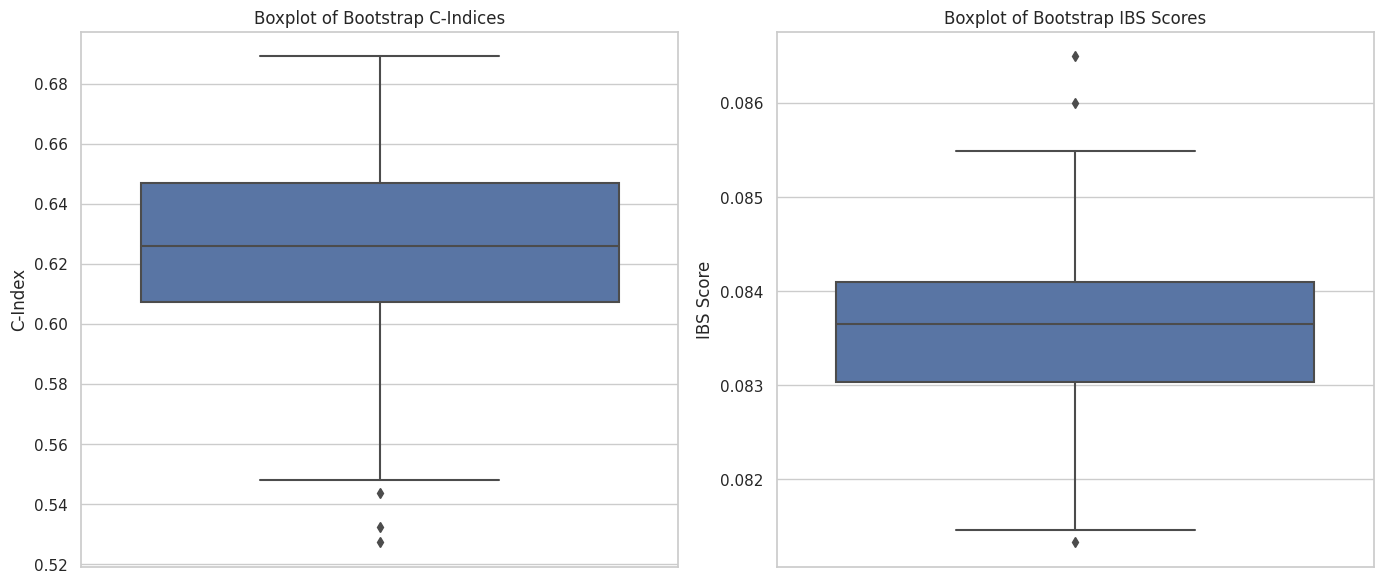

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Subplot for C-index
plt.subplot(1, 2, 1)
sns.boxplot(y=c_indices_deepsurv)
plt.title("Boxplot of Bootstrap C-Indices")
plt.ylabel("C-Index")

# Subplot for IBS
plt.subplot(1, 2, 2)
sns.boxplot(y=ibs_scores_deepsurv)
plt.title("Boxplot of Bootstrap IBS Scores")
plt.ylabel("IBS Score")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/c_indices_deepsurv.npy', c_indices_deepsurv)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/ibs_scores_deepsurv.npy', ibs_scores_deepsurv)
